In [1]:
import GPy
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from numpy.linalg import inv
sys.path.insert(0, '/Users/dananjayaliyanage/git/emulator-validation/src')
from configurations import load_design, transform_design
from bayes_mcmc import *
from emulator import *
from calculations_load import trimmed_model_data
from bins_and_cuts import *
import matplotlib.patches as mpatches
from bayes_exp import Y_exp_data
from sklearn.preprocessing import StandardScaler

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'labels': ['$N$[$2.76$TeV]', '$p$', '$\\sigma_k$', '$w$ [fm]', '$d_{\\mathrm{min}}$ [fm]', '$\\tau_R$ [fm/$c$]', '$\\alpha$', '$T_{\\eta,\\mathrm{kink}}$ [GeV]', '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]', '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]', '$(\\eta/s)_{\\mathrm{kink}}$', '$(\\zeta/s)_{\\max}$', '$T_{\\zeta,c}$ [GeV]', '$w_{\\zeta}$ [GeV]', '$\\lambda_{\\zeta}$', '$b_{\\pi}$', '$T_{\\mathrm{sw}}$ [GeV]'], 'ma

 /Users/dananjayaliyanage/miniconda3/envs/sensitivity/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
 /Users/dananjayaliyanage/miniconda3/envs/sensitivity/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
 /Users/dananjayaliyanage/miniconda3/envs/sensitivity/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning:Trying to unpickle estima

In [2]:
# Put all model parametr names to an array
model_labels= ['norm','trento_p','sigma_k','nucleon_width','dmin3','tau_R','alpha','shear_relax_time_factor','Tswitch']
viscous_eta=[r'$\eta \,$ at T={} GeV'.format(round(i,2)) for i in np.linspace(0.135,0.4,10)]
viscous_bulk=[r'$\zeta \,$ at T={} GeV'.format(round(i,2)) for i in np.linspace(0.135,0.4,10)]
all_model_labels=model_labels+viscous_eta+viscous_bulk

In [3]:
MAP_params = {'Pb-Pb-2760': [14.128, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136],
              'Au-Au-200' : [5.821, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136]
                }

In [4]:
map_values=np.array(MAP_params["Pb-Pb-2760"])

In [5]:
MAP=transform_design(map_values.reshape(1,-1))

In [77]:
MAP

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [78]:
em=Trained_Emulators['Pb-Pb-2760']

In [8]:
# Get all the observables list
nobs=0
observables=[]
for obs, cent_list in obs_cent_list['Pb-Pb-2760'].items():
    observables.append(obs)
    n = np.array(cent_list).shape[0]
    #self._slices[obs] = slice(self.nobs, self.nobs + n)
    nobs += n

In [228]:
# Get the simulation results corresponding to design points

SS=StandardScaler(copy=False)
Y=[]
for ipt, data in enumerate(trimmed_model_data['Pb-Pb-2760']):
    row = np.array([])
    for obs in observables:
        values = np.array(data[idf][obs]['mean'])
        if np.isnan(values).sum() > 0:
            print("WARNING! FOUND NAN IN MODEL DATA WHILE BUILDING EMULATOR!")
            print("Design pt = " + str(pt) + "; Obs = " + obs)
        row = np.append(row, values)
    Y.append(row)
Y = np.array(Y)
print("Y_Obs shape[Ndesign, Nobs] = " + str(Y.shape))
pca = PCA(copy=False, whiten=True, svd_solver='full')
Z=pca.fit_transform(SS.fit_transform(Y))[:,:10]

Y_Obs shape[Ndesign, Nobs] = (485, 123)


In [10]:
# Get design parametrs for which are already transformed model parameter
design, design_max, design_min, labels = prepare_emu_design('Pb-Pb-2760')

Loading main points from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat
Loading main ranges from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat
Summary of design : 
Note : Transforming design of viscosities


In [11]:
if len(delete_design_pts_set) > 0:
    print("Warning! Deleting " + str(len(delete_design_pts_set)) + " points from data")
    design = np.delete(design, list(delete_design_pts_set), 0)

Warning! Deleting 15 points from data


In [263]:
em.gps[0].X_train_.shape

(485, 29)

In [224]:
boho=em.gps[0].y_train_.reshape(485,1)

In [231]:
boho[0:20]

array([[ 0.26841718],
       [ 0.06826242],
       [ 1.18692676],
       [ 0.41644668],
       [ 0.71570644],
       [-0.16002865],
       [ 0.68232638],
       [ 0.25163932],
       [-0.1168344 ],
       [ 1.08545563],
       [ 0.36866437],
       [-0.387509  ],
       [ 0.58868541],
       [ 0.67357912],
       [ 0.57073162],
       [ 0.06325995],
       [ 0.40788239],
       [-0.22504775],
       [-0.32983959],
       [ 0.05700586]])

In [407]:
em.gps[3].get_params()

{'alpha': 0.1,
 'copy_X_train': False,
 'kernel__k1': 1**2 * RBF(length_scale=[9.98, 1.4, 1.7, 0.999, 4.91, 1.7, 0.598, 5.99, 0.0349, 0.486, 0.427, 0.369, 0.324, 0.376, 0.432, 0.489, 0.546, 0.603, 0.66, 0.194, 0.196, 0.196, 0.198, 0.198, 0.193, 0.19, 0.178, 0.164, 0.151]),
 'kernel__k2': WhiteKernel(noise_level=0.1),
 'kernel__k1__k1': 1**2,
 'kernel__k1__k2': RBF(length_scale=[9.98, 1.4, 1.7, 0.999, 4.91, 1.7, 0.598, 5.99, 0.0349, 0.486, 0.427, 0.369, 0.324, 0.376, 0.432, 0.489, 0.546, 0.603, 0.66, 0.194, 0.196, 0.196, 0.198, 0.198, 0.193, 0.19, 0.178, 0.164, 0.151]),
 'kernel__k1__k1__constant_value': 1.0,
 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k1__k2__length_scale': array([9.98205   , 1.39641   , 1.69935   , 0.99873   , 4.90649   ,
        1.69607   , 0.59843   , 5.98973   , 0.03489   , 0.48579691,
        0.42717744, 0.36855797, 0.32421837, 0.37560888, 0.43243489,
        0.48926091, 0.54608692, 0.60291293, 0.65973894, 0.19400862,
        0.19587624,

In [421]:
em.gps[6].alpha

0.1

In [418]:
em.gps[6].kernel_.get_params()

{'k1': 2.75**2 * RBF(length_scale=[32.6, 2.21, 3.25, 1.76, 491, 2.09, 0.716, 25.2, 0.0649, 48.6, 42.7, 0.397, 32.4, 37.6, 43.2, 48.9, 2.21, 60.3, 66, 0.379, 0.839, 1.16, 19.8, 19.6, 19.3, 19, 17.8, 16.4, 2.82]),
 'k2': WhiteKernel(noise_level=0.01),
 'k1__k1': 2.75**2,
 'k1__k2': RBF(length_scale=[32.6, 2.21, 3.25, 1.76, 491, 2.09, 0.716, 25.2, 0.0649, 48.6, 42.7, 0.397, 32.4, 37.6, 43.2, 48.9, 2.21, 60.3, 66, 0.379, 0.839, 1.16, 19.8, 19.6, 19.3, 19, 17.8, 16.4, 2.82]),
 'k1__k1__constant_value': 7.5626595926800695,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': array([3.26155889e+01, 2.20795265e+00, 3.25229905e+00, 1.75596567e+00,
        4.90649000e+02, 2.08747365e+00, 7.16091301e-01, 2.52237037e+01,
        6.48795606e-02, 4.85796913e+01, 4.27177440e+01, 3.97209650e-01,
        3.24218373e+01, 3.75608883e+01, 4.32434894e+01, 4.89260905e+01,
        2.21255494e+00, 6.02912927e+01, 6.59738938e+01, 3.78561516e-01,
        8.38738537e-01, 1.16000753e+00, 

In [361]:
GPy_emulators[0].kern.param_array

array([1.47226967e+01, 2.88687065e+01, 3.02079097e+00, 5.97227624e+00,
       4.80807008e+00, 2.43159811e+02, 5.24663641e+00, 3.04496805e+01,
       5.04945563e+02, 2.24319632e-01, 4.85796913e+01, 4.27177440e+01,
       1.85347697e+00, 3.24218373e+01, 3.75608883e+01, 4.32434894e+01,
       1.27731953e+00, 5.46086916e+01, 6.02912927e+01, 6.59738938e+01,
       1.94008625e+01, 4.47652802e-01, 7.76220157e+00, 1.98467534e+01,
       1.98167564e+01, 1.92776110e+01, 8.98130699e+00, 1.77525507e+01,
       1.64284543e+01, 1.50849565e+01])

In [430]:
# a function that takes Scikit lern emulator as input and return the corresponding GPy emulator.
def convertToGPy(Scikit_emu):
    """Takes a scikitlearn gaussian emulator as input and conver it to a GPy gaussian emulator. This needs
    design space parameters and the corresponding pca observable (PCA 1, PCA 2 etc)"""
    dic=Scikit_emu.kernel_.get_params()
    kernel1= GPy.kern.RBF(input_dim=29, variance=dic['k1__k1__constant_value'], lengthscale=dic["k1__k2"].get_params()["length_scale"],ARD=True)
    kernal2=GPy.kern.White(input_dim=29,variance=0.1)
    kernel=kernel1+kernal2
    m = GPy.models.GPRegression(Scikit_emu.X_train_,Scikit_emu.y_train_.reshape(-1,1),kernel,noise_var=dic["k2__noise_level"])
    #m.constrain_positive('') 
    #m.optimize_restarts(num_restarts = 10)
    return m
    

In [320]:
#MAP_ll=np.array([[i] for i in MAP])

In [354]:
GPy_emulators[0].kern

GP_regression.rbf.variance:
Param([14.72269671])

In [16]:
#em.gps[3].predict(MAP_ll.reshape(1,29) , return_cov=True)

In [17]:
#GPy_emulators[3].predict(MAP_ll.reshape(1,29))

In [431]:
#make an dictionary of GPy emulators corresponding to each of the 10 PCA components of the observables
GPy_emulators={}
for i in range(0,10):
    EM=em.gps[i]
    #zz=Z.T[i].reshape(-1,1)
    #print(zz.reshape(-1,))
    #print(em.gps[-i].y_train_)
    #print(zz-em.gps[i].y_train_)
    GPy_emulators[i]=convertToGPy(Scikit_emu=EM)

In [254]:
map_values

array([14.128,  0.089,  1.054,  1.064,  4.227,  1.507,  0.113,  0.223,
       -1.585,  0.32 ,  0.056,  0.11 ,  0.16 ,  0.093, -0.084,  4.666,
        0.136])

In [432]:
GPy_emulators[2].predict(Xnew=MAP)


(array([[-0.26399637]]), array([[0.11455937]]))

In [433]:
em.gps[2].predict(MAP,return_cov=True)

(array([-0.26399637]), array([[0.01455937]]))

array([ 0.00000000e+00,  2.30078848e+00,  3.33904657e-01,  5.30245825e-01,
       -1.27080713e-03,  1.59055882e+00,  5.28313810e-01, -5.13445720e-01,
        1.79004634e+00, -3.35555502e+00, -7.21964618e-01, -8.50555801e-01,
       -9.98157272e-01, -1.12633800e+00, -9.79206882e-01, -8.38323498e-01,
       -7.14859384e-01, -6.04977129e-01, -5.05982492e-01, -4.15911070e-01,
       -1.63985266e+00, -1.63027224e+00, -1.62961717e+00, -1.61712975e+00,
       -1.61864232e+00, -1.64622581e+00, -1.66246701e+00, -1.72864098e+00,
       -1.80615534e+00, -1.89147219e+00, -2.30258509e+00])

In [256]:
transform_design(map_values.reshape(1,-1))

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [434]:
## get a design matrix of only one parameter varying
def getDesignMatrix(param,MAP_parameter_Values):
    """get a design matrix of 300 uniformly distibuted points with only one parameter varying.
    All the other parameters are in the MAP values. return matrix dimension (300,29)"""
    x_eta=np.linspace(design_min[param],design_max[param],300) # get 300 x axis values for the plot
    LL=np.zeros((300,29))
    x=transform_design(MAP_parameter_Values.reshape(1,-1))
   # print(x)
    for i,j in enumerate(x_eta):
        #print(j)
        np.put(x,param,j)
       # x[param]=j
       # print(x)
       # print(j)
        LL[i,:]=x
    return LL,x_eta

In [435]:
#Write a function that will take one of the 10 GPy emulators and plot how the corresponding PCA value change
#with each parameter in the model keeping all the other parameters fixed at MAP values.... produce 29 graphs ....

def PCAgraphs(PCA_number,GPy_array):
    m = GPy_array[PCA_number]
    for k in range(0,29):
        LL,x_predict=getDesignMatrix(k,np.array(MAP_params["Pb-Pb-2760"]))
        mean_grad,var_grad=m.predict_jacobian(Xnew=LL)
        y_predict,var_predict=m.predict(Xnew=LL)
        # only get the diagonal and the relevent mean for changing model parameter
        #diagonal=np.zeros((300,1))
       # mean=np.zeros((300,1))
        diagonal=[]
        mean=[]
        #y_predict=np.zeros((300,1))
        #sigma_predict=np.zeros((300,1))
        for ii in range(0,300):
            cov=var_grad[ii]
           # print(cov.diagonal())
            diagonal.append(cov.diagonal()[k])
            my_ll= np.array(cov.diagonal())>0
           # print(my_ll)
          #  if all(my_ll)==True:
         #       print(f'no trouble for {k}')
            mean.append(mean_grad[ii][k])
        #    sigma_predict[i]=ysigma_predict.diagonal()[2]
        #y_predict=y_predict
        #print(var_predict)
        sigma_grad=np.sqrt(diagonal)
        mean_grad=np.array(mean)
        sigma_predict=np.sqrt(var_predict)
        # Plot the function, the prediction and the 95% confidence interval based on
        # the MSE
        %matplotlib inline
        plt.figure(figsize=(7,7))
       #plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
        plt.plot(design[:,k],Z.T[PCA_number], 'r.', markersize=10, label='simulation data')
        plt.plot(x_predict.flatten(), y_predict.flatten(), 'r', label='Prediction from GP emulator')
        plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
        plt.xlabel(f'{all_model_labels[k]}')
        plt.ylabel(f'PCA component {PCA_number}')
        #plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
        plt.plot(x_predict.flatten(), mean_grad.flatten(), 'k', label='Gradiant prediction')
        plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='y', ec='None')
        plt.title('Gradiant of the gaussian process found by Gpy')
        plt.tight_layout()
        plt.legend(loc='lower left')
        plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/emulator_gradients/emu{PCA_number}param{k}.png',dpi=100)
        plt.show()

# The huge variance for gradients is a result of having very small corelation lengths in the optimized Gaussian emulator

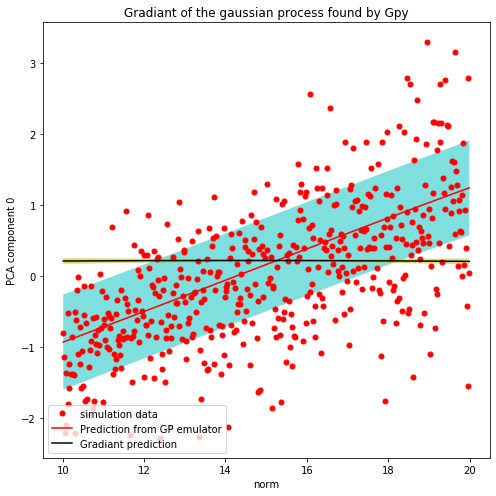

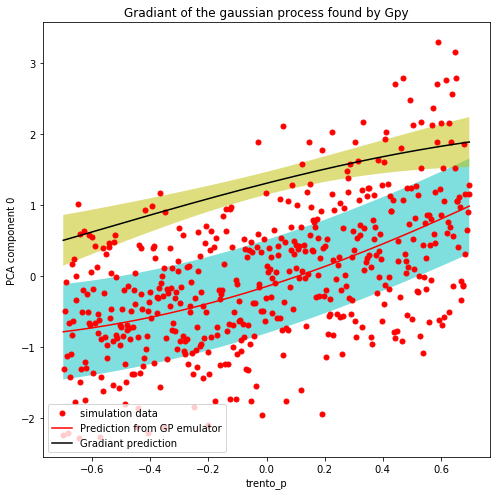

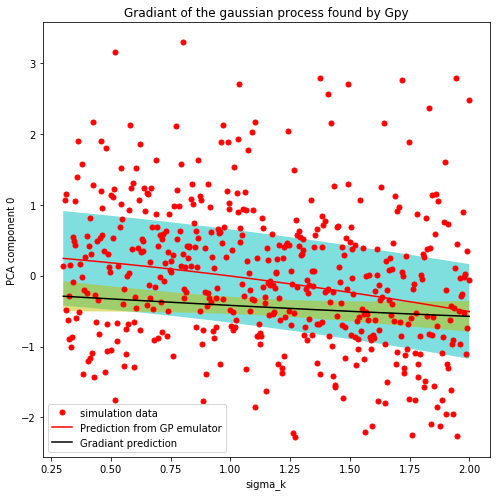

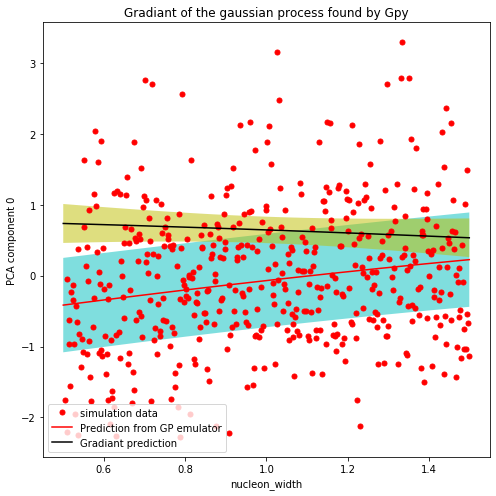

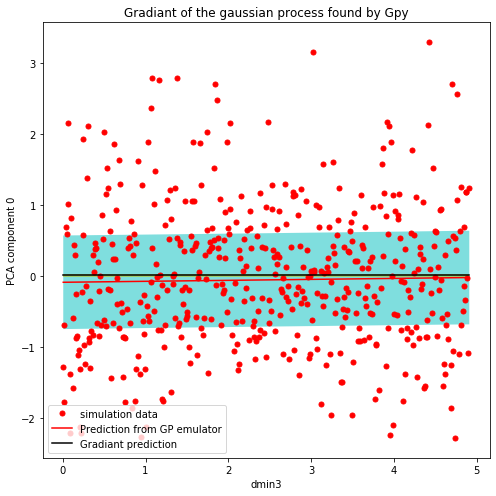

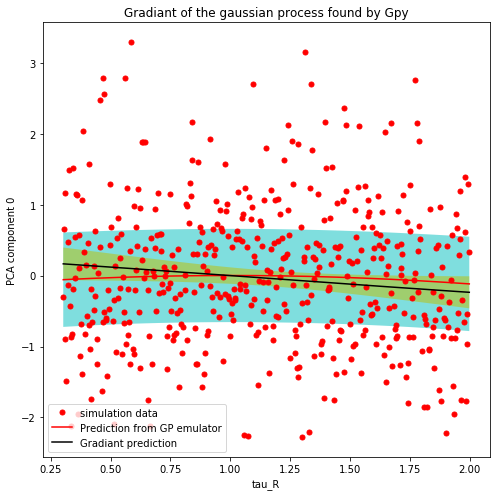

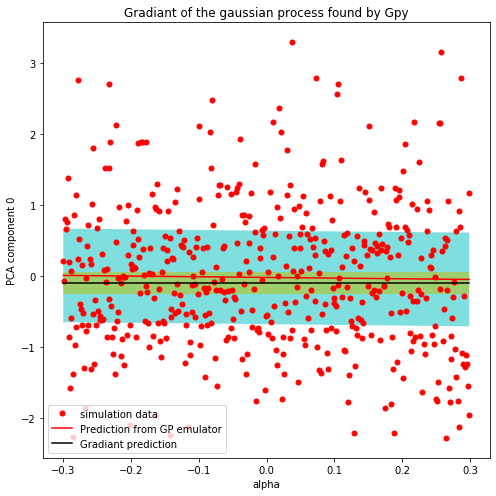

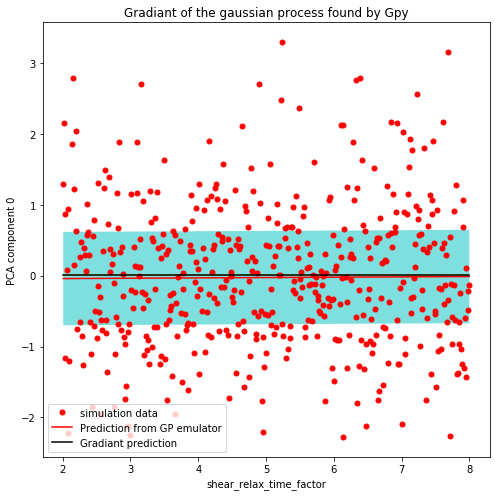

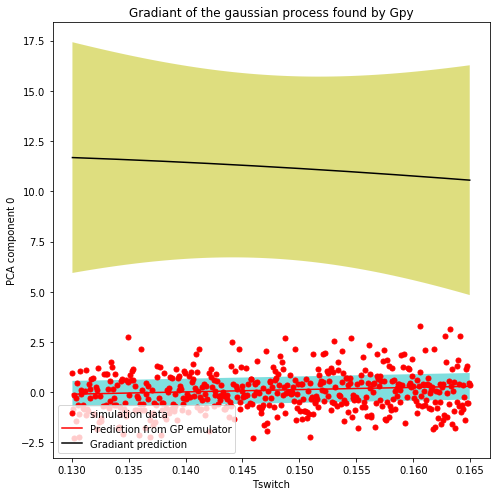

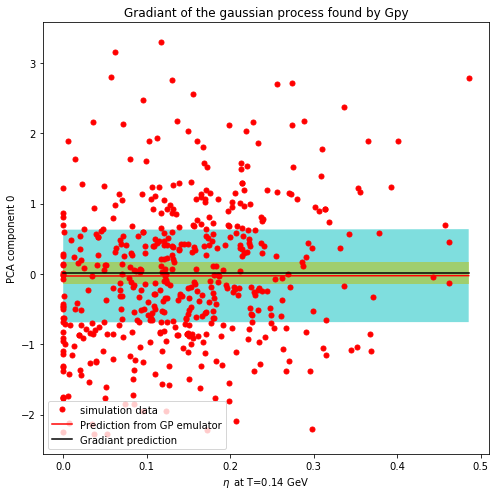

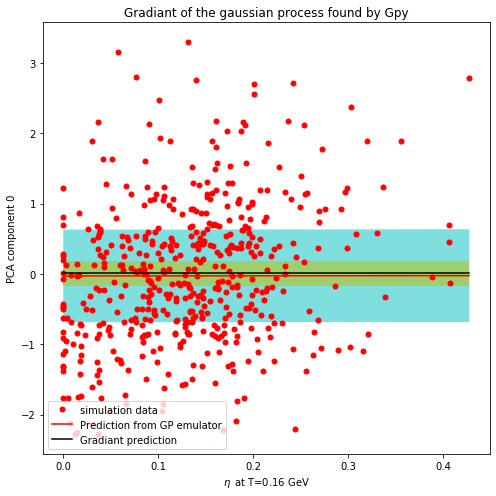

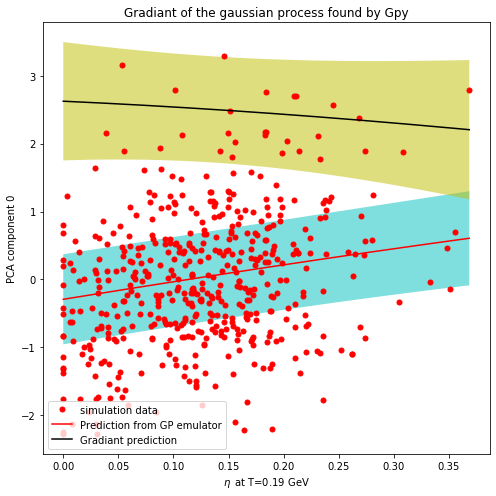

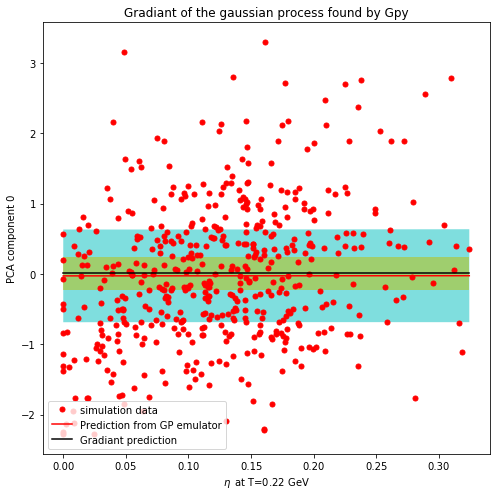

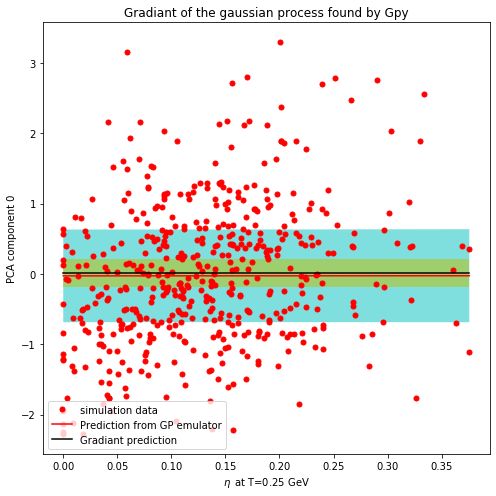

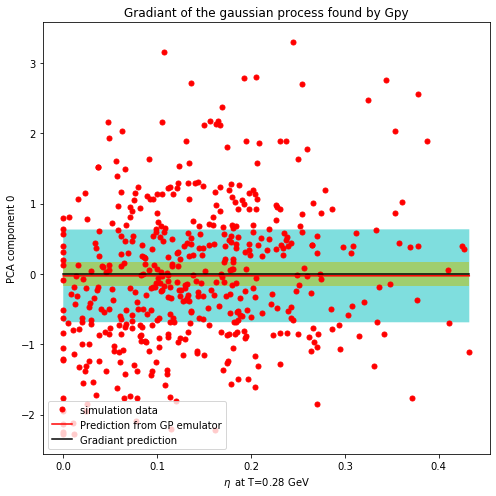

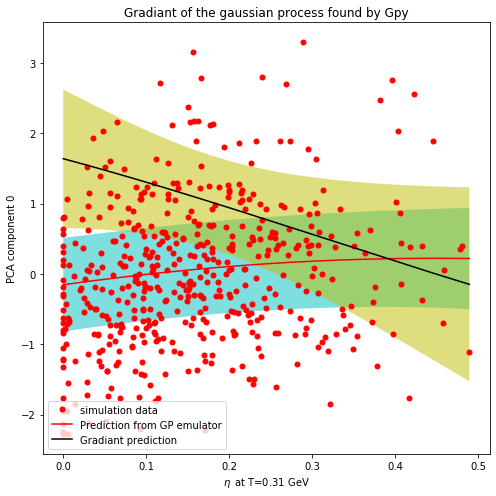

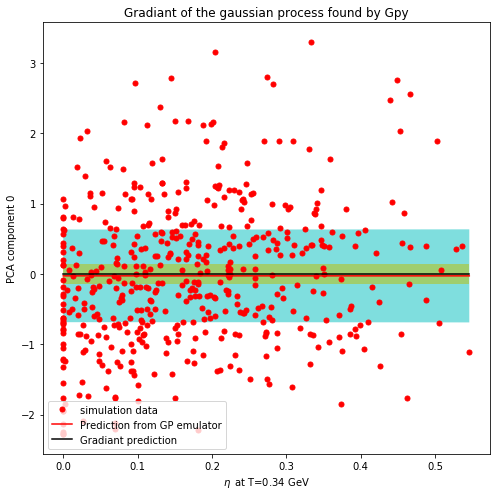

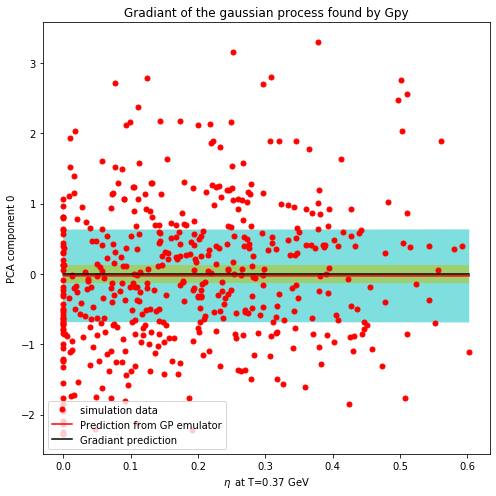

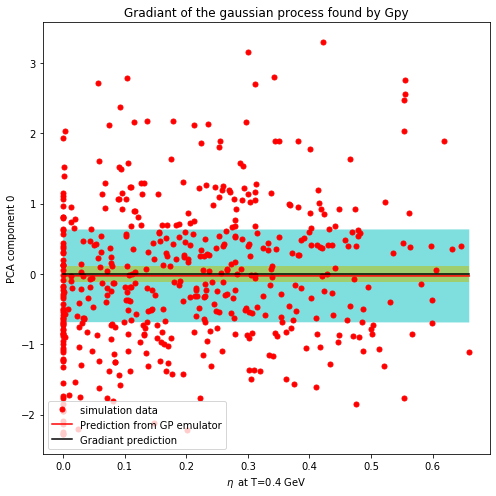

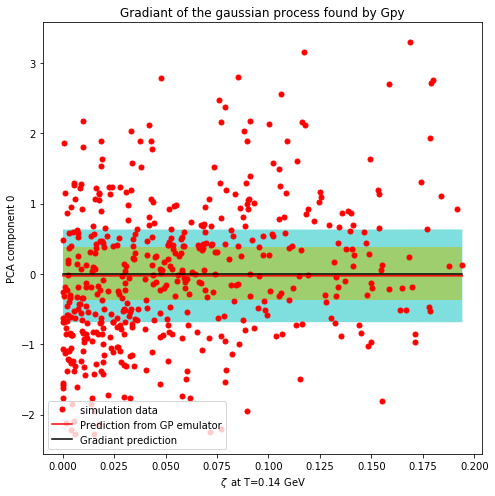

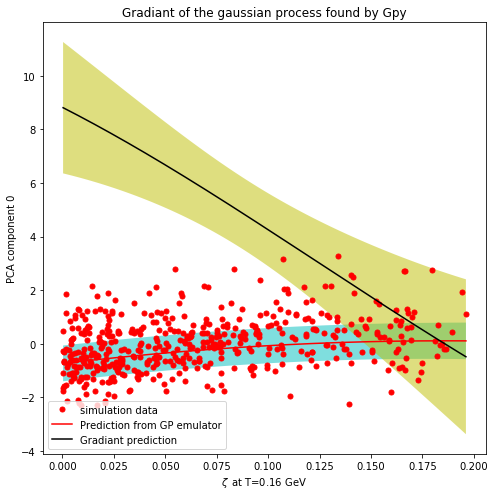

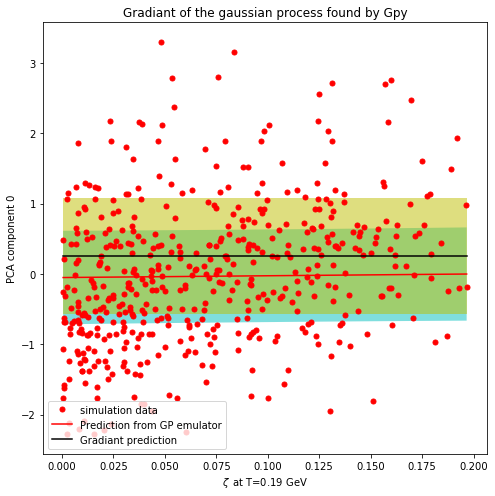

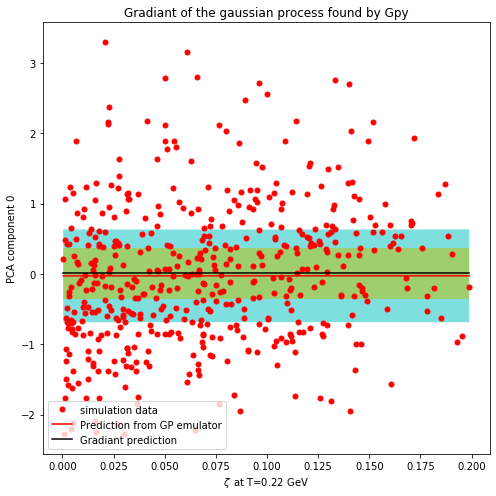

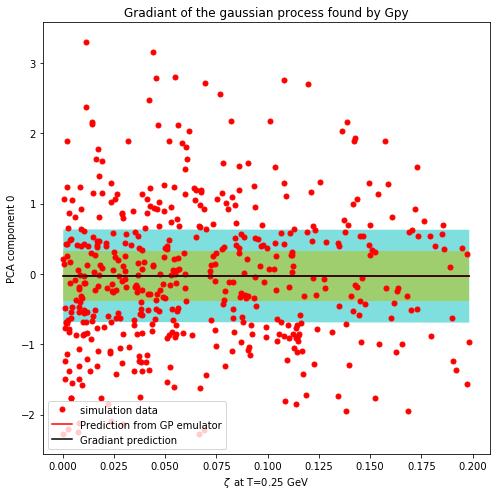

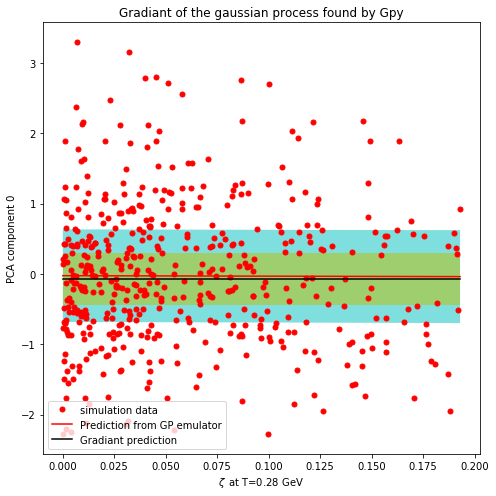

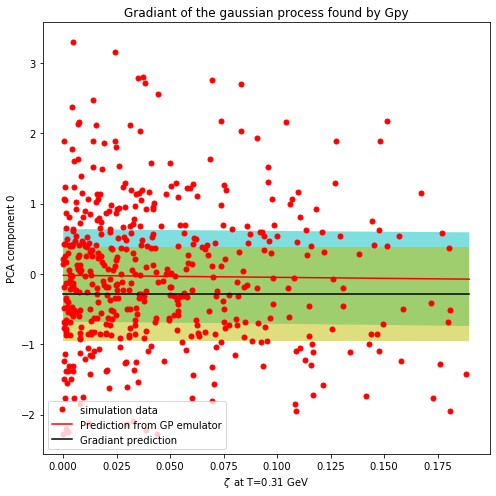

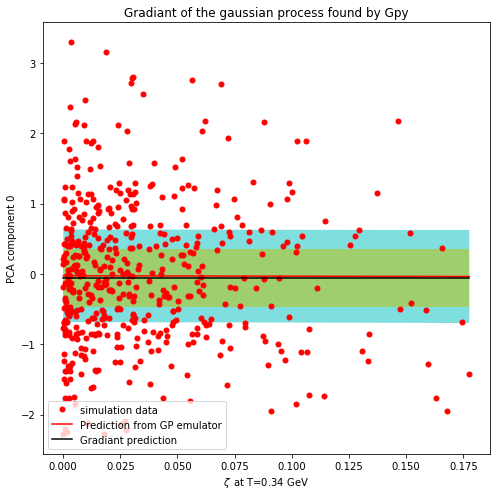

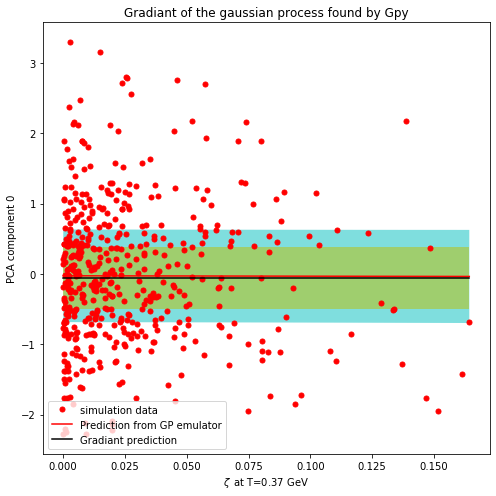

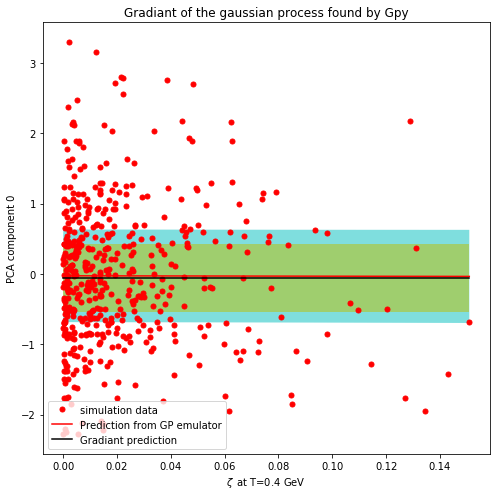

In [436]:
PCAgraphs(0,GPy_emulators)

In [22]:
em.gps[0].get_params()["kernel__k1__k2"]

RBF(length_scale=[9.98, 1.4, 1.7, 0.999, 4.91, 1.7, 0.598, 5.99, 0.0349, 0.486, 0.427, 0.369, 0.324, 0.376, 0.432, 0.489, 0.546, 0.603, 0.66, 0.194, 0.196, 0.196, 0.198, 0.198, 0.193, 0.19, 0.178, 0.164, 0.151])

In [83]:
MAP

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [272]:
GPy_emulators[4].predict(Xnew=MAP)
em.gps[4].predict(MAP)

(array([[-0.09414013]]), array([[0.01080461]]))

array([-0.09244022])

## There are negative variances in the diagonal. I don't understand why is this so yet

In [107]:
MAP

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [131]:
MAP

array([[1.41280000e+01, 8.90000000e-02, 1.05400000e+00, 1.06400000e+00,
        4.22700000e+00, 1.50700000e+00, 1.13000000e-01, 4.66600000e+00,
        1.36000000e-01, 1.95480000e-01, 1.48810556e-01, 1.02141111e-01,
        5.61066667e-02, 6.55288889e-02, 7.49511111e-02, 8.43733333e-02,
        9.37955556e-02, 1.03217778e-01, 1.12640000e-01, 1.03627213e-01,
        1.09701400e-01, 9.49704400e-02, 7.08432682e-02, 5.03173029e-02,
        3.59657530e-02, 2.63805510e-02, 1.99277275e-02, 1.54731465e-02,
        1.23081479e-02]])

In [143]:
LL[1:3,:].shape

(2, 29)

In [437]:
grad_arry=np.zeros((29,10))
MapObsAry=np.zeros(10)
sigma_arry=np.zeros((29,10))
LL,x_predict=getDesignMatrix(0,np.array(MAP_params["Pb-Pb-2760"]))
for k in range(0,10):
        m=GPy_emulators[k]
        grad,var_grad=m.predict_jacobian(Xnew=MAP)
        map_obs,_=m.predict(Xnew=MAP)
     #   print(var_grad[0].diagonal())
        grad_arry[:,k]=grad.reshape(29,)
     #   print(grad.shape)
        #var_grad=vvarrr[0] 
        l=0
        for i in var_grad[0].diagonal():
            if i<0:
                l=l+1
        print(f'pca is {k} with {l} negatives')
        sigma=np.sqrt(var_grad[0].diagonal())
        sigma_arry[:,k]=sigma.reshape(29,)
        MapObsAry[k]=map_obs[0]

MapObservabes=em._inverse_transform(MapObsAry)

pca is 0 with 0 negatives
pca is 1 with 0 negatives
pca is 2 with 0 negatives
pca is 3 with 0 negatives
pca is 4 with 0 negatives
pca is 5 with 0 negatives
pca is 6 with 0 negatives
pca is 7 with 0 negatives
pca is 8 with 0 negatives
pca is 9 with 0 negatives


In [438]:
MapObservabes

{'dNch_deta': array([1472.92911927, 1203.00318201,  909.17044717,  616.41483365,
         403.44547123,  250.8212499 ,  142.88799386,   71.65771318]),
 'dET_deta': array([1960.07716806, 1745.90427102, 1581.80695033, 1435.63604599,
        1304.10720359, 1185.63451054, 1075.02754652,  975.57640943,
         883.47436987,  797.92962774,  718.52243396,  645.22072311,
         577.27649674,  515.9348787 ,  459.35302372,  407.40944363,
         337.92861066,  257.59752431,  191.74450873,  138.36624556,
          96.4060626 ,   64.24039156]),
 'dN_dy_pion': array([1364.67427718, 1114.34696837,  841.99098881,  571.18090458,
         374.51399194,  233.50650966,  133.56462771,   67.33376869]),
 'dN_dy_kaon': array([231.59677306, 190.12948874, 144.76355248,  99.2219743 ,
         65.7180393 ,  41.4274645 ,  23.99281584,  12.27573875]),
 'dN_dy_proton': array([67.6280023 , 56.05312307, 43.16914416, 30.04295078, 20.15760558,
        12.84343617,  7.49830741,  3.82543478]),
 'dN_dy_Lambda': array(

In [444]:
Y_exp_data['Pb-Pb-2760']['mean_pT_pion']

array([([0.5185, 0.519 , 0.519 , 0.514 , 0.5055, 0.4945, 0.4805, 0.4675], [0.0185, 0.0175, 0.017 , 0.017 , 0.017 , 0.0175, 0.017 , 0.0165]),
       ([0.5185, 0.519 , 0.519 , 0.514 , 0.5055, 0.4945, 0.4805, 0.4675], [0.0185, 0.0175, 0.017 , 0.017 , 0.017 , 0.0175, 0.017 , 0.0165]),
       ([0.5185, 0.519 , 0.519 , 0.514 , 0.5055, 0.4945, 0.4805, 0.4675], [0.0185, 0.0175, 0.017 , 0.017 , 0.017 , 0.0175, 0.017 , 0.0165]),
       ([0.5185, 0.519 , 0.519 , 0.514 , 0.5055, 0.4945, 0.4805, 0.4675], [0.0185, 0.0175, 0.017 , 0.017 , 0.017 , 0.0175, 0.017 , 0.0165])],
      dtype=[('mean', '<f8', (8,)), ('err', '<f8', (8,))])

In [445]:
dicc=em._inverse_transform(grad_arry[2,:])

In [446]:
### Get the factors I have to multiply gradients with to make them dimensio #model parameter unit in the numerator. 
Map_model_param_for_dim=MAP.reshape(29,) 
#MapObservabes=em.predict(X=Map_model_param_for_dim.reshape(1,29))


In [184]:
#Function where we specefy the observable.
# we will get a plot as a result showing how sensitive this observable for all centrality to all model parameters
#at MAp parameters



def sensitivity_plot(observable_name):
    modelparam_Gradient=[]
    modelparam_Grad_sigma=[]
    for i in range(1,29):
        temp_dic_all_grad=em._inverse_transform(grad_arry[i,:])
       # print(grad_arry[i,:])
       # print(temp_dic_all_grad)
        temp_dic_all_var=em._inverse_transform(sigma_arry[i,:])
        modelparam_Gradient.append(temp_dic_all_grad[observable_name])
        modelparam_Grad_sigma.append(temp_dic_all_var[observable_name])
    centrality=obs_cent_list["Pb-Pb-2760"][observable_name]
    fig,ax=plt.subplots(nrows=1, ncols=1, sharex=False ,figsize=(10, 10))
    #fig,axes=plt.subplots(nrows=2, ncols=1, sharex=False ,figsize=(10, 10))
    n_cen=len(centrality)
    #brg= plt.get_cmap('brg')
    #colors = iter(brg(np.linspace(0,1,n_cen)))
    X_values=np.array([i for i in range(1,29)])
    #print(X_values.shape)
    #X_values.reshape(29,)
    print(n_cen)
    
    for j in range(0,n_cen):
        if centrality[j][0]!= 40:
            print(centrality[j][0])
            continue
        sensitivity_list=[grad_cent_arry[j] for grad_cent_arry in modelparam_Gradient]
        sensitivity_error=[grad_error_cent_arry[j] for grad_error_cent_arry in modelparam_Grad_sigma]
        #sensitivity_list=np.array(sensitivity_list)
        #sensitivity_error=np.array(sensitivity_error)
        sensitivity_list=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_list)]).flatten()
       # sensitivity_error=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_error)]).flatten()
       # print(sensitivity_list)
       # print("error")
       # print(sensitivity_error)
                                   
        #print(f'length of sens {sensitivity_list.shape} and length of error {sensitivity_error.shape}')
        #ax.plot(X_values,sensitivity_list)
        #print(sensitivity_list)
       # print("error next")
       # print(sensitivity_error)
        #ax.errorbar(X_values,sensitivity_list,yerr=sensitivity_error,fmt='o',ecolor='r')
        positives= sensitivity_list>0
       # negatives= sensitivity_list<0
       # ax.scatter(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5 , s= 200 , label= centrality[j],color=next(colors))
       # ax.plot(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5, label= centrality[j],color=next(colors))
        barlist=ax.bar(X_values,np.log(abs(sensitivity_list)),label= centrality[j])
        for j,difference in enumerate(positives):
            if difference==False:
                barlist[j].set_color('r')  
       # ax.scatter(X_values[negatives],np.log(abs(sensitivity_list[negatives])), marker='x' , alpha=0.5 , s =200, label= centrality[j] , cmpa= 'PiYG' )
        ax.set_ylabel(observable_name)#+f'  {centrality[j]}',fontsize=14)
        ax.grid(b=True,axis='x')
        ax.set_xticks(X_values) 
    #plt.xticks(X_values,model_labels)
    plt.xlabel('Model parameters',fontsize=18)
    plt.xticks(rotation='vertical',fontsize=14)
    plt.legend()
   # plt.ylabel('Varied Observable',fontsize=18)
    plt.tight_layout()
    
    #plt.title("Gradients")
    plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/sensitivity/sensitivity_{observable_name}.png',dpi=100)
    plt.show()

In [447]:
#Function where we specefy the observable.
# we will get a plot as a result showing how sensitive this observable for all centrality to all model parameters
#at MAp parameters
dicc=em._inverse_transform(grad_arry[2,:])
def sensitivity_plot_scott(centrality_begin,model_param):
    modelparam_Gradient=[]
    modelparam_Grad_sigma=[]
    MapObservabesUnits=[]
    sensitivity_list=[]
    X_values=[]
    X_name=[]
    temp_dic_all_grad=em._inverse_transform(grad_arry[model_param,:])
    temp_dic_all_var=em._inverse_transform(sigma_arry[model_param,:])
    fig,ax=plt.subplots(nrows=1, ncols=1, sharex=False ,figsize=(10, 10))
    specefic_cen_num=[]
    dic_keys=[key for _,key in enumerate(dicc.keys())]
    for i in dicc.keys():
       # print(grad_arry[i,:])
       # print(temp_dic_all_grad)
      #  modelparam_Gradient.append(temp_dic_all_grad[observable_name])
      #  modelparam_Grad_sigma.append(temp_dic_all_var[observable_name])
        centrality=obs_cent_list["Pb-Pb-2760"][i]
    #fig,axes=plt.subplots(nrows=2, ncols=1, sharex=False ,figsize=(10, 10))
        n_cen=len(centrality)
    #brg= plt.get_cmap('brg')
    #colors = iter(brg(np.linspace(0,1,n_cen)))
    #print(X_values.shape)
    #X_values.reshape(29,)
    #print(n_cen)
    
        for j in range(0,n_cen):
            if centrality[j][0]== centrality_begin:
                #print(centrality[j][0])
                specefic_cen_num.append(j)
    #            MapObservabesUnits.append(MapObservabes[i][j])
    l=0
    for i,key in enumerate(dic_keys):

        sensitivity_list.append(temp_dic_all_grad[key][0])
        #print(temp_dic_all_grad[key][0])
        MapObservabesUnits.append(MapObservabes[key][0])
        X_values.append(2*l)
        X_name.append(dic_keys[i] + str(obs_cent_list["Pb-Pb-2760"][key][0]))
        sensitivity_list.append(temp_dic_all_grad[key][-3])
        X_values.append(2*l+1)
        X_name.append(dic_keys[i] + str(obs_cent_list["Pb-Pb-2760"][key][-3]))
        l=l+1
        MapObservabesUnits.append(MapObservabes[key][-3])
   # print(MapObservabesUnits)
    #print(MapObservabesUnits)    
    #MapObservabesUnits=MapObservabesUnits+MapObservabesUnits
    #X_values=range(0,2*len(MapObservabesUnits))            
    #sensitivity_list_1=[grad_cent_arry[0] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list_2=[grad_cent_arry[-1] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list=sensitivity_list_1+sensitivity_list_2

    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #print(len(X_values))
    #print(len(sensitivity_list))
        #sensitivity_list=np.array(sensitivity_list)
        #sensitivity_error=np.array(sensitivity_error)
    sensitivity_list=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_list)]).flatten()
    #sensitivity_error=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_error)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_error)]).flatten()
       # print(sensitivity_list)
       # print("error")
       # print(sensitivity_error)
                                   
        #print(f'length of sens {sensitivity_list.shape} and length of error {sensitivity_error.shape}')
        #ax.plot(X_values,sensitivity_list)
        #print(sensitivity_list)
       # print("error next")
       # print(sensitivity_error)
        #ax.errorbar(X_values,sensitivity_list,yerr=sensitivity_error,fmt='o',ecolor='r')
    positives= sensitivity_list>0
       # negatives= sensitivity_list<0
       # ax.scatter(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5 , s= 200 , label= centrality[j],color=next(colors))
       # ax.plot(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5, label= centrality[j],color=next(colors))
   # barlist=ax.bar(X_values,np.log(abs(sensitivity_list)))#,yerr=sensitivity_error)
    barlist=ax.bar(X_values,sensitivity_list)#,yerr=sensitivity_error)
    for j,difference in enumerate(positives):
        if difference==False:
            barlist[j].set_color('c')  
       # ax.scatter(X_values[negatives],np.log(abs(sensitivity_list[negatives])), marker='x' , alpha=0.5 , s =200, label= centrality[j] , cmpa= 'PiYG' )
    ax.set_ylabel(all_model_labels[model_param],fontsize=18)
    ax.grid(b=True,axis='x')
    #ax.set_xticks(X_values) 
    plt.xticks(X_values,X_name)
    #plt.xlabel(f'Observables',fontsize=18)
    plt.xticks(rotation='vertical',fontsize=14)
    #plt.legend()
   # plt.ylabel('Varied Observable',fontsize=18)
    plt.tight_layout()
    blue_patch = mpatches.Patch(color='blue', label=' + Gradient')
    cyan_patch = mpatches.Patch(color='cyan', label=' - Gradient')
    plt.legend(handles=[blue_patch, cyan_patch])
    #plt.title("Gradients")
    plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/sensitivity/without_error/sensitivity_{model_param}.png',dpi=100)
    plt.show()

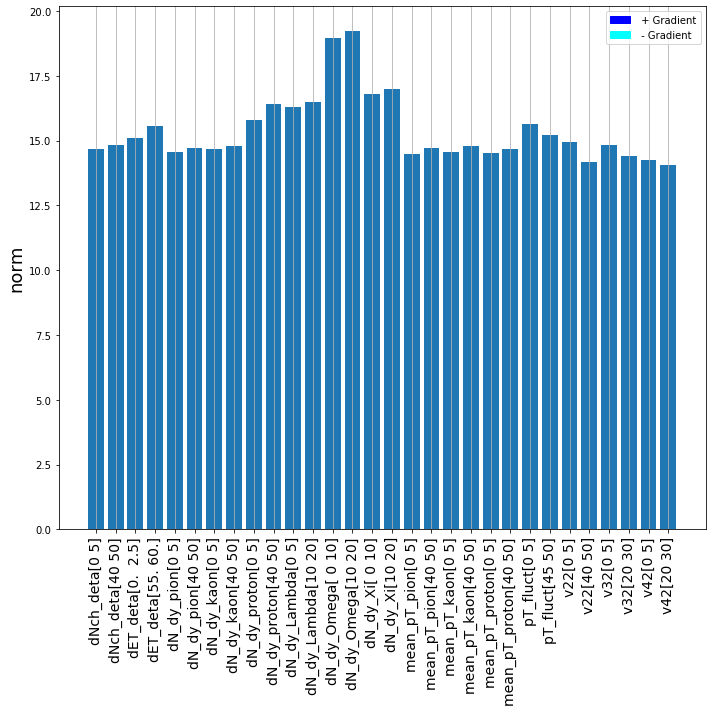

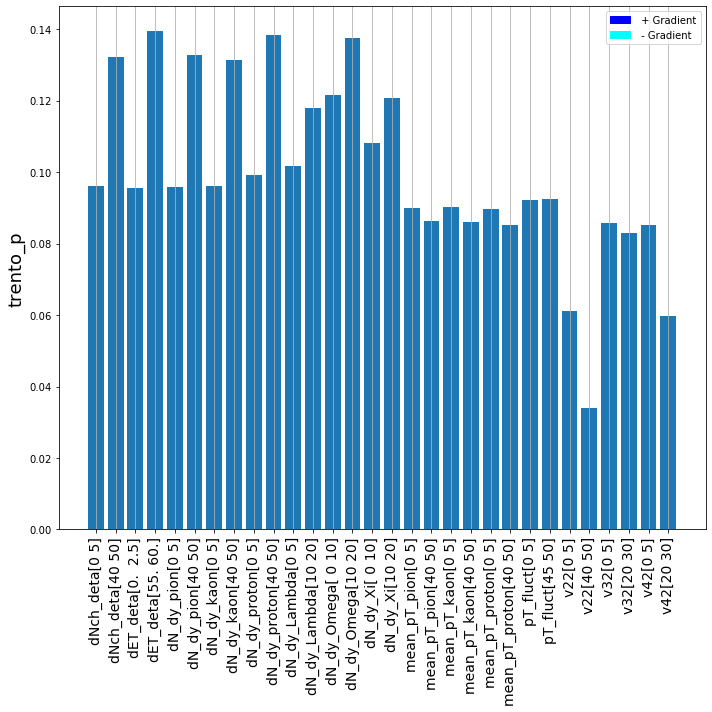

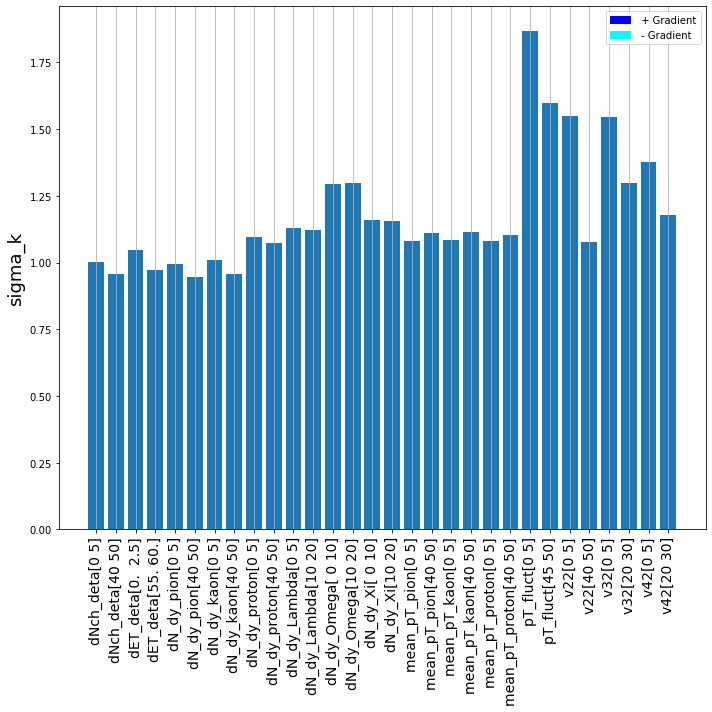

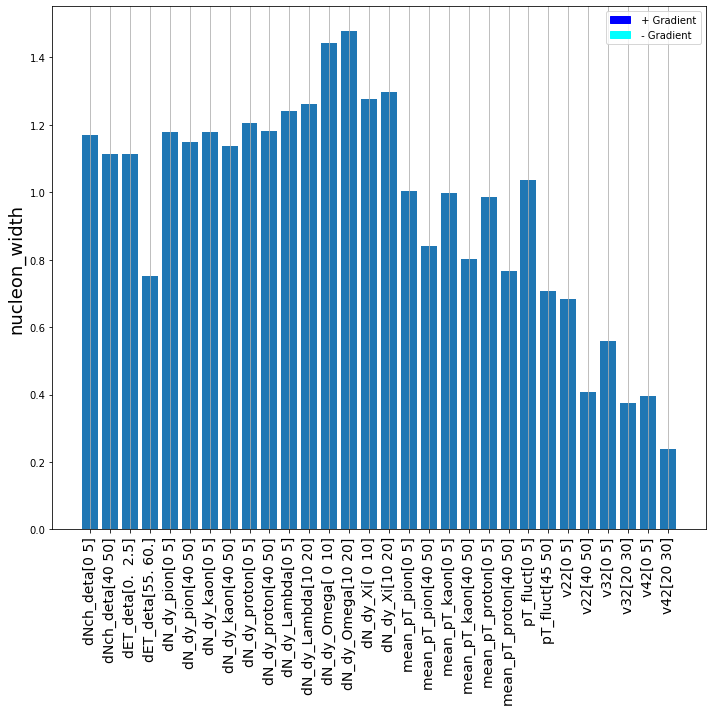

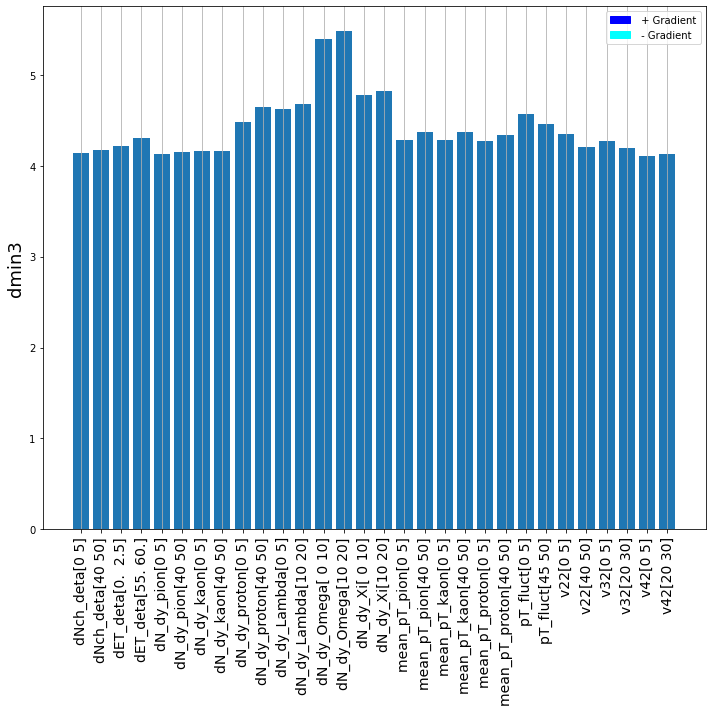

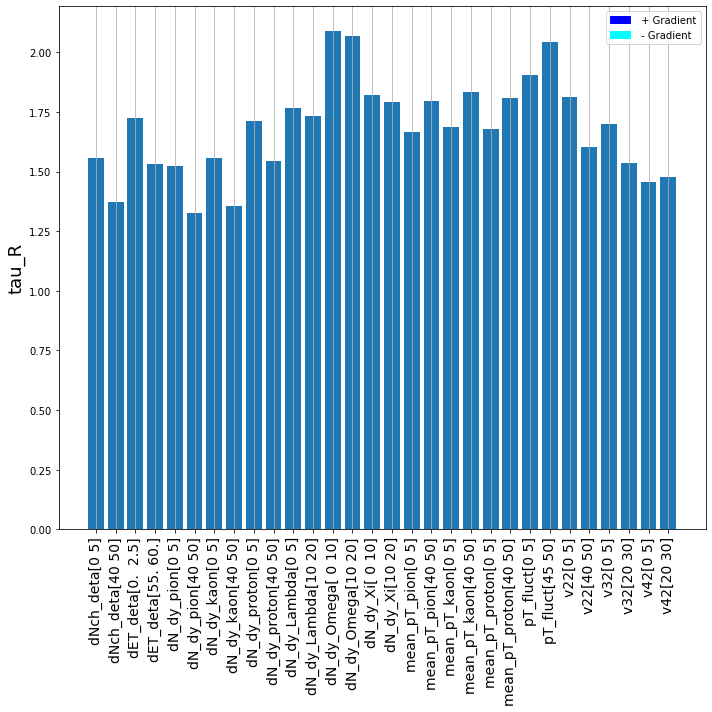

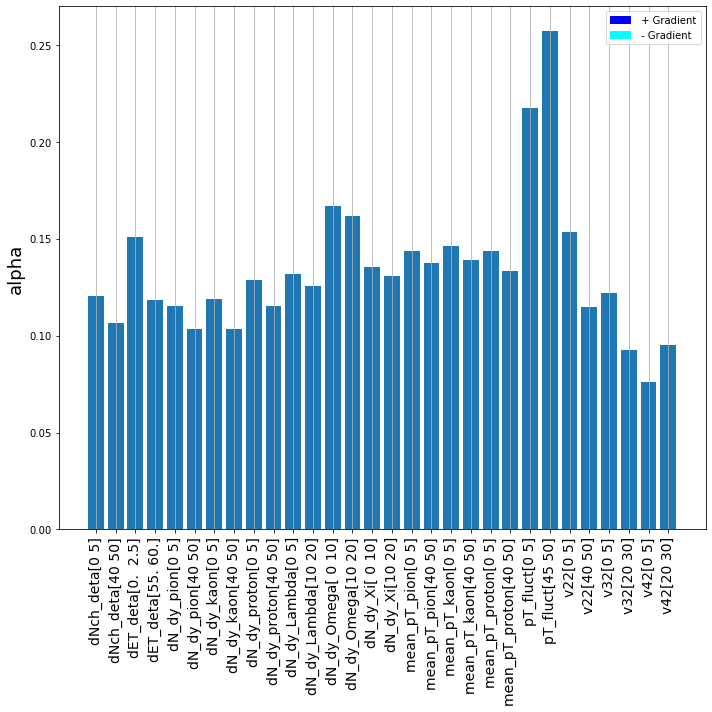

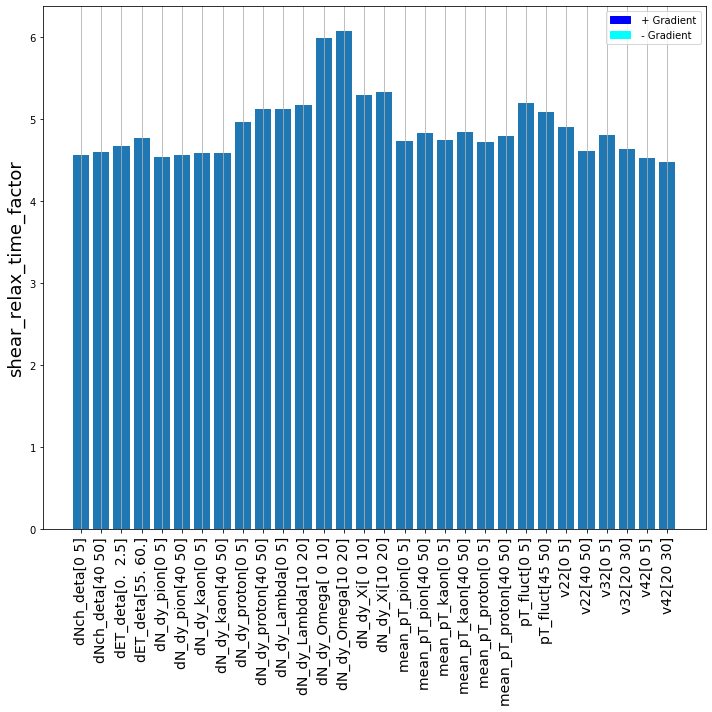

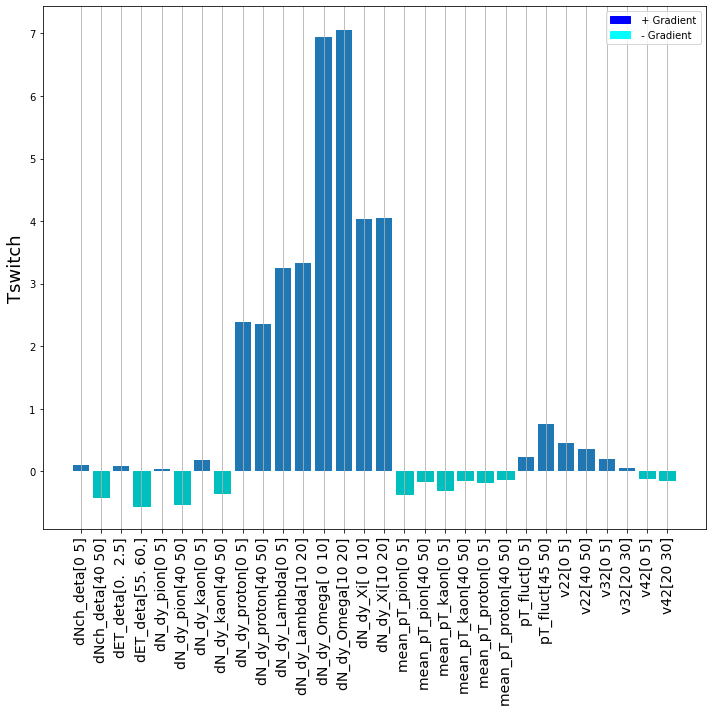

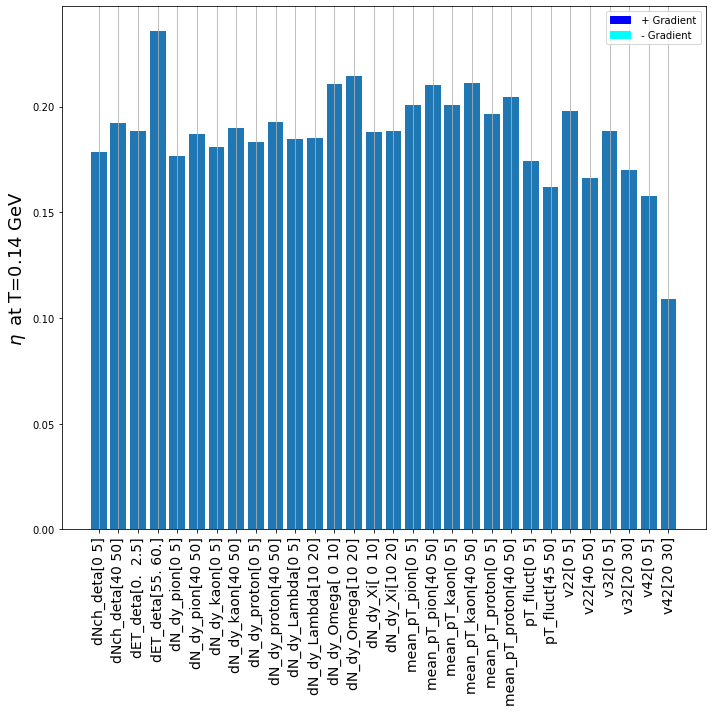

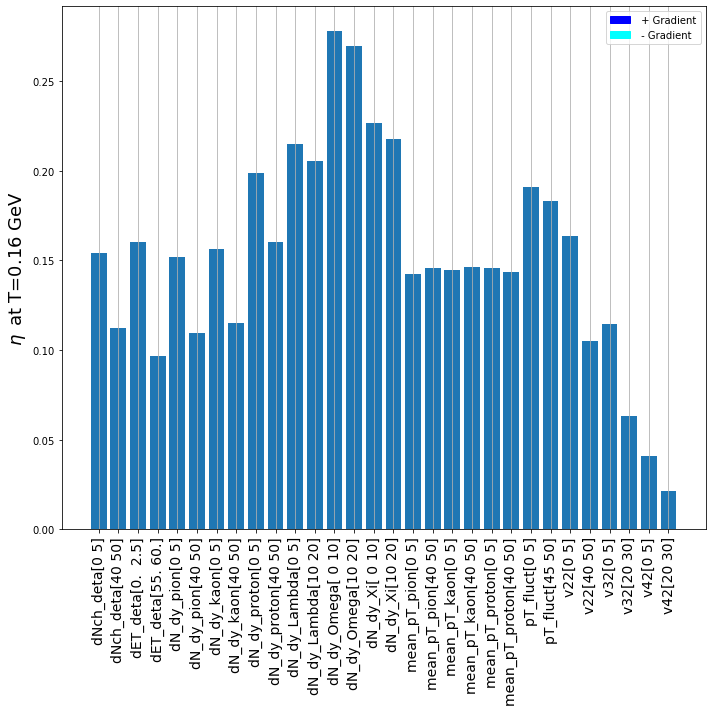

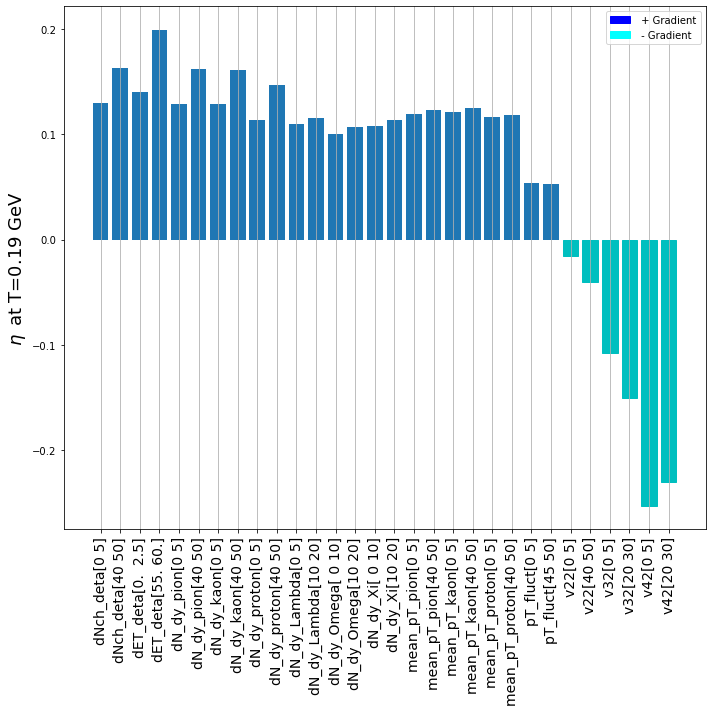

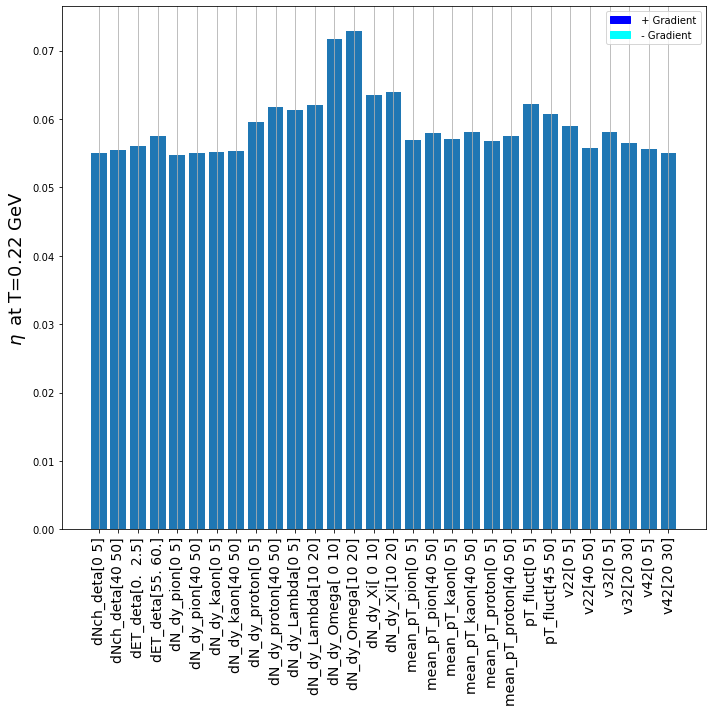

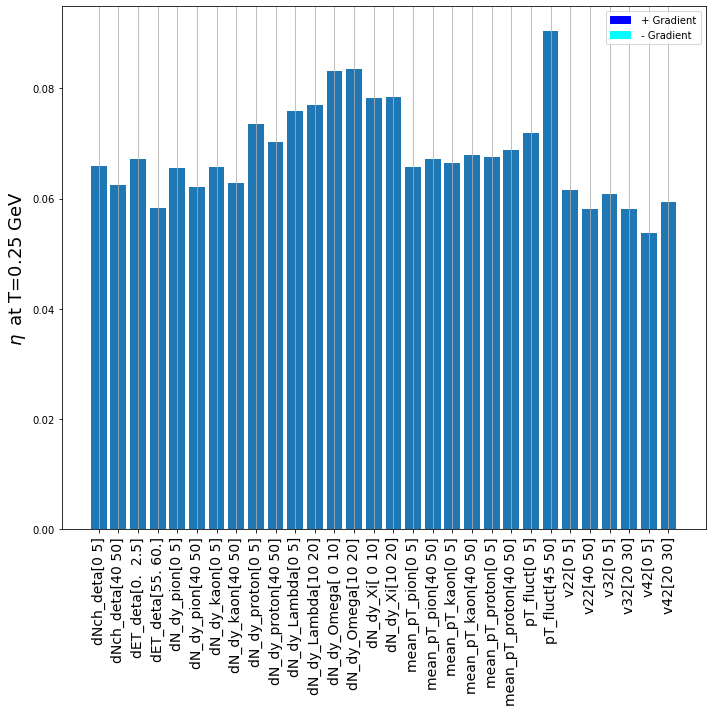

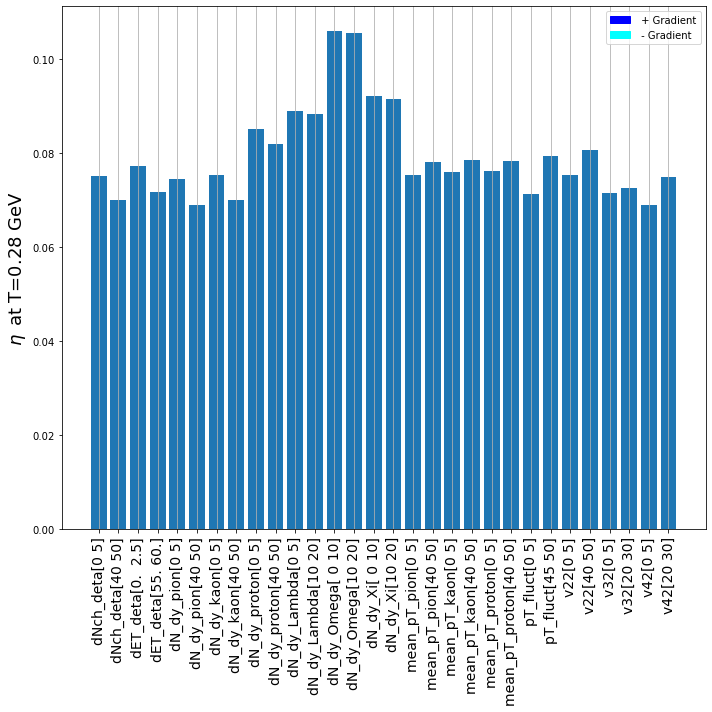

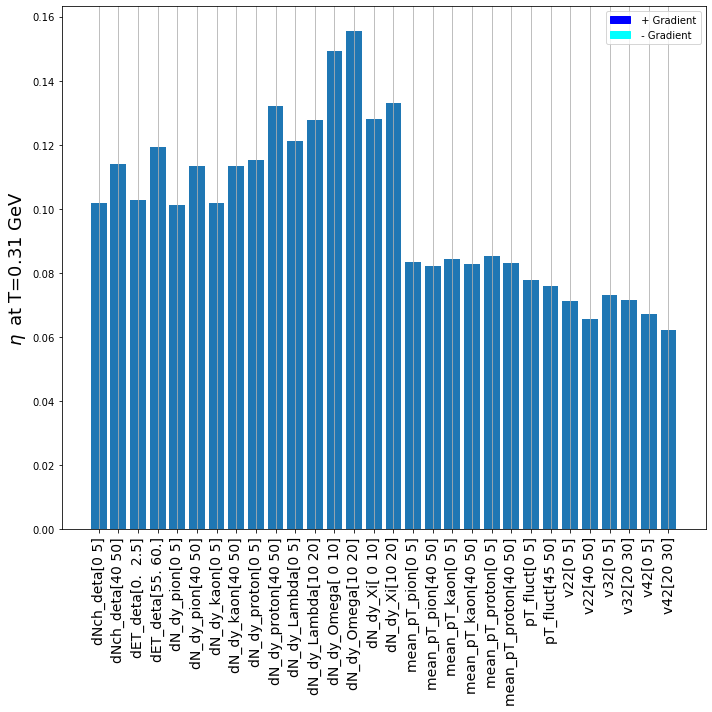

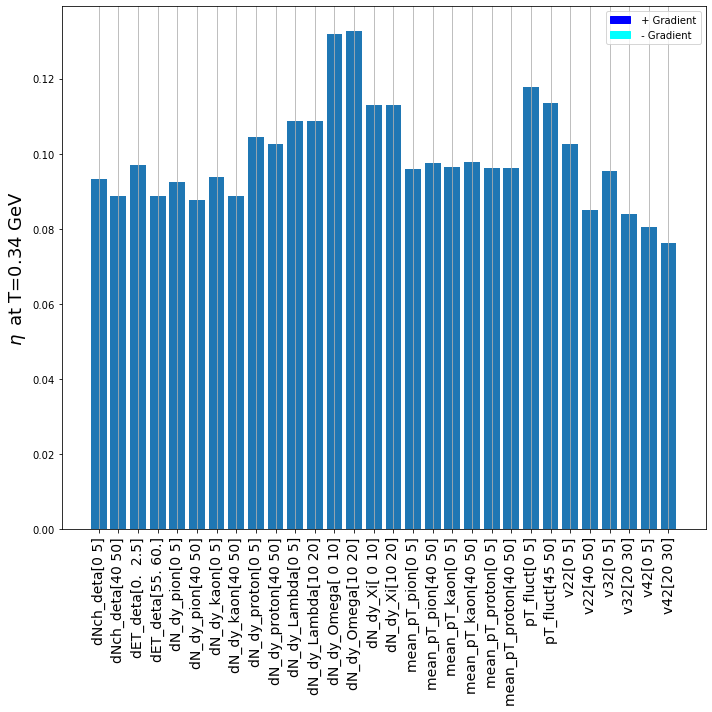

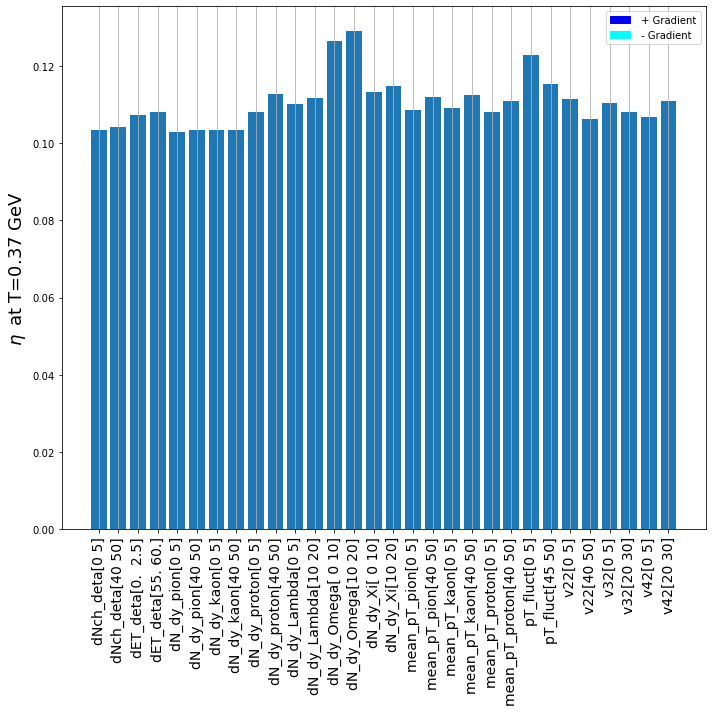

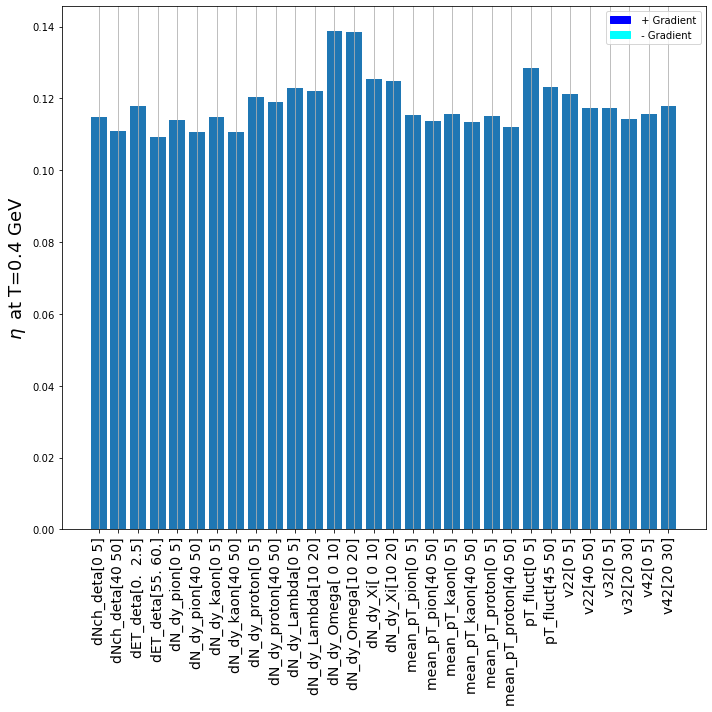

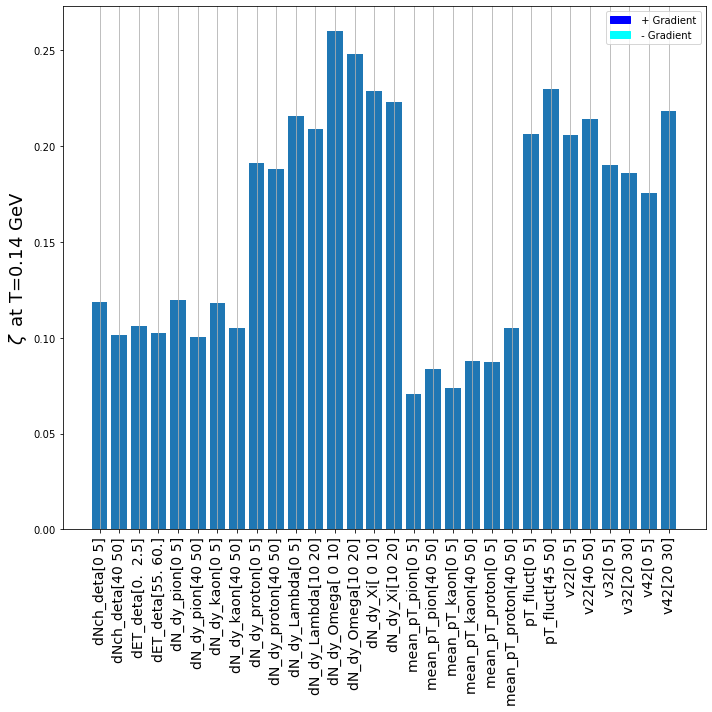

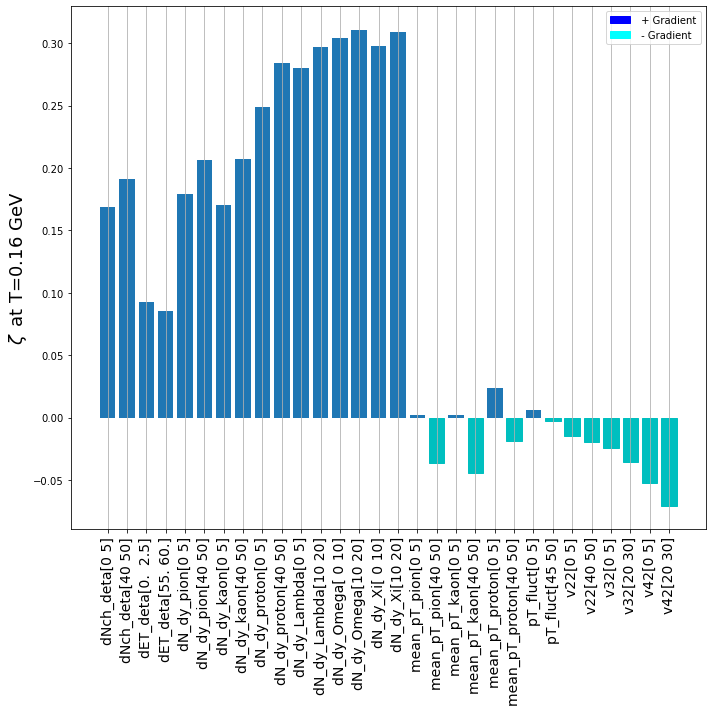

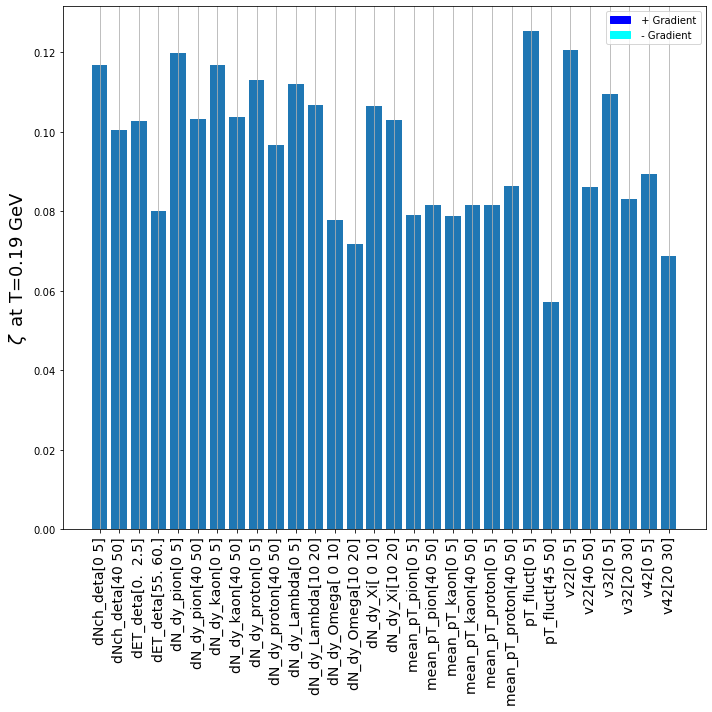

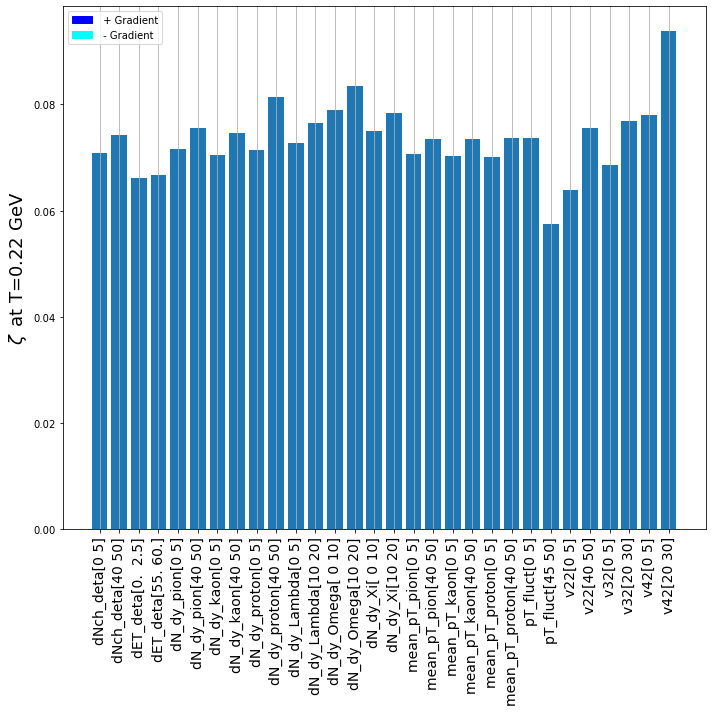

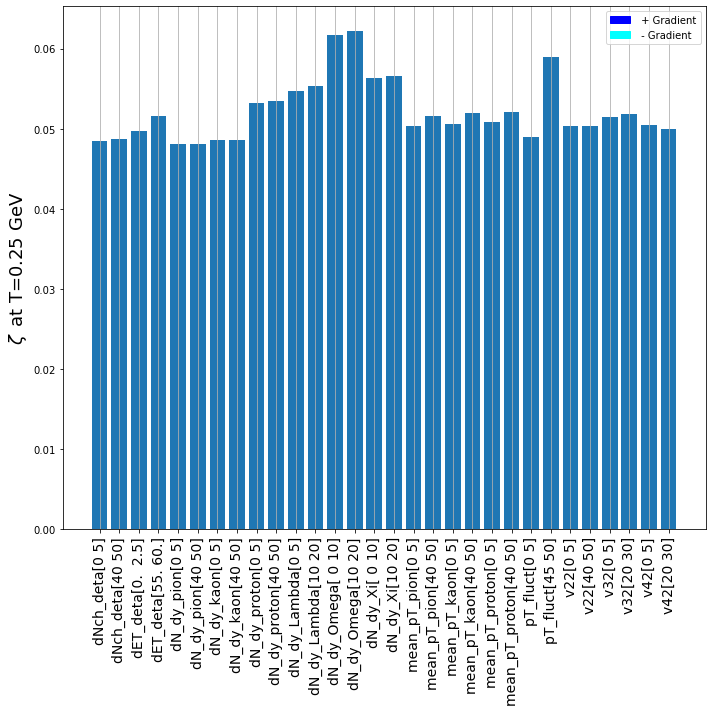

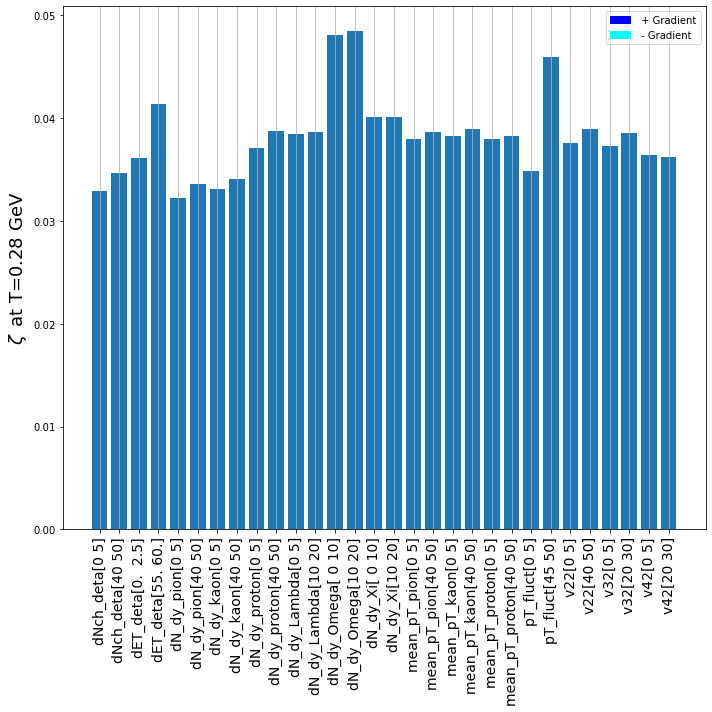

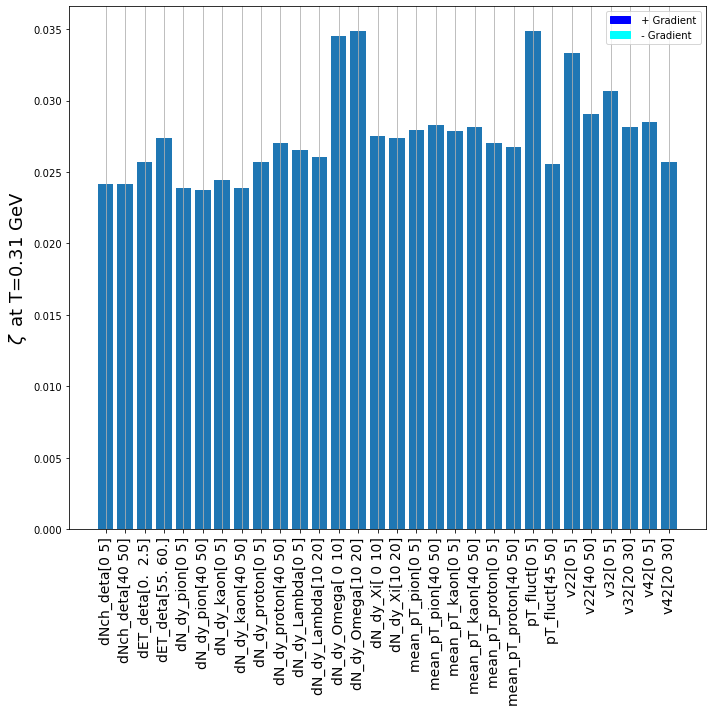

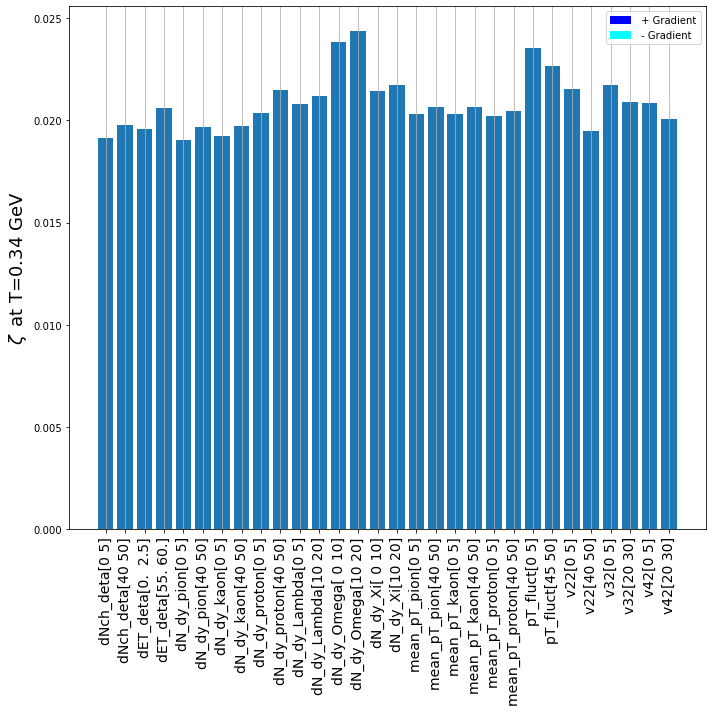

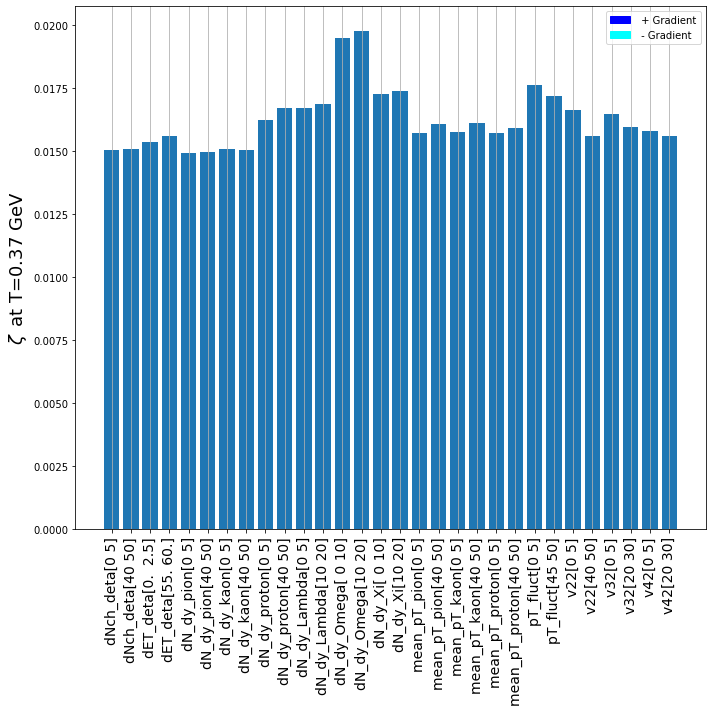

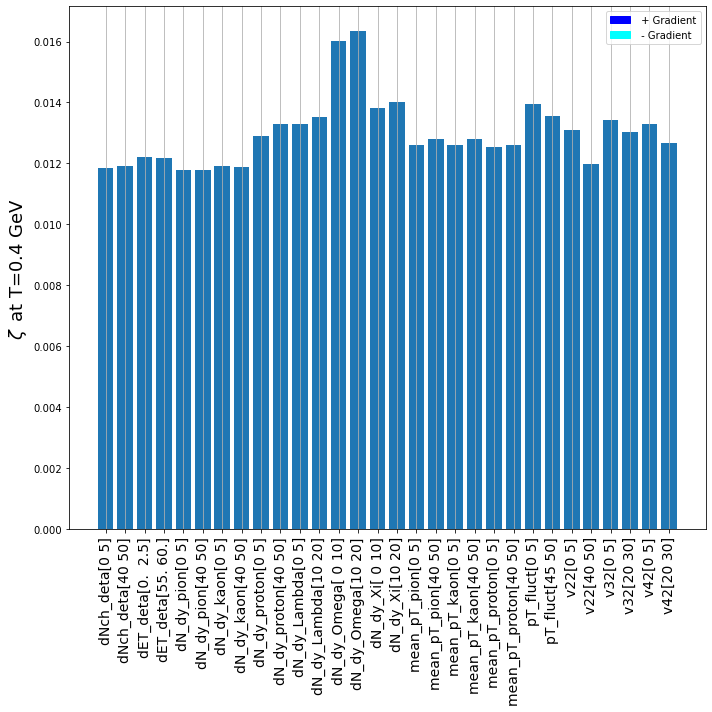

In [448]:
for i in range(0,29):
    sensitivity_plot_scott(40,i)

In [449]:
#Map_model_param_for_dim=MAP.reshape(29,) 
#MapObservabes=em._inverse_transform(Map_model_param_for_dim)

#Function where we specefy the observable.
# we will get a plot as a result showing how sensitive this observable for all centrality to all model parameters
#at MAp parameters
dicc=em._inverse_transform(grad_arry[2,:])
def sensitivity_plot_scott_with_error(centrality_begin,model_param):
    modelparam_Gradient=[]
    modelparam_Grad_sigma=[]
    MapObservabesUnits=[]
    sensitivity_list=[]
    sensitivity_error=[]
    X_values=[]
    X_name=[]
    temp_dic_all_grad=em._inverse_transform(grad_arry[model_param,:])
    temp_dic_all_var=em._inverse_transform(sigma_arry[model_param,:])
    fig,ax=plt.subplots(nrows=1, ncols=1, sharex=False ,figsize=(10, 10))
    specefic_cen_num=[]
    dic_keys=[key for _,key in enumerate(dicc.keys())]
    for i in dicc.keys():
       # print(grad_arry[i,:])
       # print(temp_dic_all_grad)
      #  modelparam_Gradient.append(temp_dic_all_grad[observable_name])
      #  modelparam_Grad_sigma.append(temp_dic_all_var[observable_name])
        centrality=obs_cent_list["Pb-Pb-2760"][i]
    #fig,axes=plt.subplots(nrows=2, ncols=1, sharex=False[=,figsize=(10, 10))
        n_cen=len(centrality)
    #brg= plt.get_cmap('brg')
    #colors = iter(brg(np.linspace(0,1,n_cen)))
    #print(X_values.shape)
    #X_values.reshape(29,)
    #print(n_cen)
    
        for j in range(0,n_cen):
            if centrality[j][0]== centrality_begin:
                #print(centrality[j][0])
                specefic_cen_num.append(j)
    #            MapObservabesUnits.append(MapObservabes[i][j])
    l=0
    for i,key in enumerate(dic_keys):

        sensitivity_list.append(temp_dic_all_grad[key][0])
        sensitivity_error.append(temp_dic_all_var[key][0])
        #print(temp_dic_all_grad[key][0])
        MapObservabesUnits.append(MapObservabes[key][0])
        X_values.append(2*l)
        X_name.append(dic_keys[i] + str(obs_cent_list["Pb-Pb-2760"][key][0]))
        sensitivity_list.append(temp_dic_all_grad[key][-3])
        sensitivity_error.append(temp_dic_all_var[key][-3])
        X_values.append(2*l+1)
        X_name.append(dic_keys[i] + str(obs_cent_list["Pb-Pb-2760"][key][-3]))
        l=l+1
        MapObservabesUnits.append(MapObservabes[key][-3])
   # print(MapObservabesUnits)
    #print(MapObservabesUnits)    
    #MapObservabesUnits=MapObservabesUnits+MapObservabesUnits
    #X_values=range(0,2*len(MapObservabesUnits))            
    #sensitivity_list_1=[grad_cent_arry[0] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list_2=[grad_cent_arry[-1] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list=sensitivity_list_1+sensitivity_list_2

    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #print(len(X_values))
    #print(len(sensitivity_list))
        #sensitivity_list=np.array(sensitivity_list)
        #sensitivity_error=np.array(sensitivity_error)
    sensitivity_list=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_list)]).flatten()
    sensitivity_error=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_error)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_error)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_error)]).flatten()
       # print(sensitivity_list)
       # print("error")
       # print(sensitivity_error)
                                   
        #print(f'length of sens {sensitivity_list.shape} and length of error {sensitivity_error.shape}')
        #ax.plot(X_values,sensitivity_list)
        #print(sensitivity_list)
       # print("error next")
       # print(sensitivity_error)
        #ax.errorbar(X_values,sensitivity_list,yerr=sensitivity_error,fmt='o',ecolor='r')
    positives= sensitivity_list>0
       # negatives= sensitivity_list<0
       # ax.scatter(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5 , s= 200 , label= centrality[j],color=next(colors))
       # ax.plot(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5, label= centrality[j],color=next(colors))
   # barlist=ax.bar(X_values,np.log(abs(sensitivity_list)))#,yerr=sensitivity_error)
    barlist=ax.bar(X_values,sensitivity_list,yerr=sensitivity_error, ecolor='r', capsize=3)
    for j,difference in enumerate(positives):
        if difference==False:
            barlist[j].set_color('c')  
       # ax.scatter(X_values[negatives],np.log(abs(sensitivity_list[negatives])), marker='x' , alpha=0.5 , s =200, label= centrality[j] , cmpa= 'PiYG' )
    ax.set_ylabel(all_model_labels[model_param],fontsize=18)
    ax.grid(b=True,axis='x')
    #ax.set_xticks(X_values) 
    plt.xticks(X_values,X_name)
    #plt.xlabel(f'Observables',fontsize=14)
    plt.xticks(rotation='vertical',fontsize=14)
    #plt.legend()
   # plt.ylabel('Varied Observable',fontsize=18)
    plt.tight_layout()
    blue_patch = mpatches.Patch(color='blue', label=' + Gradient')
    cyan_patch = mpatches.Patch(color='cyan', label=' - Gradient')
    plt.legend(handles=[blue_patch, cyan_patch])
    #plt.title("Gradients")
    plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/sensitivity/with_error/sensitivity_{model_param}.png',dpi=100)
    plt.show()

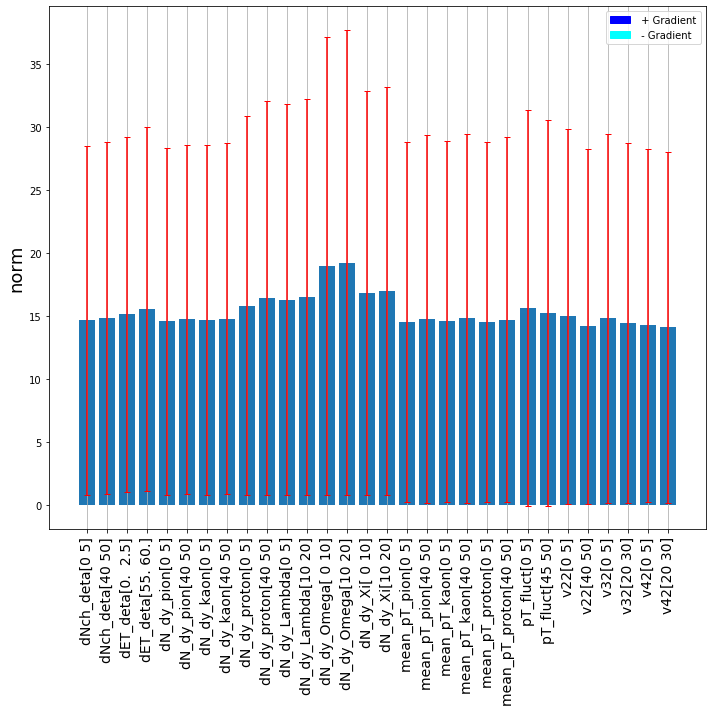

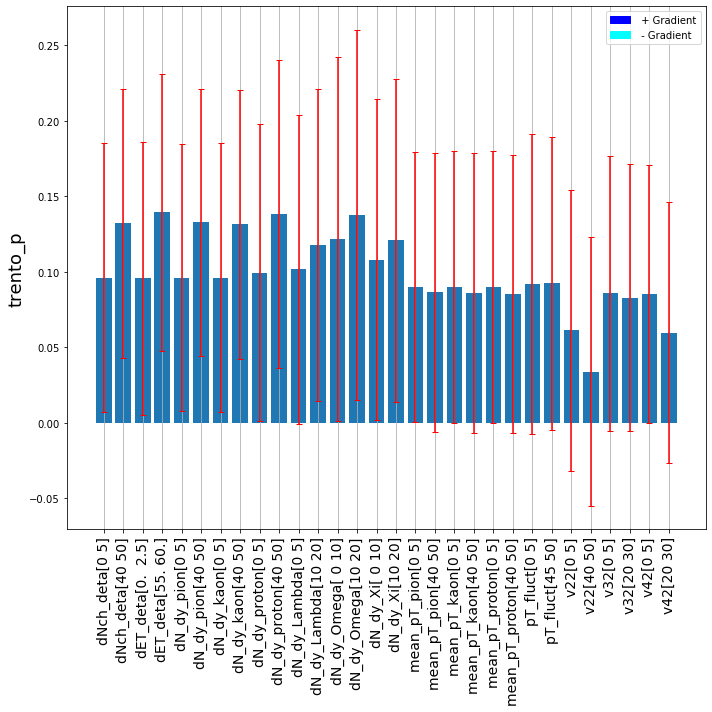

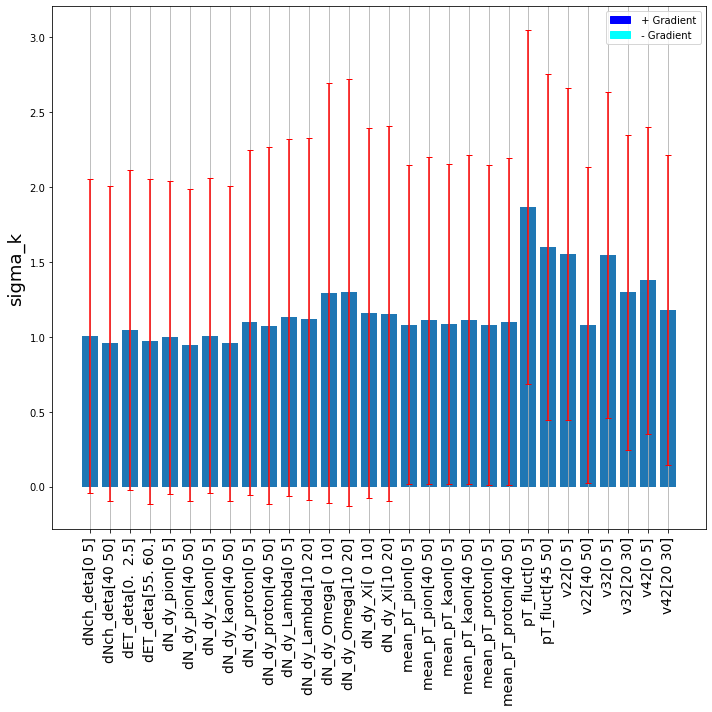

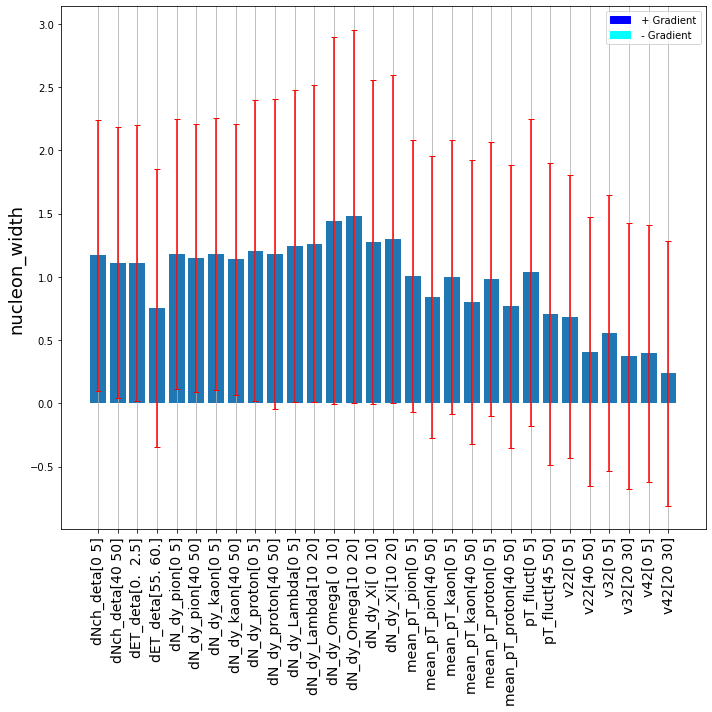

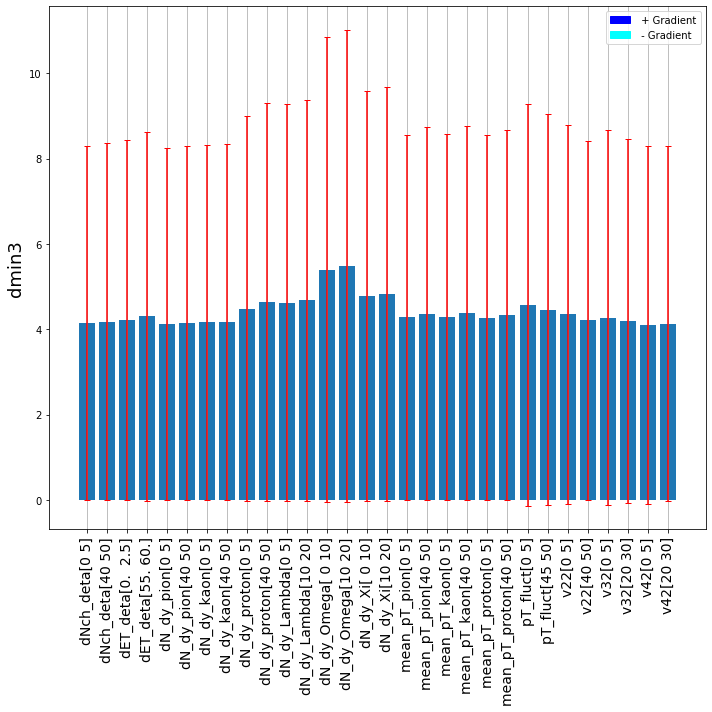

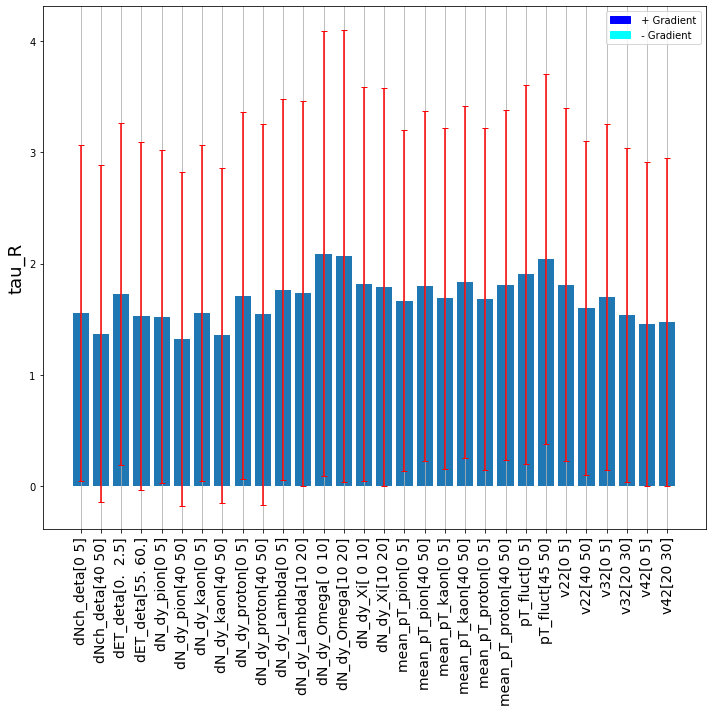

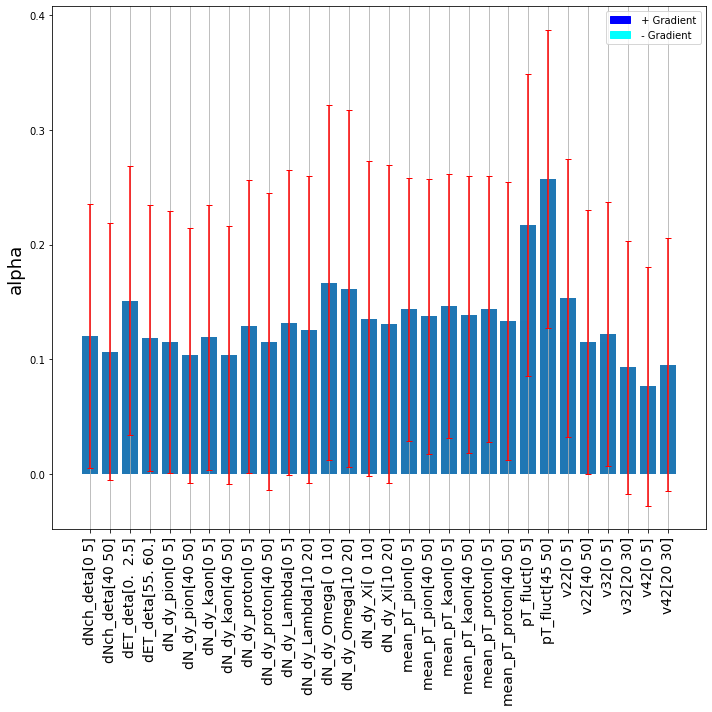

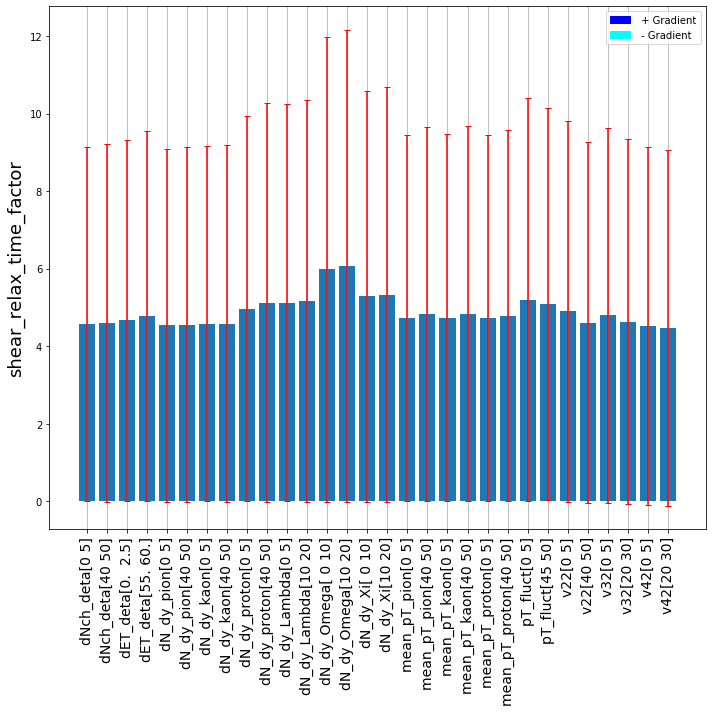

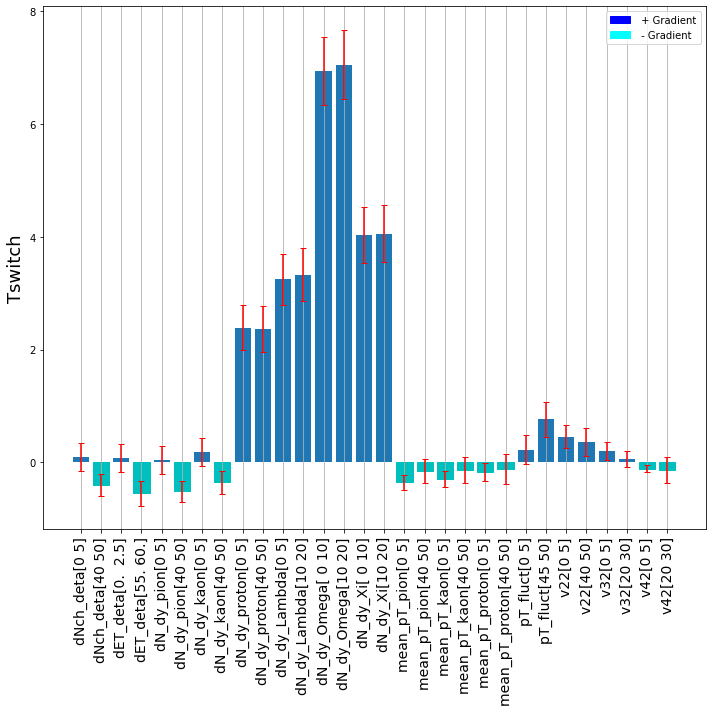

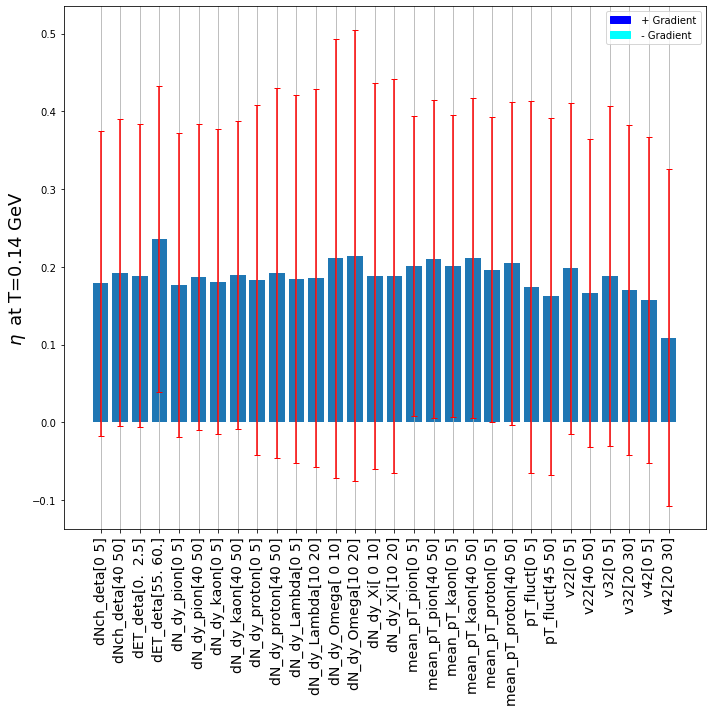

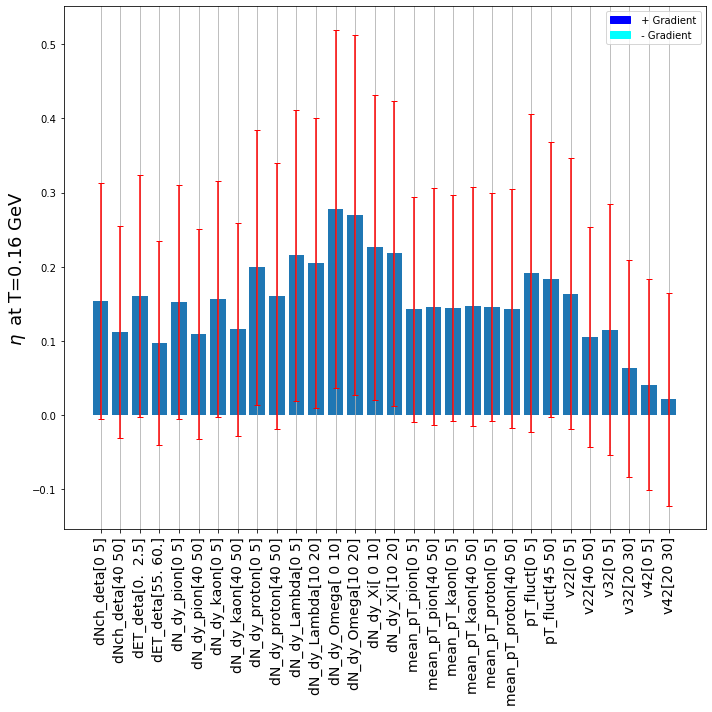

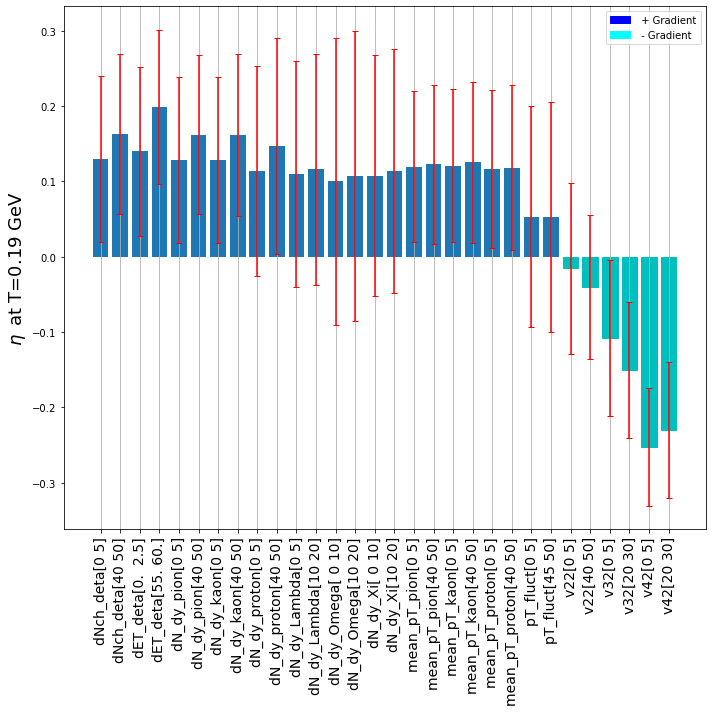

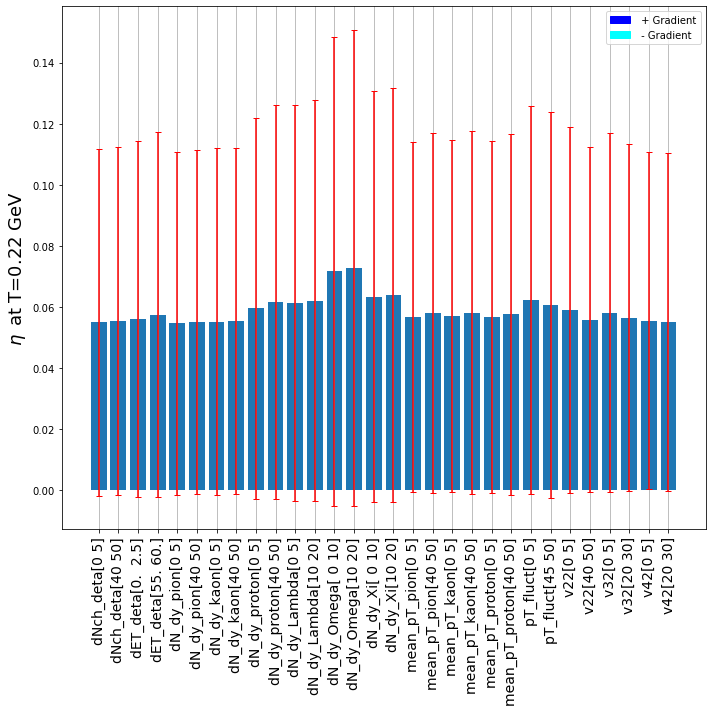

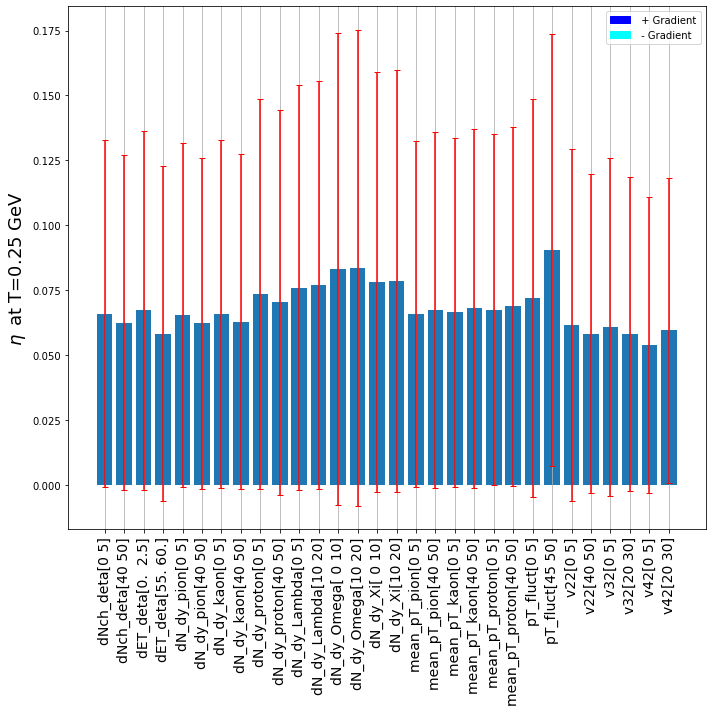

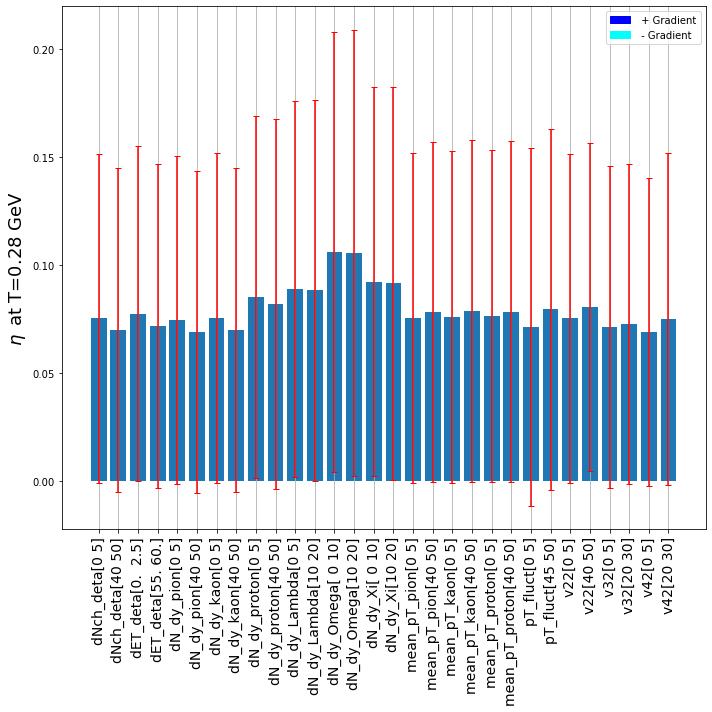

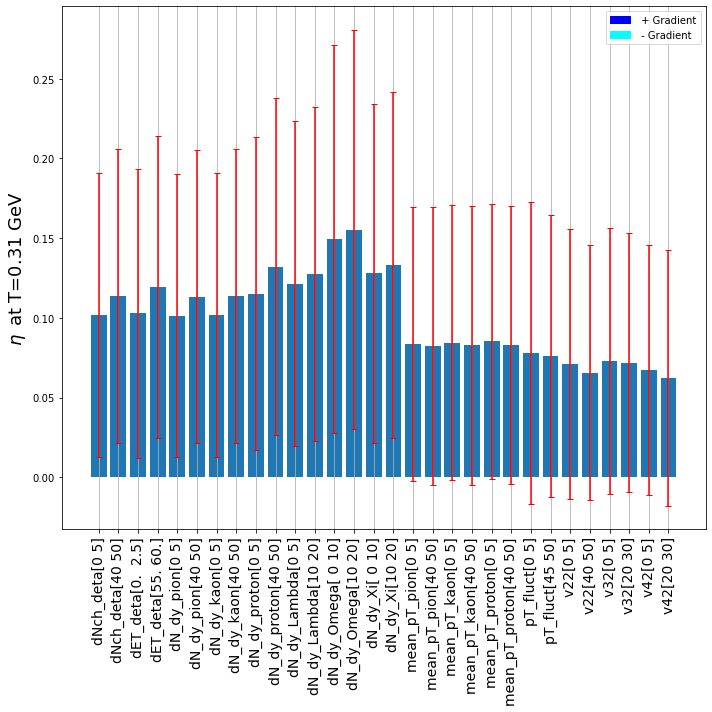

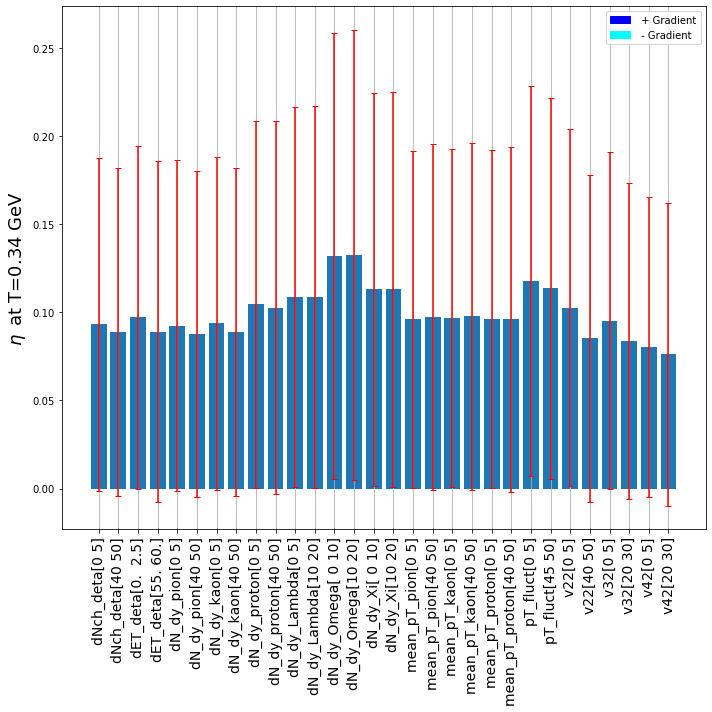

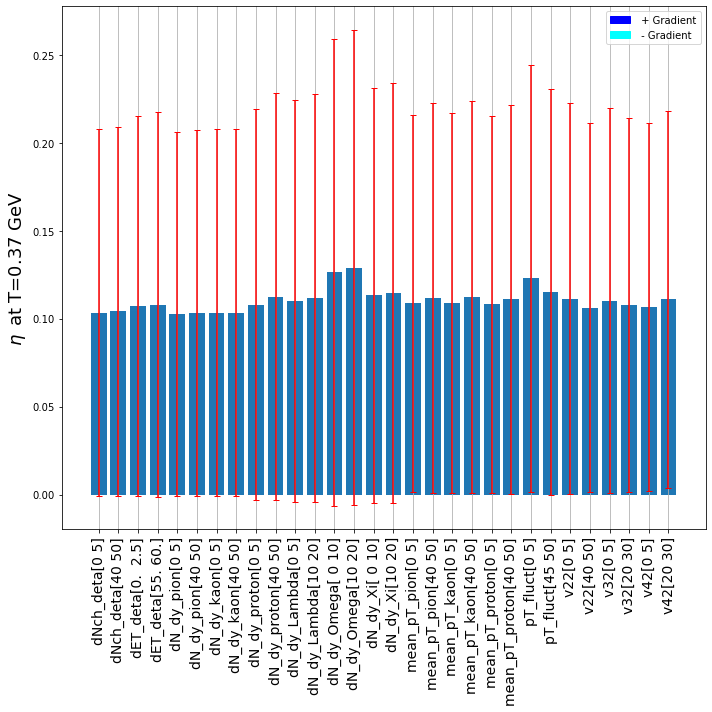

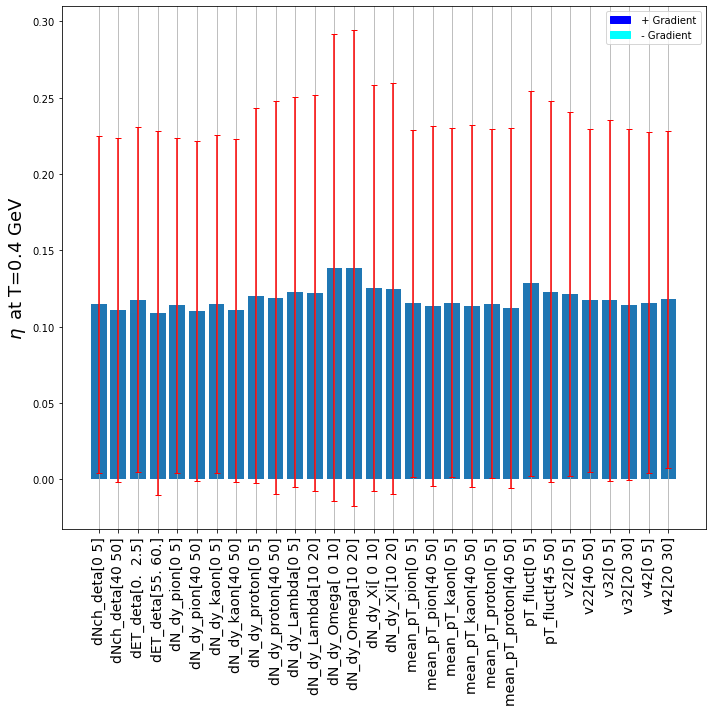

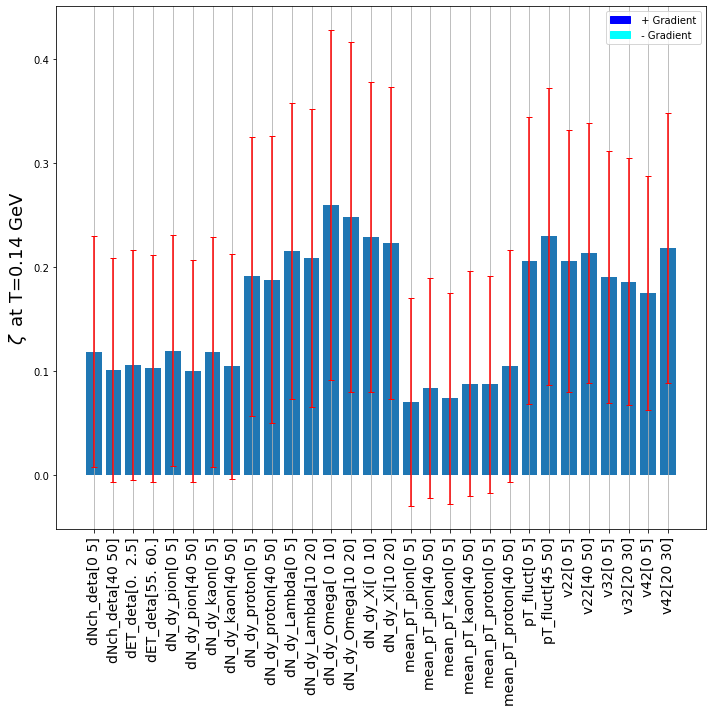

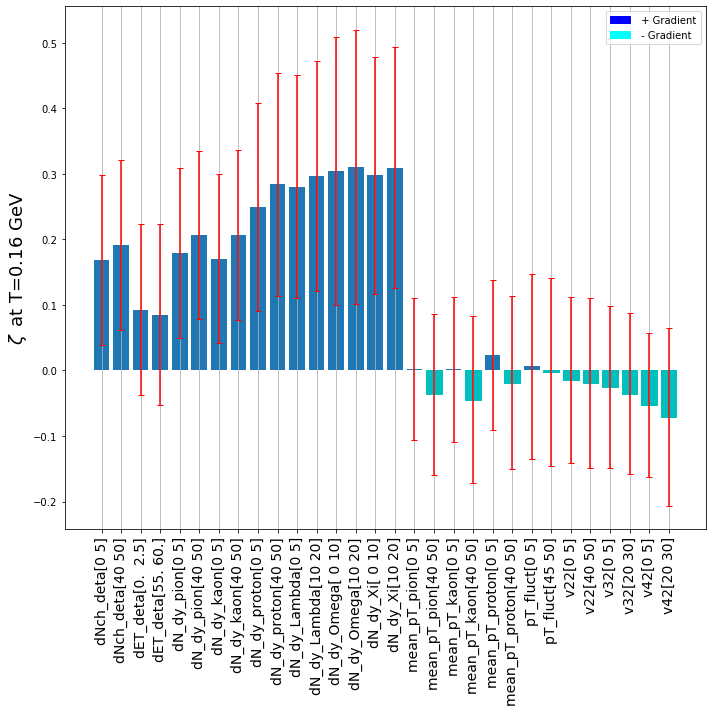

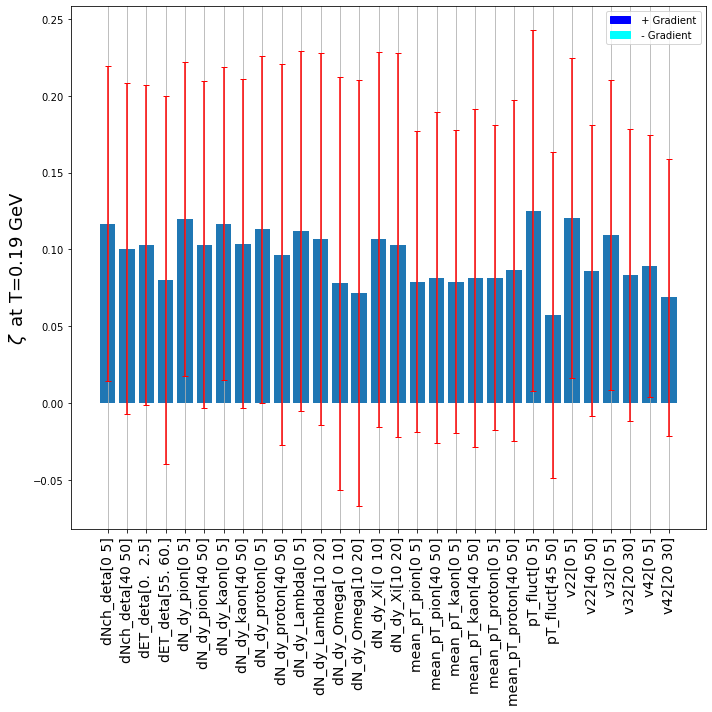

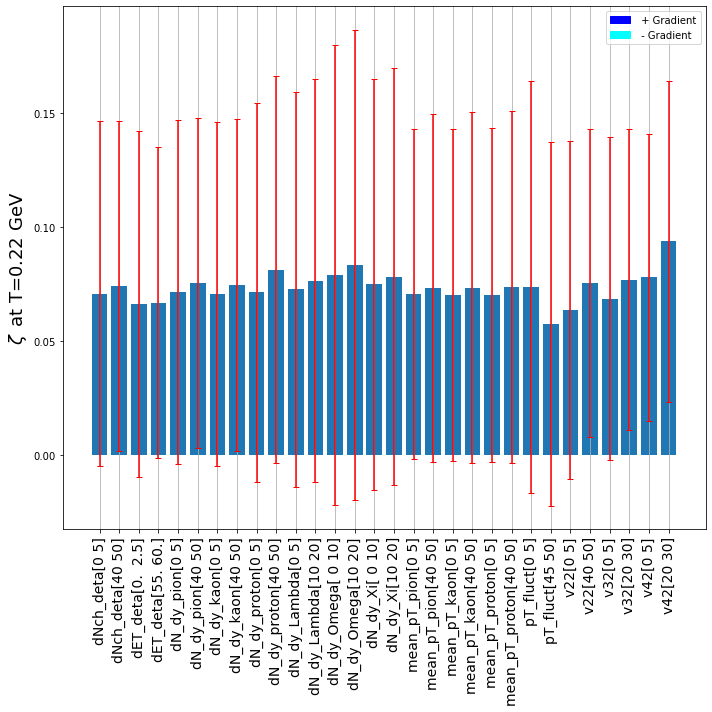

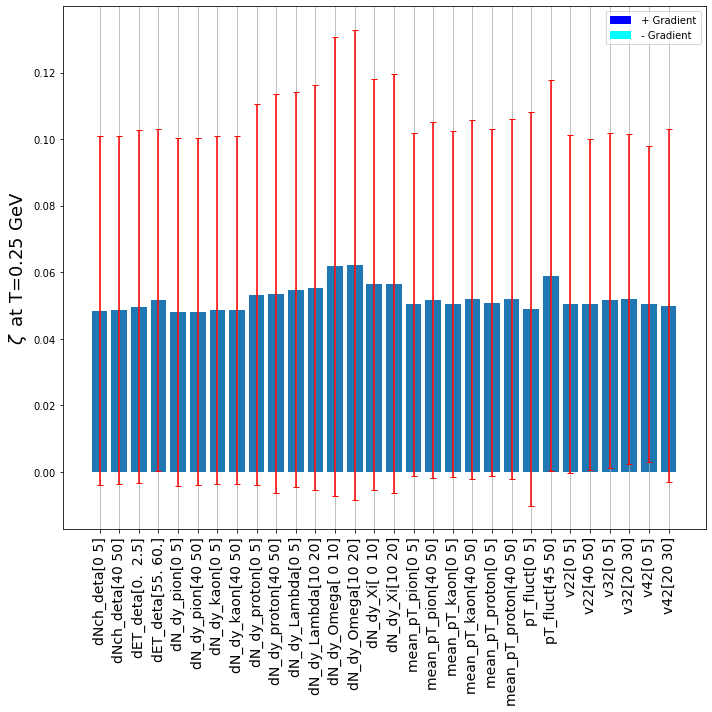

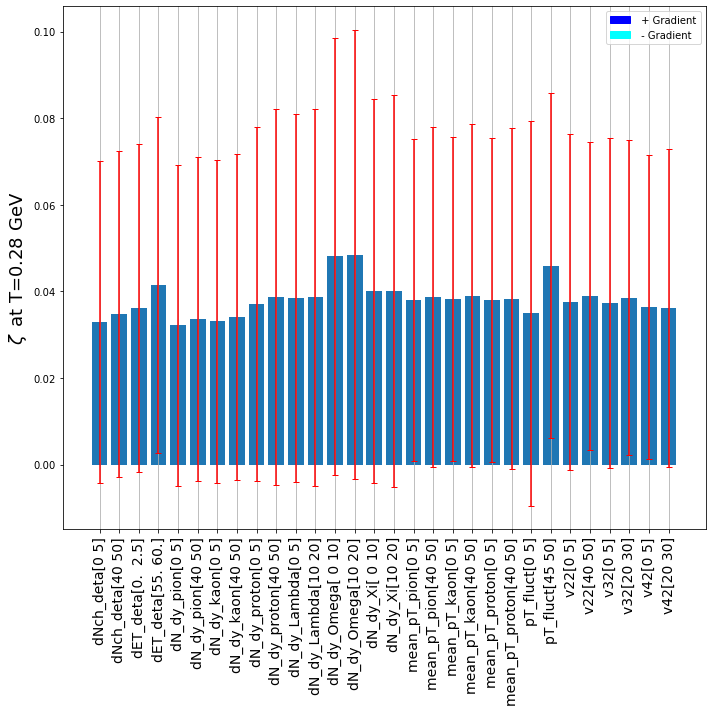

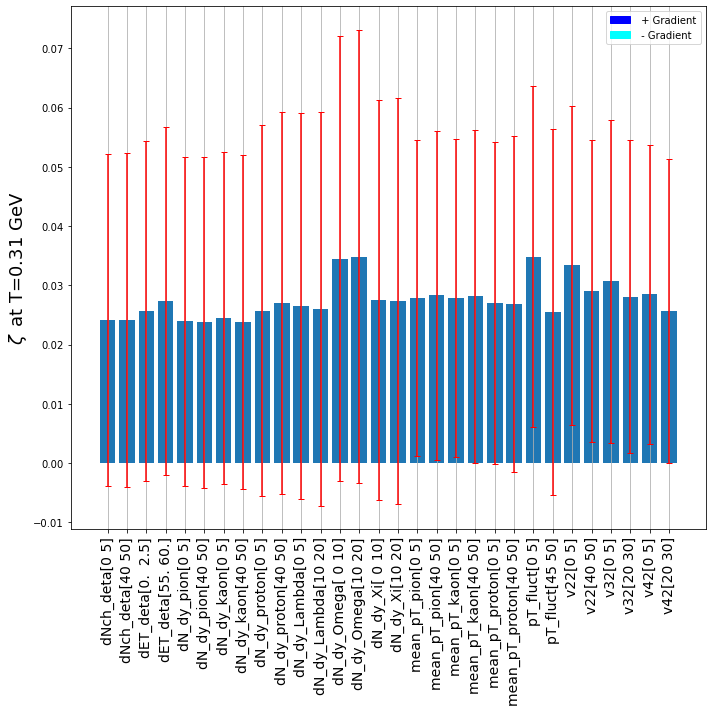

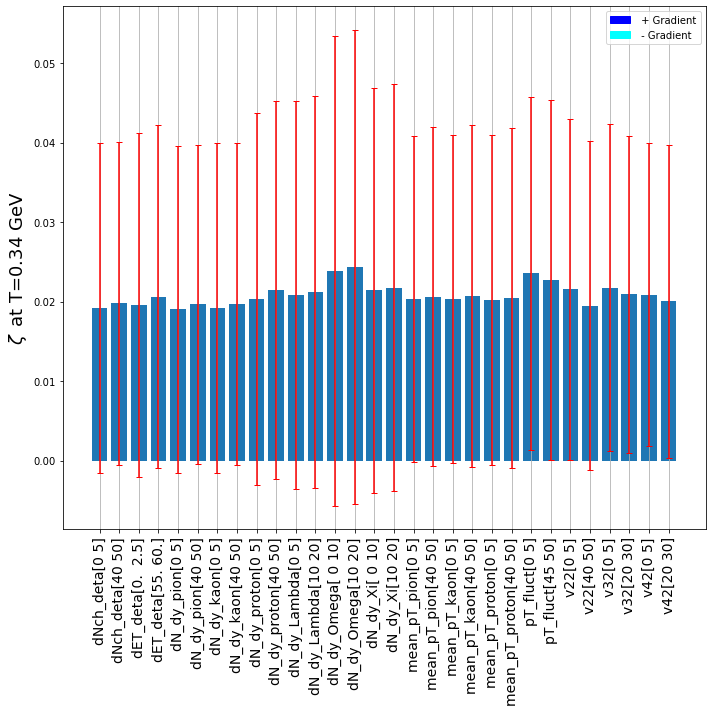

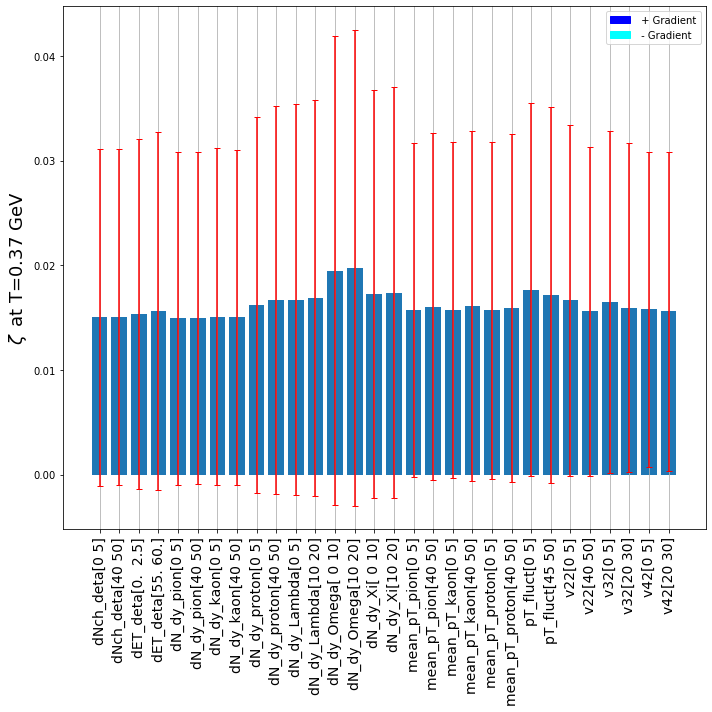

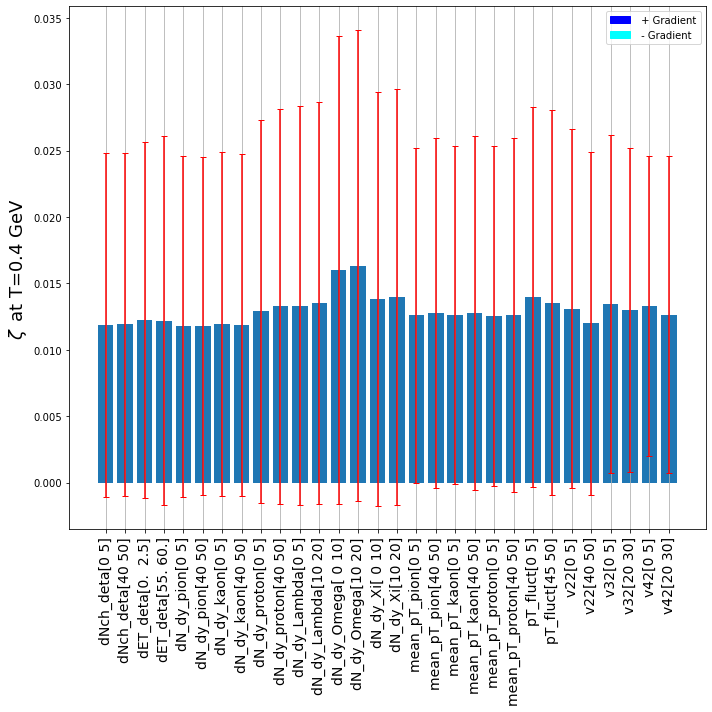

In [450]:
for i in range(0,29):
    sensitivity_plot_scott_with_error(40,i)

In [451]:
#Function where we specefy the observable.
# we will get a plot as a result showing how sensitive this observable for all centrality to all model parameters
#at MAp parameters


dicc=em._inverse_transform(grad_arry[2,:])

def sensitivity_plot_scott_grouped(centrality_begin,model_param):
    width = 0.35  # the width of the bars
    modelparam_Gradient=[]
    modelparam_Grad_sigma=[]
    MapObservabesUnits_1=[]
    MapObservabesUnits_2=[]
    sensitivity_list_1=[]
    sensitivity_list_2=[]


    X_values=[]
    X_name=[]
    label_1=[]
    label_2=[]
    temp_dic_all_grad=em._inverse_transform(grad_arry[model_param,:])
    temp_dic_all_var=em._inverse_transform(sigma_arry[model_param,:])
    fig,ax=plt.subplots(nrows=1, ncols=1, sharex=False ,figsize=(10, 10))
    specefic_cen_num=[]
    dic_keys=[key for _,key in enumerate(dicc.keys())]
    for i in dicc.keys():
       # print(grad_arry[i,:])
       # print(temp_dic_all_grad)
      #  modelparam_Gradient.append(temp_dic_all_grad[observable_name])
      #  modelparam_Grad_sigma.append(temp_dic_all_var[observable_name])
        centrality=obs_cent_list["Pb-Pb-2760"][i]
    #fig,axes=plt.subplots(nrows=2, ncols=1, sharex=False ,figsize=(10, 10))
        n_cen=len(centrality)
    #brg= plt.get_cmap('brg')
    #colors = iter(brg(np.linspace(0,1,n_cen)))
    #print(X_values.shape)
    #X_values.reshape(29,)
    #print(n_cen)
    
        for j in range(0,n_cen):
            if centrality[j][0]== centrality_begin:
                #print(centrality[j][0])
                specefic_cen_num.append(j)
    #            MapObservabesUnits.append(MapObservabes[i][j])
    l=0
    for i,key in enumerate(dic_keys):

        sensitivity_list_1.append(temp_dic_all_grad[key][0])
        #print(temp_dic_all_grad[key][0])
        MapObservabesUnits_1.append(MapObservabes[key][0])
      #  X_values.append(2*l)
        X_name.append(dic_keys[i])
        label_1.append(str(obs_cent_list["Pb-Pb-2760"][key][0]))
        sensitivity_list_2.append(temp_dic_all_grad[key][-3])
       # X_values.append(2*l+1)
       # X_name.append(dic_keys[i] + str(obs_cent_list["Pb-Pb-2760"][key][-3]))
        label_2.append(str(obs_cent_list["Pb-Pb-2760"][key][-3]))
        l=l+1
        MapObservabesUnits_2.append(MapObservabes[key][0])
   # print(MapObservabesUnits)
    #print(MapObservabesUnits)    
    #MapObservabesUnits=MapObservabesUnits+MapObservabesUnits
    X_values=np.arange(len(MapObservabesUnits_1))            
    #sensitivity_list_1=[grad_cent_arry[0] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list_2=[grad_cent_arry[-1] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list=sensitivity_list_1+sensitivity_list_2

    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #print(len(X_values))
    #print(len(sensitivity_list))
        #sensitivity_list=np.array(sensitivity_list)
        #sensitivity_error=np.array(sensitivity_error)
    sensitivity_list_1=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_1[i]) for i,values in enumerate(sensitivity_list_1)]).flatten()
    sensitivity_list_2=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_2[i]) for i,values in enumerate(sensitivity_list_2)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_error)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_error)]).flatten()
       # print(sensitivity_list)
       # print("error")
       # print(sensitivity_error)
                                   
        #print(f'length of sens {sensitivity_list.shape} and length of error {sensitivity_error.shape}')
        #ax.plot(X_values,sensitivity_list)
        #print(sensitivity_list)
       # print("error next")
       # print(sensitivity_error)
        #ax.errorbar(X_values,sensitivity_list,yerr=sensitivity_error,fmt='o',ecolor='r')
   # positives= sensitivity_list>0
       # negatives= sensitivity_list<0
       # ax.scatter(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5 , s= 200 , label= centrality[j],color=next(colors))
       # ax.plot(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5, label= centrality[j],color=next(colors))
   # barlist=ax.bar(X_values,np.log(abs(sensitivity_list)))#,yerr=sensitivity_error)
   # barlist=ax.bar(X_values,sensitivity_list)#,yerr=sensitivity_error)

    rects1 = ax.bar(X_values - width/2, sensitivity_list_1, width, label='Low centrality')
    rects2 = ax.bar(X_values + width/2, sensitivity_list_2, width, label='High centrality')

    
   # for j,difference in enumerate(positives):
    #    if difference==False:
     #       barlist[j].set_color('c')  
       # ax.scatter(X_values[negatives],np.log(abs(sensitivity_list[negatives])), marker='x' , alpha=0.5 , s =200, label= centrality[j] , cmpa= 'PiYG' )
    ax.set_ylabel(all_model_labels[model_param],fontsize=18)
    ax.grid(b=True,axis='x')
    #ax.set_xticks(X_values) 
    ax.set_xticks(X_values)
    ax.set_xticklabels(X_name)
    #plt.xticks(X_values,X_name)
    #plt.xlabel(f'Observables',fontsize=18)
    plt.xticks(rotation='vertical',fontsize=14)
    #plt.legend()
   # plt.ylabel('Varied Observable',fontsize=18)
   # plt.tight_layout()
  #  blue_patch = mpatches.Patch(color='blue', label=' + Gradient')
  #  cyan_patch = mpatches.Patch(color='cyan', label=' - Gradient')
  #  plt.legend(handles=[blue_patch, cyan_patch])
    def autolabel(rects,labels):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for i,rect in enumerate(rects):
            height = rect.get_height()
            if height<0:
                va='top'
                space=40
            else:
                va='bottom'
                space=-40
            ax.annotate(labels[i],
                   # xy=(rect.get_x() + rect.get_width() / 2, height),
                    xy=(rect.get_x() + rect.get_width() / 2, 0),
                    xytext=(0,space),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va=va,rotation='90')
    plt.legend()
    autolabel(rects1,label_1)
    autolabel(rects2,label_2)
    #plt.title("Gradients")
    plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/sensitivity/without_error/sensitivity_{model_param}.png',dpi=100)
    plt.show()

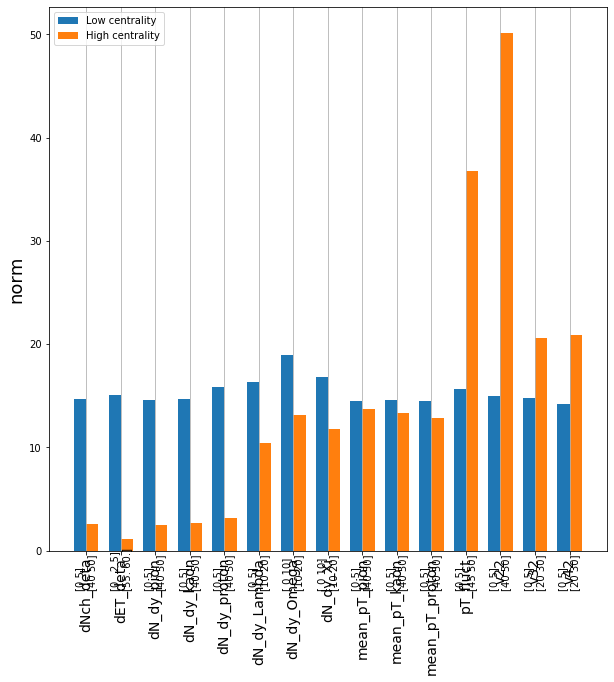

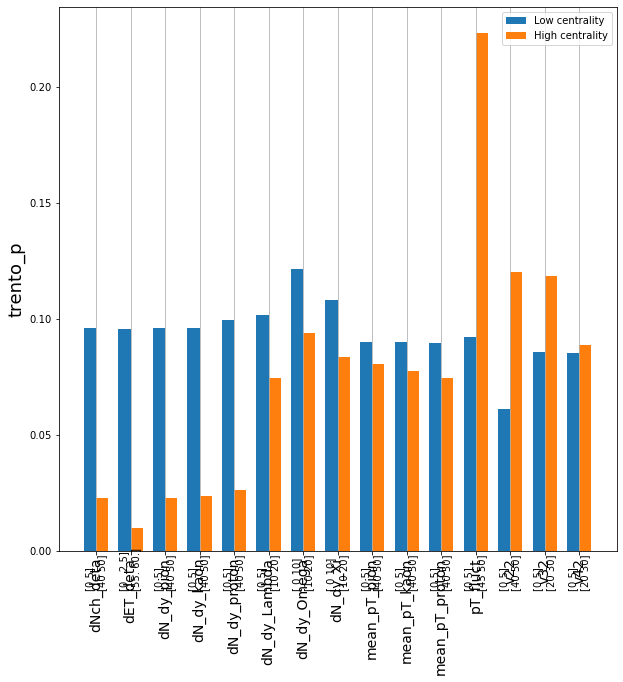

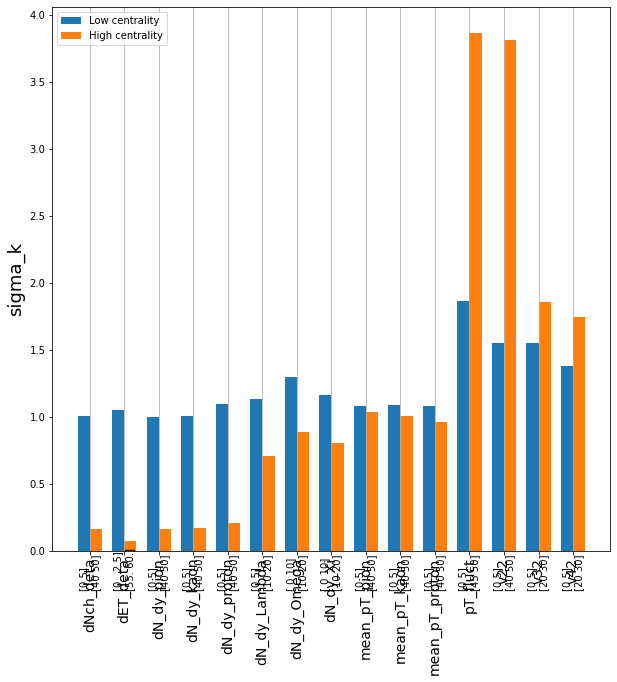

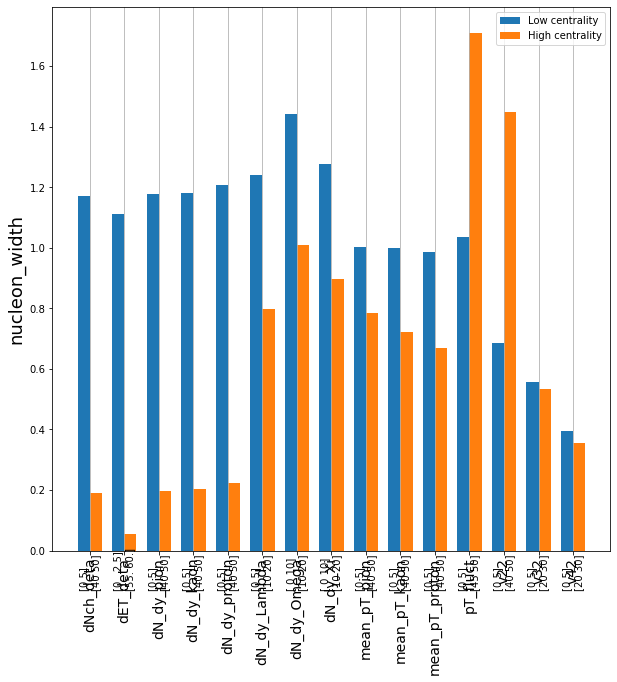

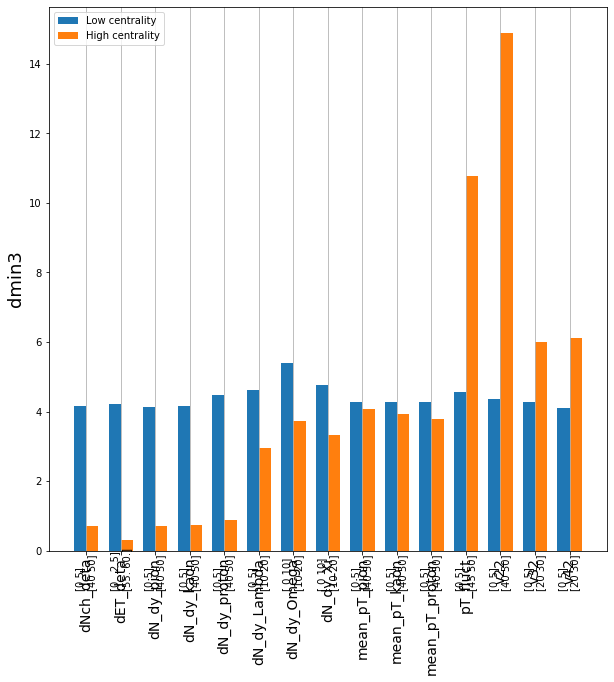

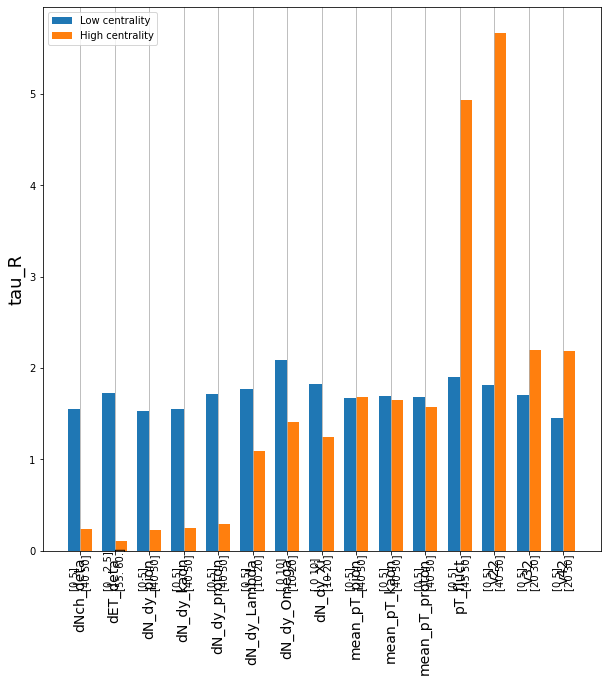

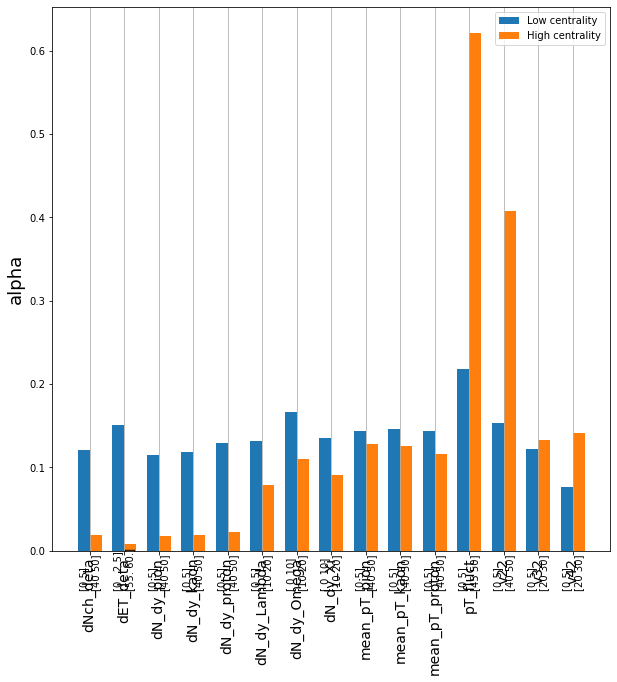

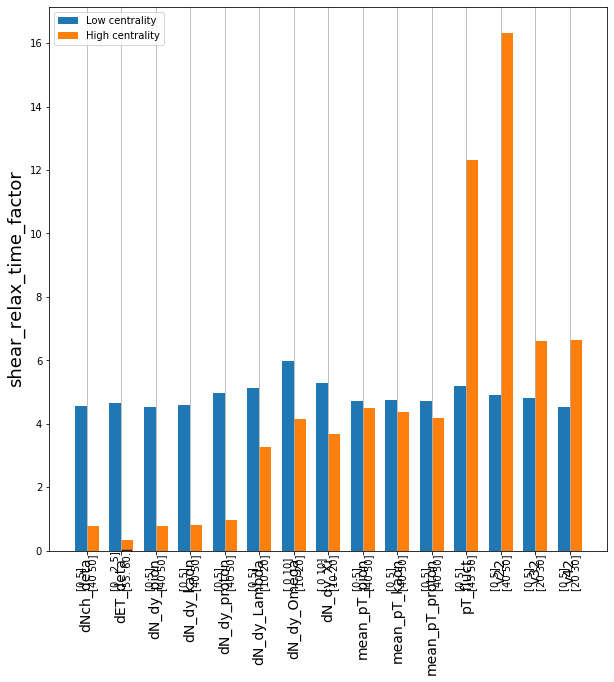

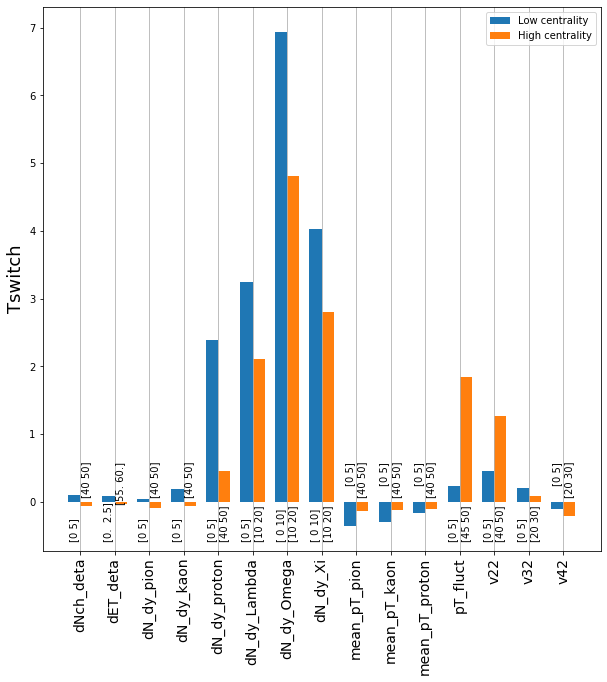

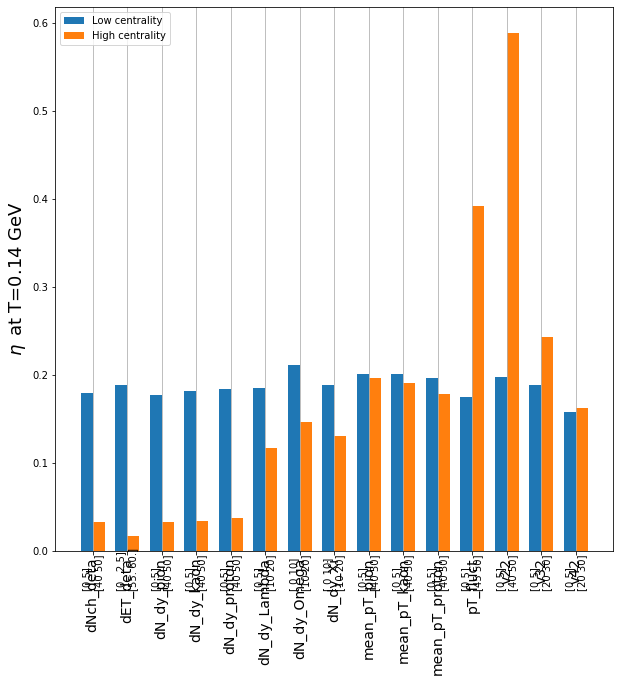

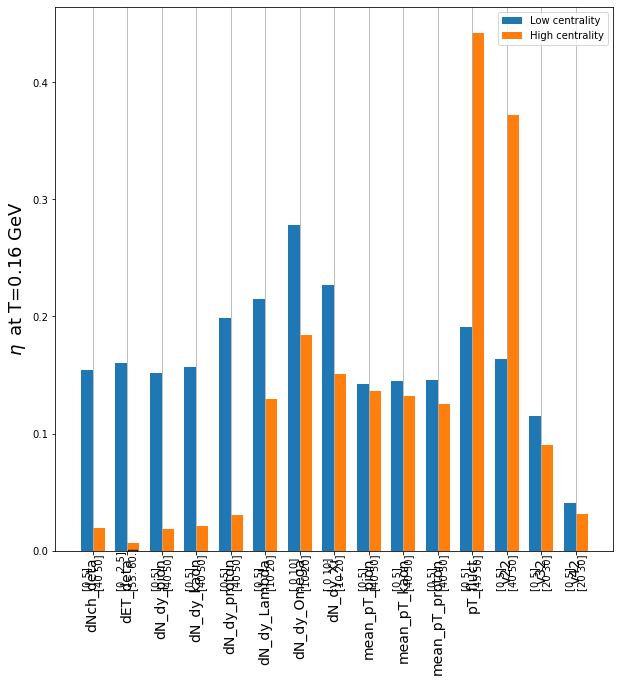

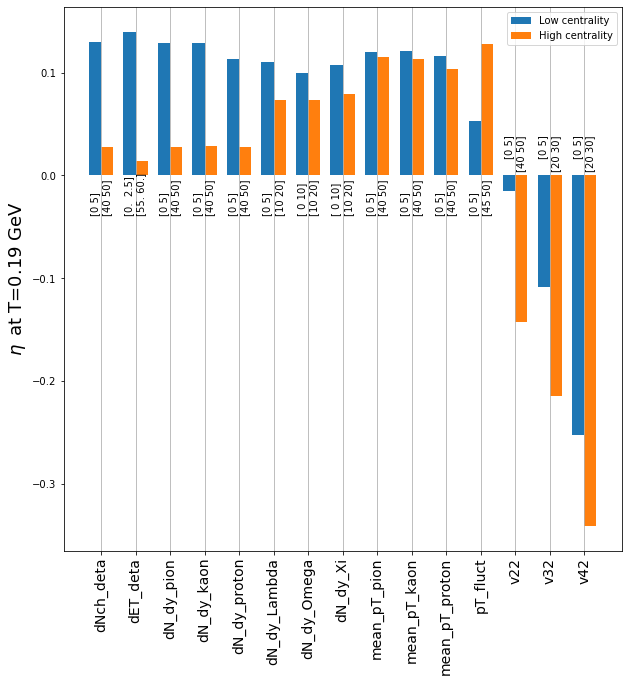

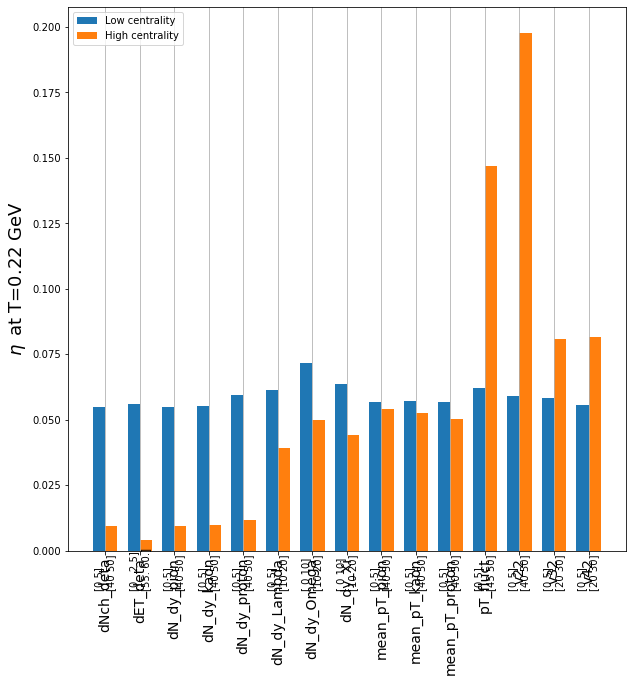

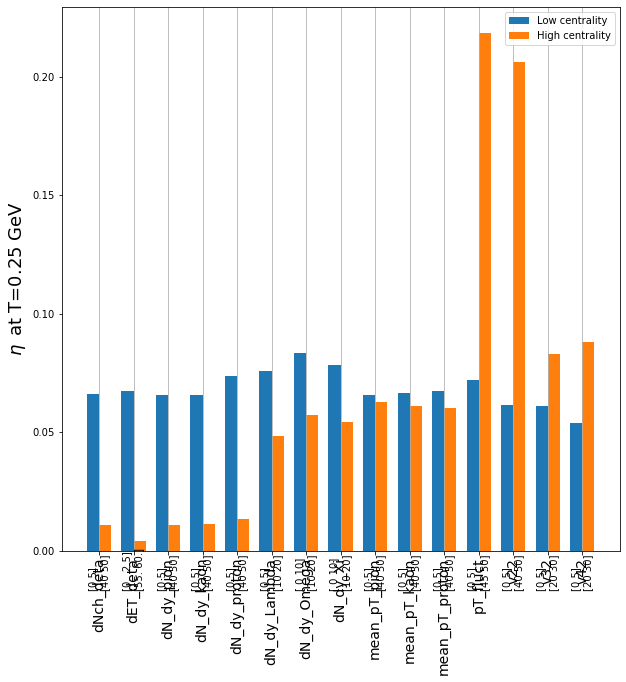

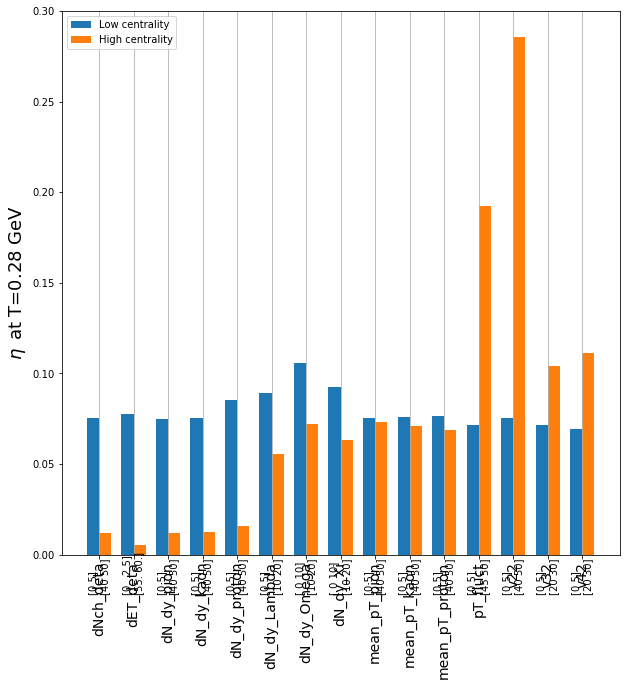

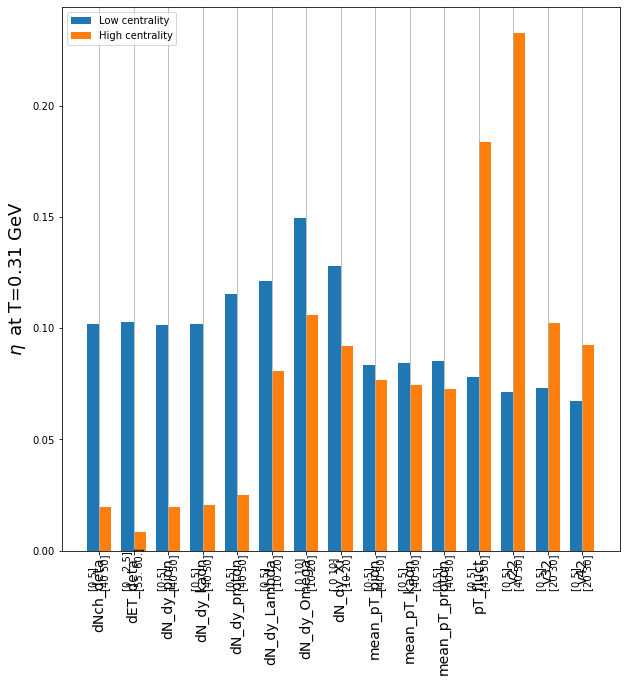

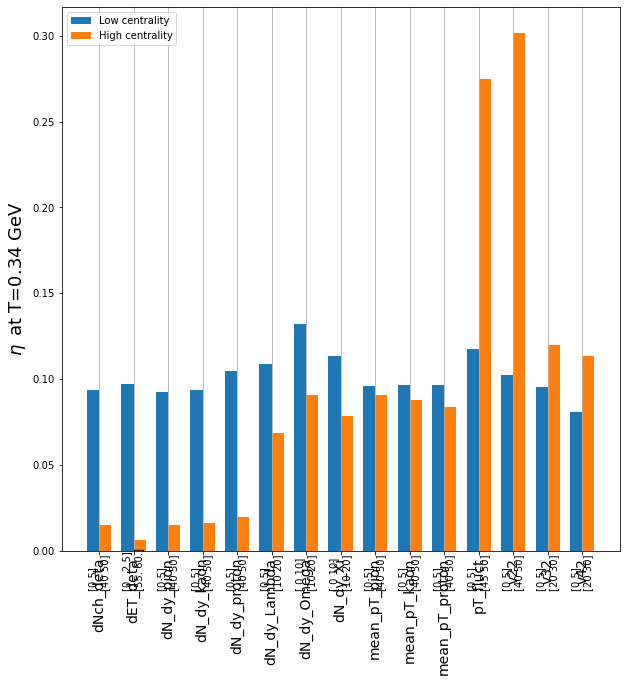

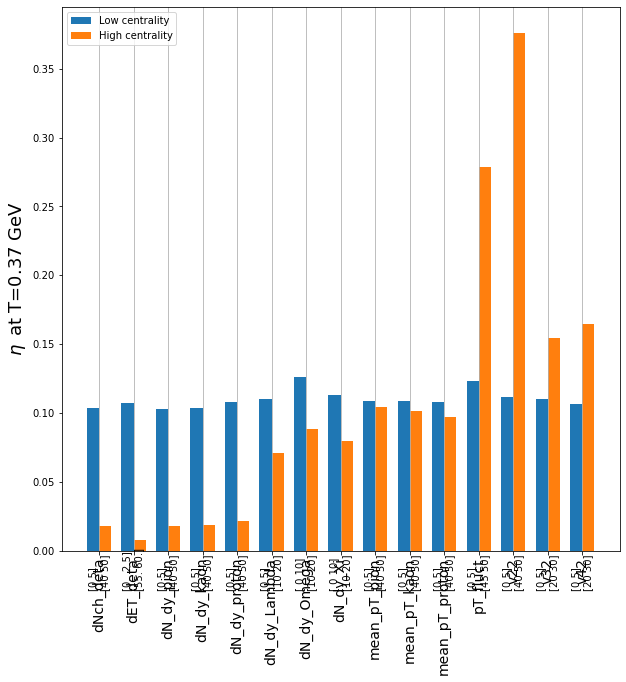

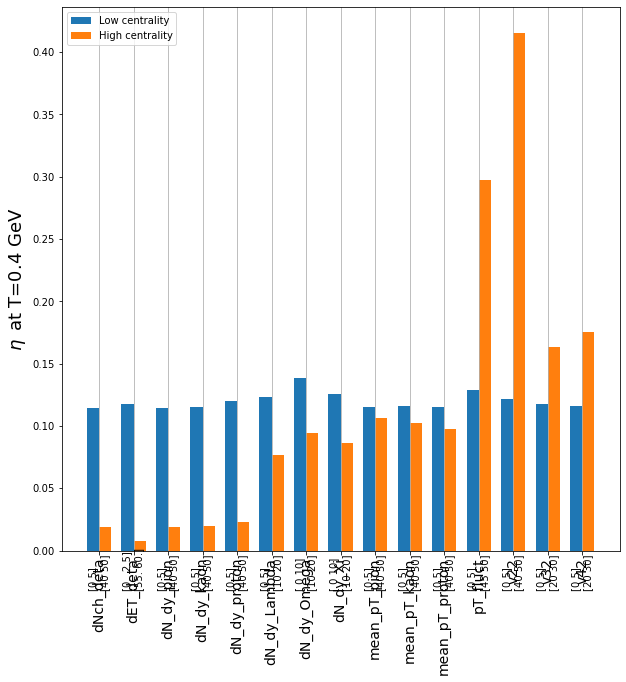

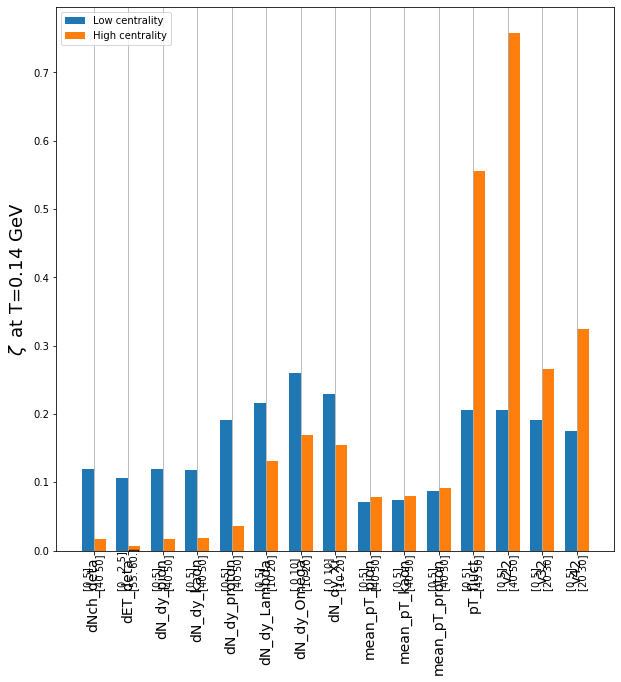

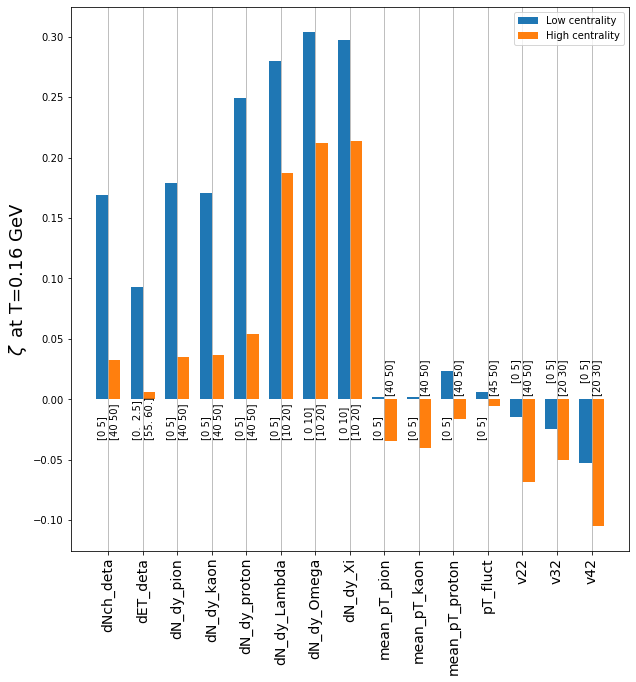

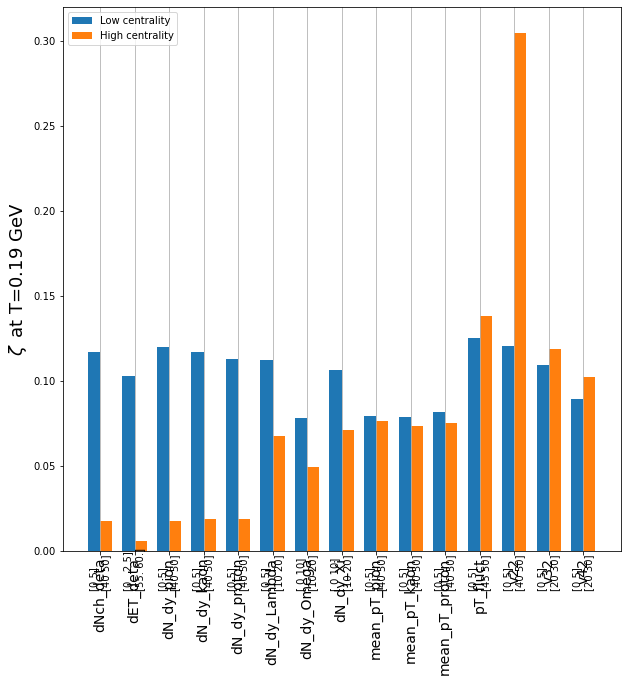

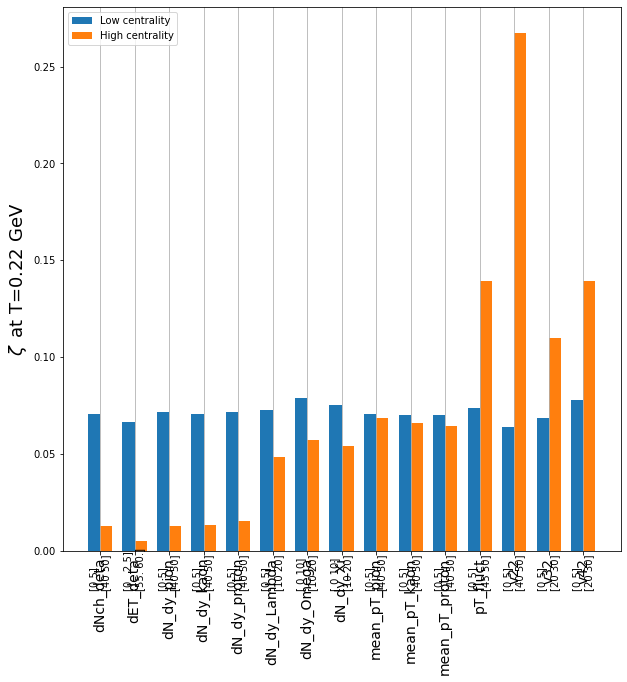

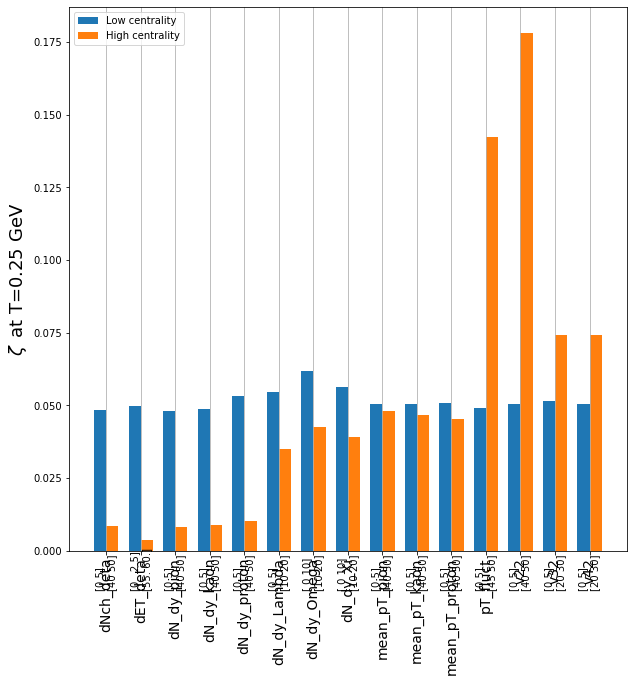

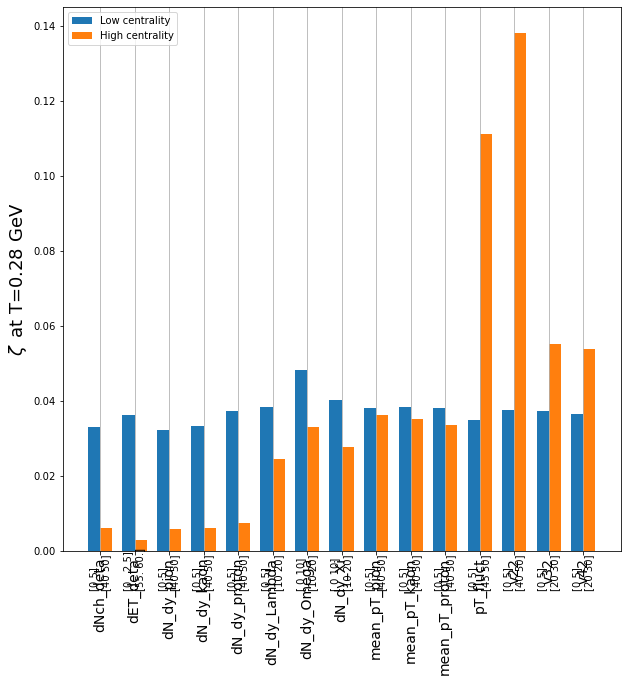

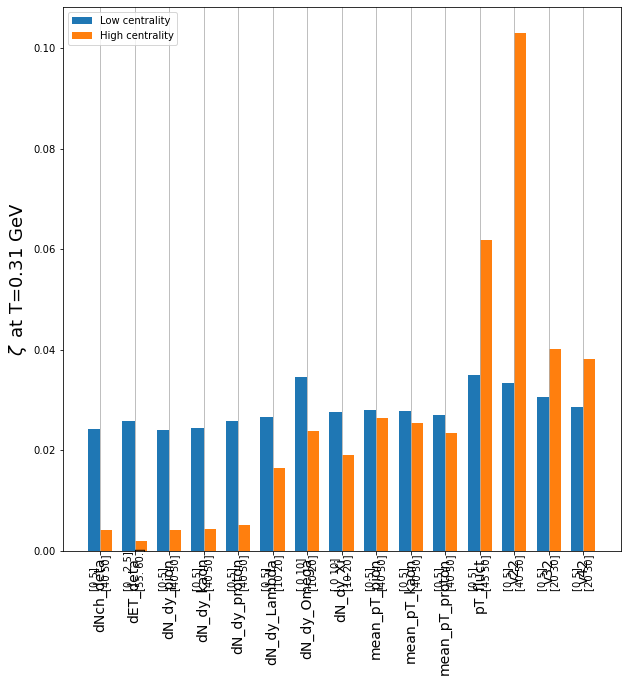

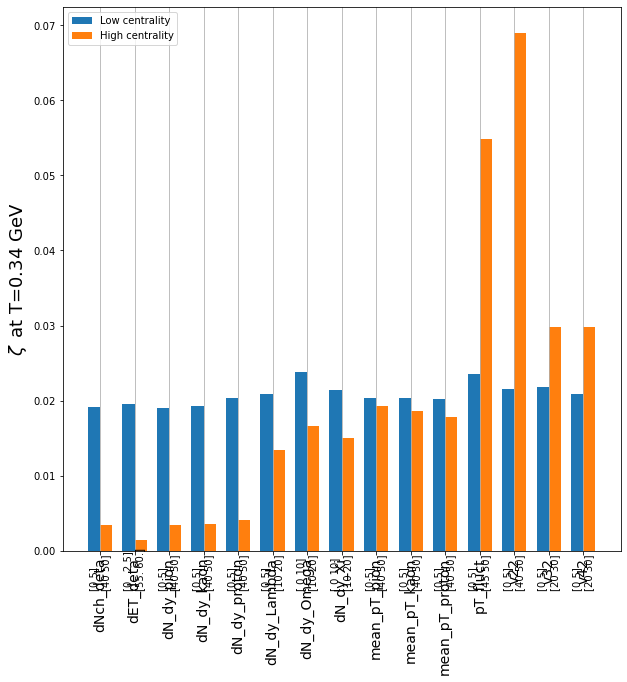

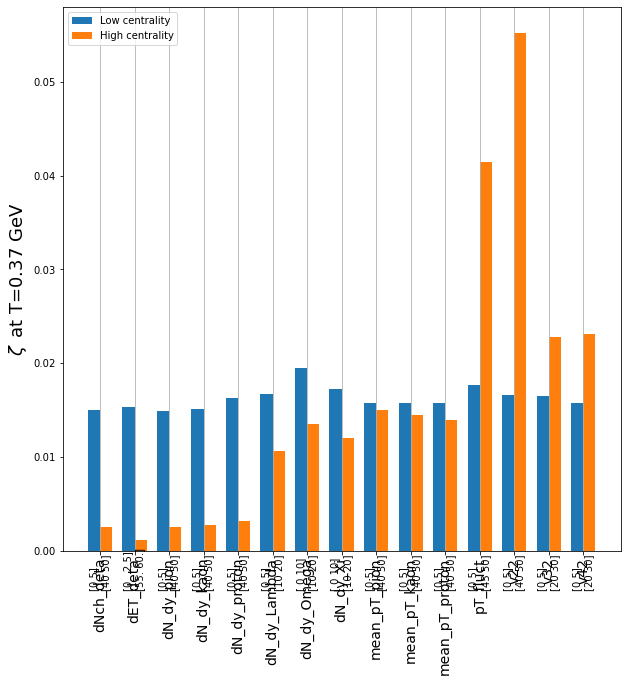

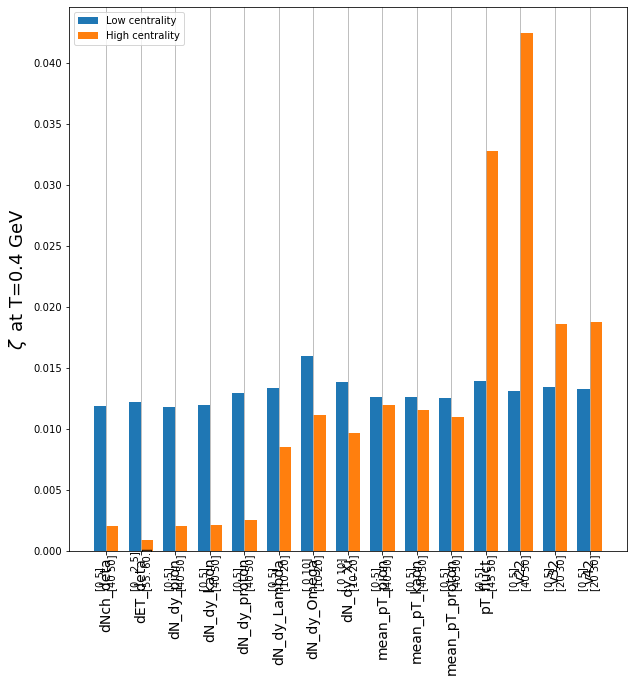

In [452]:
for i in range(0,29):
    sensitivity_plot_scott_grouped(40,i)

In [453]:
#Function where we specefy the observable.
# we will get a plot as a result showing how sensitive this observable for all centrality to all model parameters
#at MAp parameters


dicc=em._inverse_transform(grad_arry[2,:])

def sensitivity_plot_scott_grouped_with_error(centrality_begin,model_param):
    width = 0.35  # the width of the bars
    modelparam_Gradient=[]
    modelparam_Grad_sigma=[]
    MapObservabesUnits_1=[]
    MapObservabesUnits_2=[]
    sensitivity_list_1=[]
    sensitivity_error_1=[]
    sensitivity_list_2=[]
    sensitivity_error_2=[]

    X_values=[]
    X_name=[]
    label_1=[]
    label_2=[]
    temp_dic_all_grad=em._inverse_transform(grad_arry[model_param,:])
    temp_dic_all_var=em._inverse_transform(sigma_arry[model_param,:]**2)
    fig,ax=plt.subplots(nrows=1, ncols=1, sharex=False ,figsize=(10, 10))
    specefic_cen_num=[]
    dic_keys=[key for _,key in enumerate(dicc.keys())]
    for i in dicc.keys():
       # print(grad_arry[i,:])
       # print(temp_dic_all_grad)
      #  modelparam_Gradient.append(temp_dic_all_grad[observable_name])
      #  modelparam_Grad_sigma.append(temp_dic_all_var[observable_name])
        centrality=obs_cent_list["Pb-Pb-2760"][i]
    #fig,axes=plt.subplots(nrows=2, ncols=1, sharex=False ,figsize=(10, 10))
        n_cen=len(centrality)
    #brg= plt.get_cmap('brg')
    #colors = iter(brg(np.linspace(0,1,n_cen)))
    #print(X_values.shape)
    #X_values.reshape(29,)
    #print(n_cen)
    
        for j in range(0,n_cen):
            if centrality[j][0]== centrality_begin:
                #print(centrality[j][0])
                specefic_cen_num.append(j)
    #            MapObservabesUnits.append(MapObservabes[i][j])
    l=0
    for i,key in enumerate(dic_keys):

        sensitivity_list_1.append(temp_dic_all_grad[key][0])
        sensitivity_error_1.append(temp_dic_all_var[key][0])
        #print(temp_dic_all_grad[key][0])
        MapObservabesUnits_1.append(MapObservabes[key][0])
      #  X_values.append(2*l)
        X_name.append(dic_keys[i])
        label_1.append(str(obs_cent_list["Pb-Pb-2760"][key][0]))
        sensitivity_list_2.append(temp_dic_all_grad[key][-3])
        sensitivity_error_2.append(temp_dic_all_var[key][-3])
       # X_values.append(2*l+1)
       # X_name.append(dic_keys[i] + str(obs_cent_list["Pb-Pb-2760"][key][-3]))
        label_2.append(str(obs_cent_list["Pb-Pb-2760"][key][-3]))
        l=l+1
        # Change the following to -3 if you want to make the dimensionless quantity using MAP value of the
        #corresponding class. If it is 0 it uses the most central class observation to make the dimensionless quantity
        MapObservabesUnits_2.append(MapObservabes[key][-3])
   # print(MapObservabesUnits)
    #print(MapObservabesUnits)    
    #MapObservabesUnits=MapObservabesUnits+MapObservabesUnits
    X_values=np.arange(len(MapObservabesUnits_1))            
    #sensitivity_list_1=[grad_cent_arry[0] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list_2=[grad_cent_arry[-1] for jj,grad_cent_arry in enumerate(temp_dic_all_grad.values())]
    #sensitivity_list=sensitivity_list_1+sensitivity_list_2

    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #sensitivity_error=[grad_var_cent_arry[specefic_cen_num[jj]] for jj,grad_var_cent_arry in enumerate(temp_dic_all_var.values())]
    #print(len(X_values))
    #print(len(sensitivity_list))
        #sensitivity_list=np.array(sensitivity_list)
        #sensitivity_error=np.array(sensitivity_error)
    sensitivity_list_1=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_1[i]) for i,values in enumerate(sensitivity_list_1)]).flatten()
    sensitivity_error_1=np.sqrt([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_1[i]) for i,values in enumerate(sensitivity_error_1)]).flatten()


    sensitivity_list_2=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_2[i]) for i,values in enumerate(sensitivity_list_2)]).flatten()
    sensitivity_error_2=np.sqrt([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits_2[i]) for i,values in enumerate(sensitivity_error_2)]).flatten()



    #sensitivity_error=np.array([(values*Map_model_param_for_dim[model_param]/MapObservabesUnits[i]) for i,values in enumerate(sensitivity_error)]).flatten()


    #sensitivity_error=np.array([(values*Map_model_param_for_dim[i]/MapObservabes[observable_name][j]) for i,values in enumerate(sensitivity_error)]).flatten()
       # print(sensitivity_list)
       # print("error")
       # print(sensitivity_error)
                                   
        #print(f'length of sens {sensitivity_list.shape} and length of error {sensitivity_error.shape}')
        #ax.plot(X_values,sensitivity_list)
        #print(sensitivity_list)
       # print("error next")
       # print(sensitivity_error)
        #ax.errorbar(X_values,sensitivity_list,yerr=sensitivity_error,fmt='o',ecolor='r')
   # positives= sensitivity_list>0
       # negatives= sensitivity_list<0
       # ax.scatter(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5 , s= 200 , label= centrality[j],color=next(colors))
       # ax.plot(X_values,np.log(abs(sensitivity_list)), marker='x' , alpha=0.5, label= centrality[j],color=next(colors))
   # barlist=ax.bar(X_values,np.log(abs(sensitivity_list)))#,yerr=sensitivity_error)
   # barlist=ax.bar(X_values,sensitivity_list)#,yerr=sensitivity_error)

    rects1 = ax.bar(X_values - width/2, sensitivity_list_1,width, yerr=sensitivity_error_1, label='Low centrality')
    rects2 = ax.bar(X_values + width/2, sensitivity_list_2, width, yerr=sensitivity_error_2, label='High centrality')

    
   # for j,difference in enumerate(positives):
    #    if difference==False:
     #       barlist[j].set_color('c')  
       # ax.scatter(X_values[negatives],np.log(abs(sensitivity_list[negatives])), marker='x' , alpha=0.5 , s =200, label= centrality[j] , cmpa= 'PiYG' )
    ax.set_ylabel(all_model_labels[model_param],fontsize=18)
    ax.grid(b=True,axis='x')
    #ax.set_xticks(X_values) 
    ax.set_xticks(X_values)
    ax.set_xticklabels(X_name)
    #plt.xticks(X_values,X_name)
    #plt.xlabel(f'Observables',fontsize=18)
    plt.xticks(rotation='vertical',fontsize=14)
    #plt.legend()
   # plt.ylabel('Varied Observable',fontsize=18)
   # plt.tight_layout()
  #  blue_patch = mpatches.Patch(color='blue', label=' + Gradient')
  #  cyan_patch = mpatches.Patch(color='cyan', label=' - Gradient')
  #  plt.legend(handles=[blue_patch, cyan_patch])
    def autolabel(rects,labels):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for i,rect in enumerate(rects):
            height = rect.get_height()
            if height<0:
                va='top'
                space=40
            else:
                va='bottom'
                space=-40
            ax.annotate(labels[i],
                   # xy=(rect.get_x() + rect.get_width() / 2, height),
                    xy=(rect.get_x() + rect.get_width() / 2, 0),
                    xytext=(0,space),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va=va,rotation='90')
    plt.legend()
    autolabel(rects1,label_1)
    autolabel(rects2,label_2)
    #plt.title("Gradients")
    plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/sensitivity/with_error/sensitivity_{model_param}.png',dpi=100)
    plt.show()

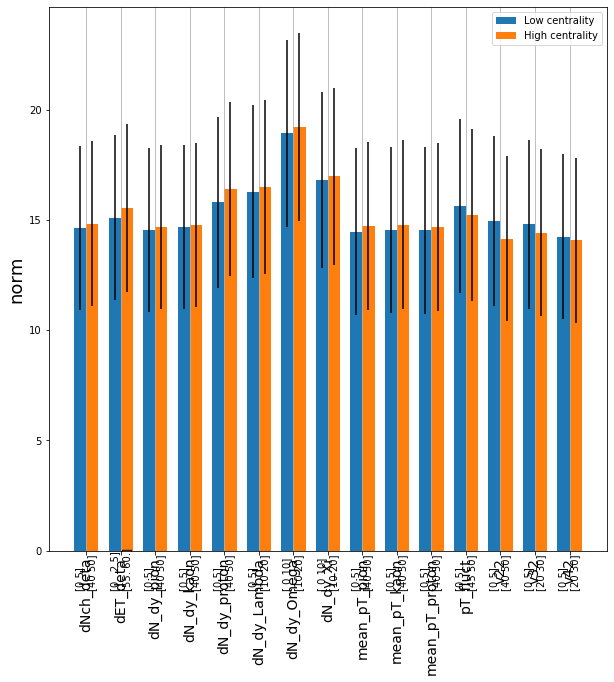

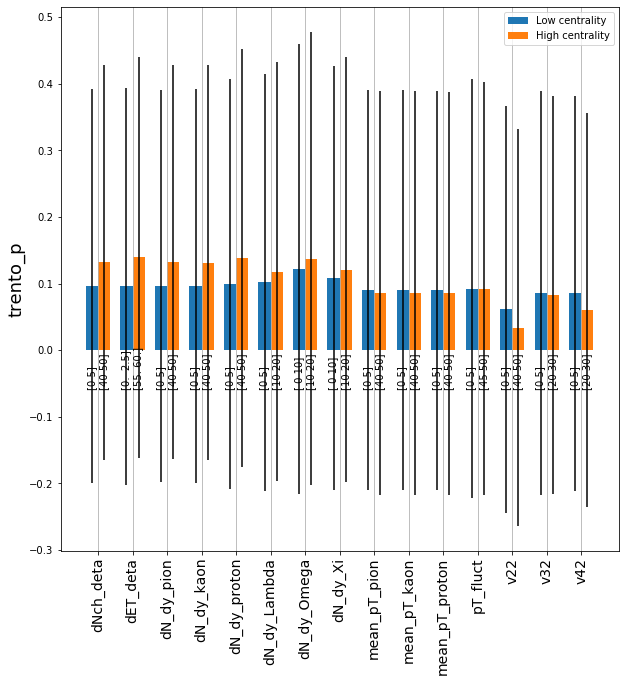

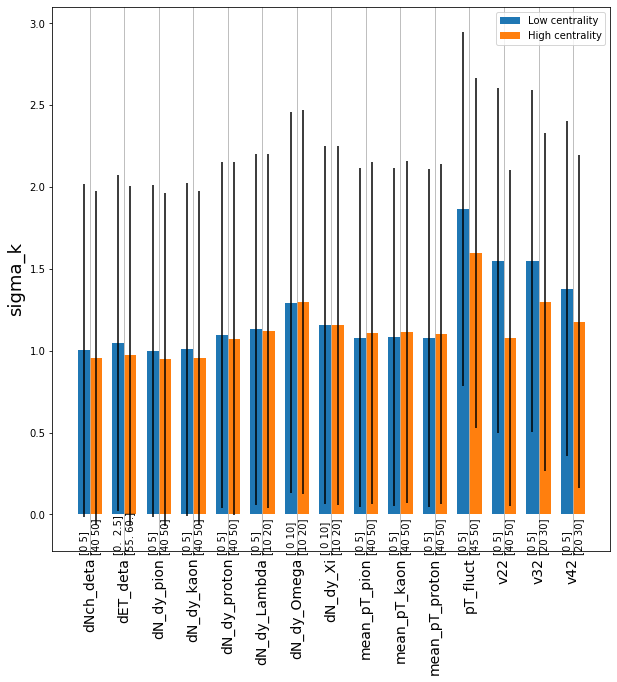

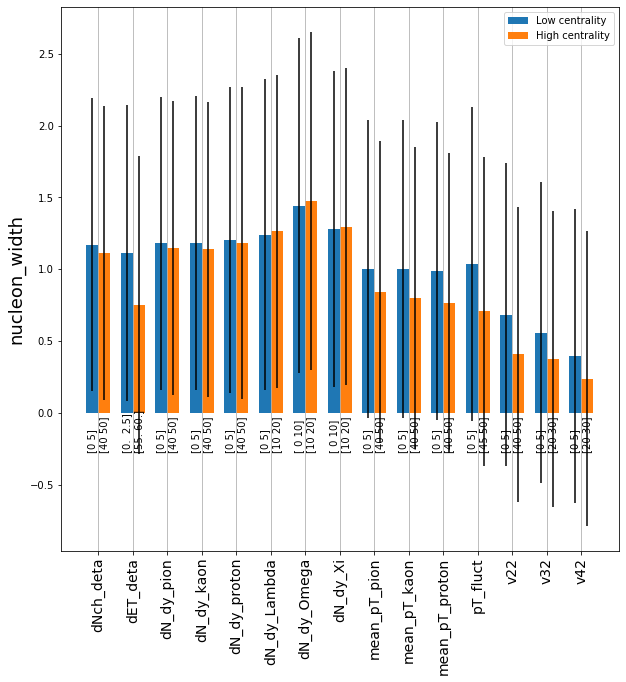

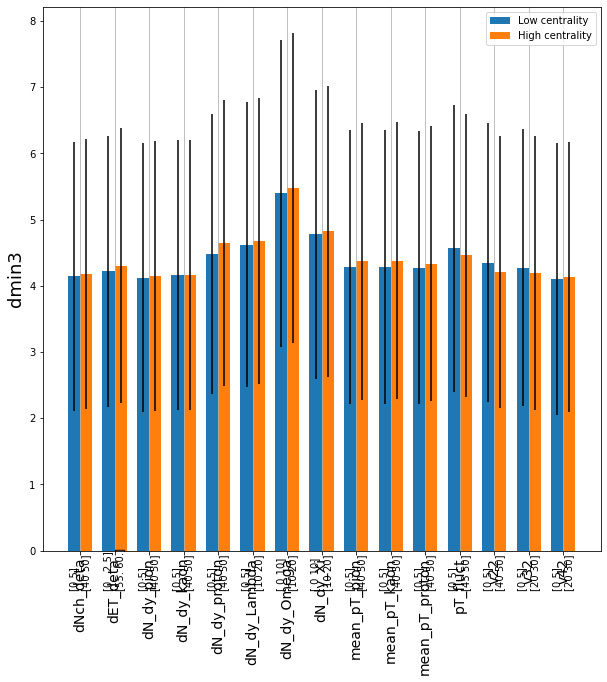

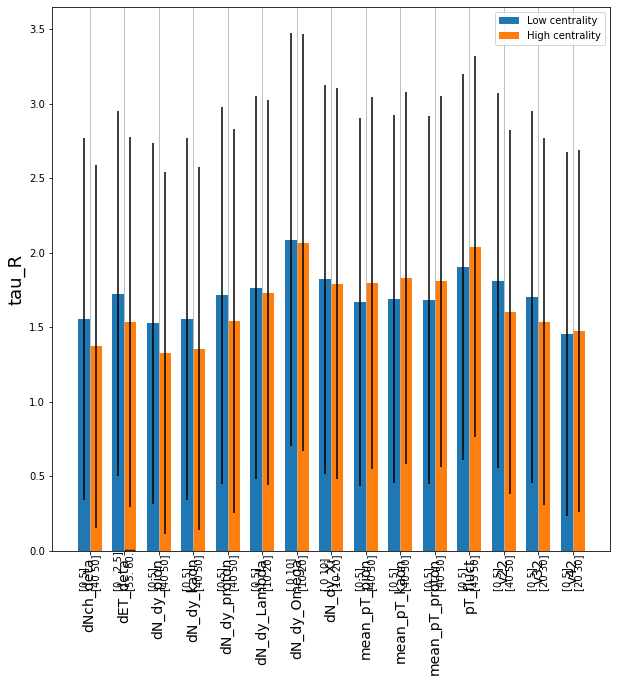

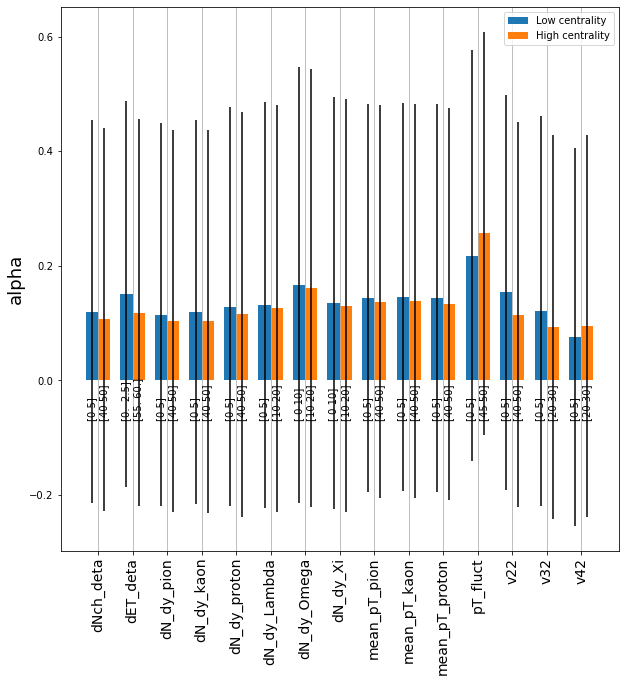

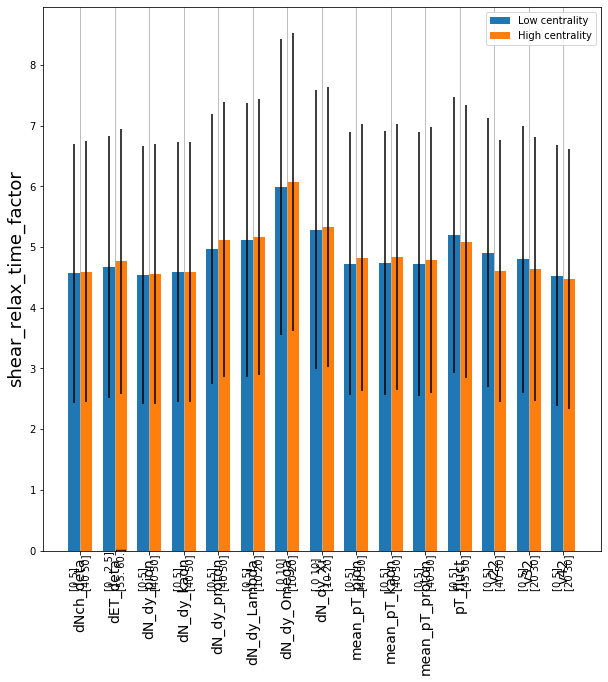

 /Users/dananjayaliyanage/Downloads/enter/envs/hc/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning:invalid value encountered in sqrt
 /Users/dananjayaliyanage/Downloads/enter/envs/hc/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning:invalid value encountered in sqrt


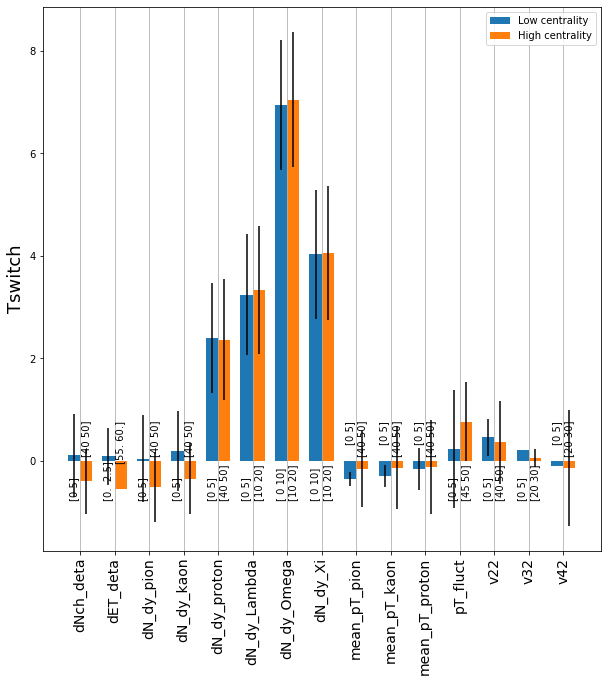

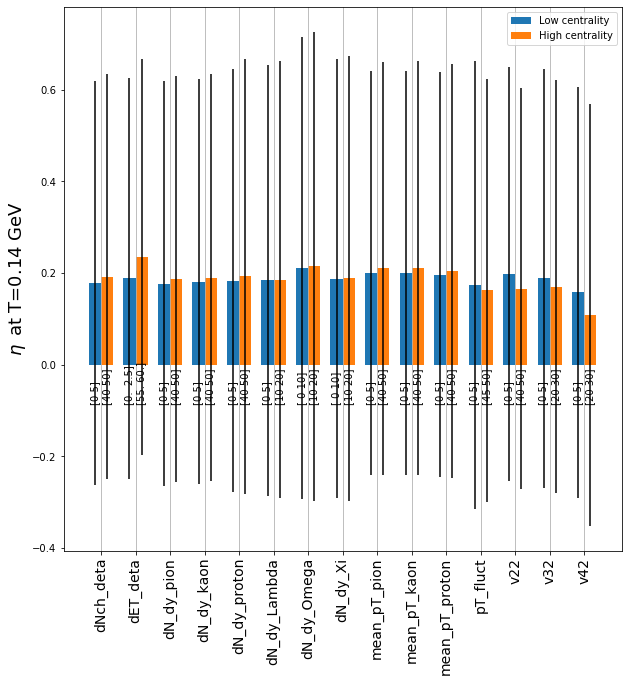

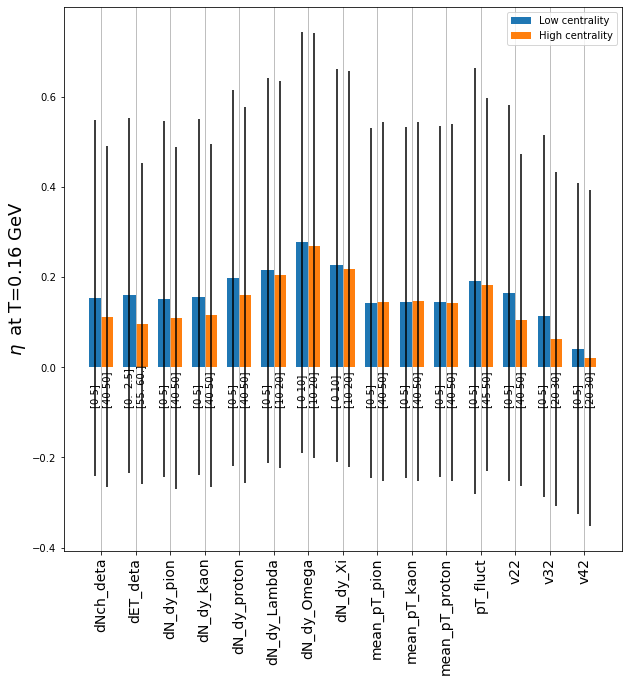

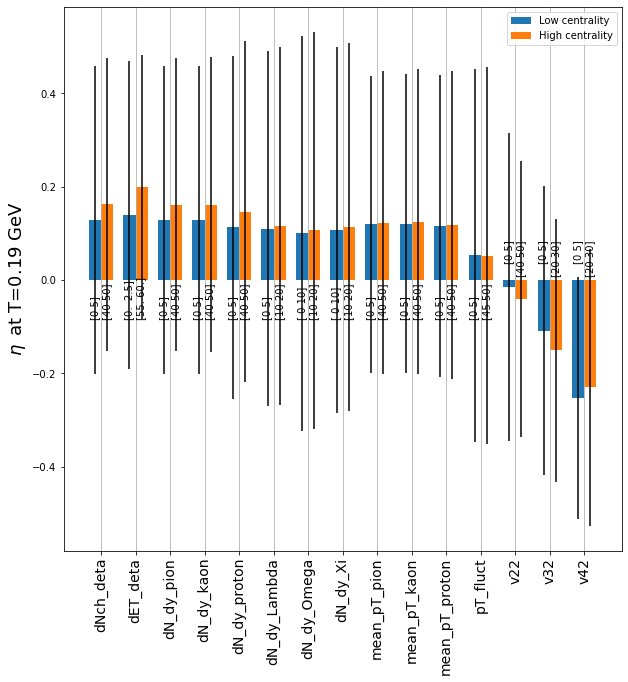

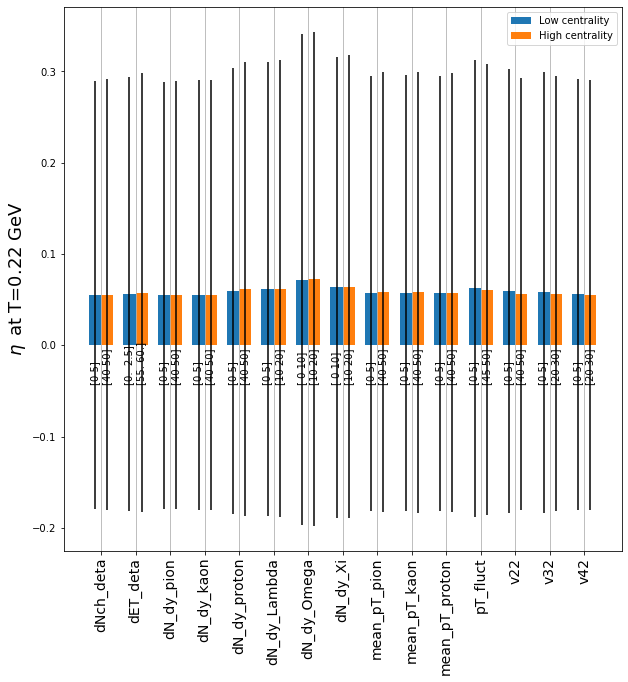

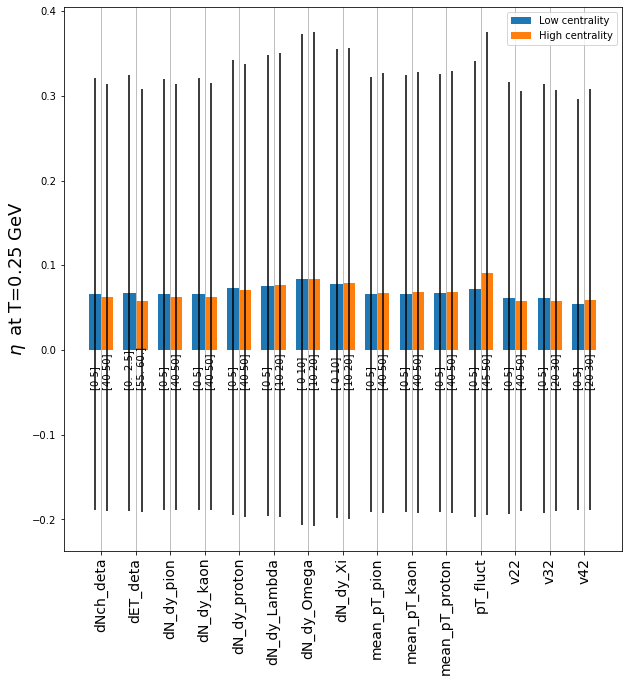

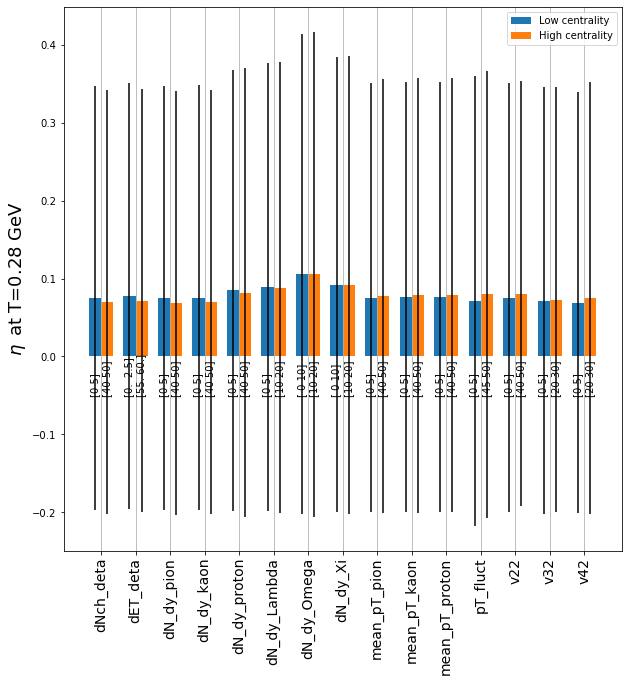

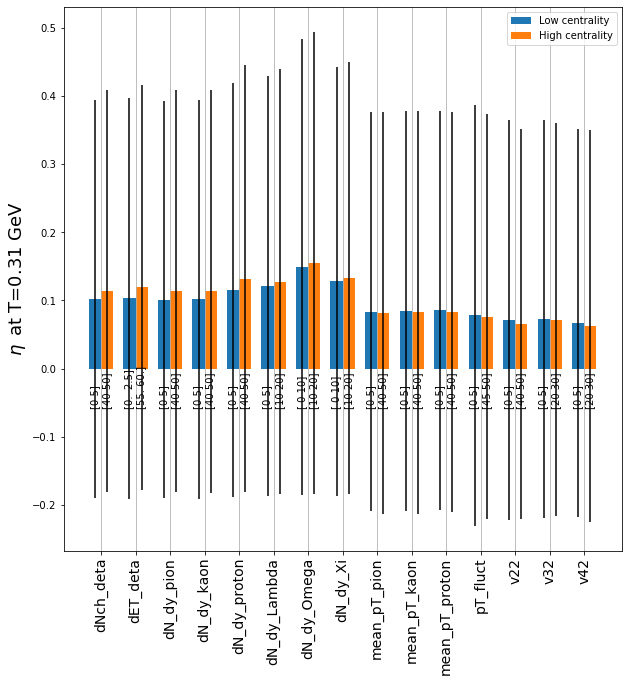

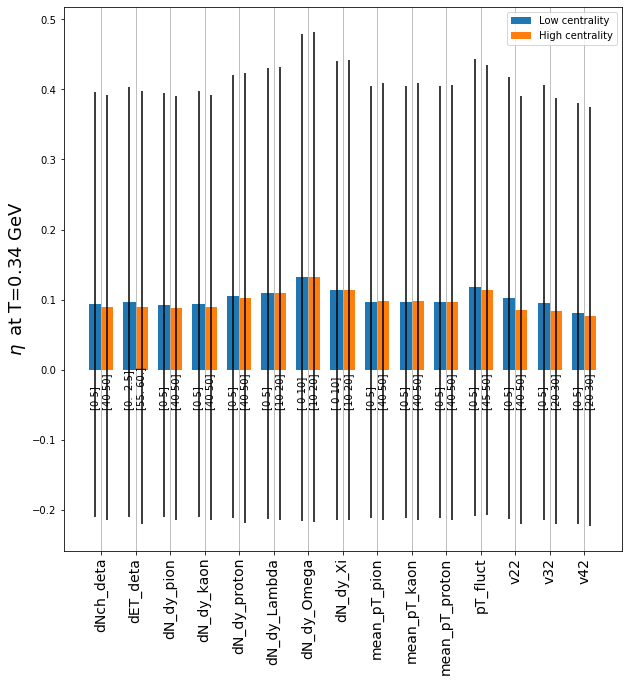

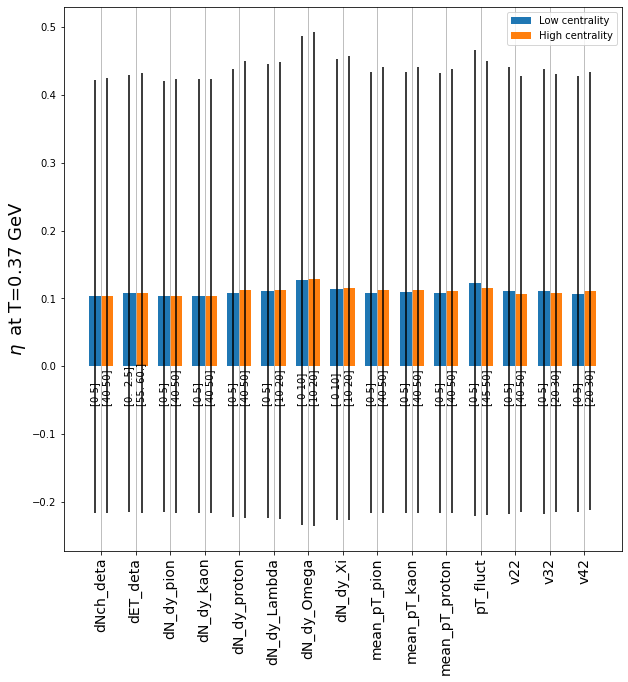

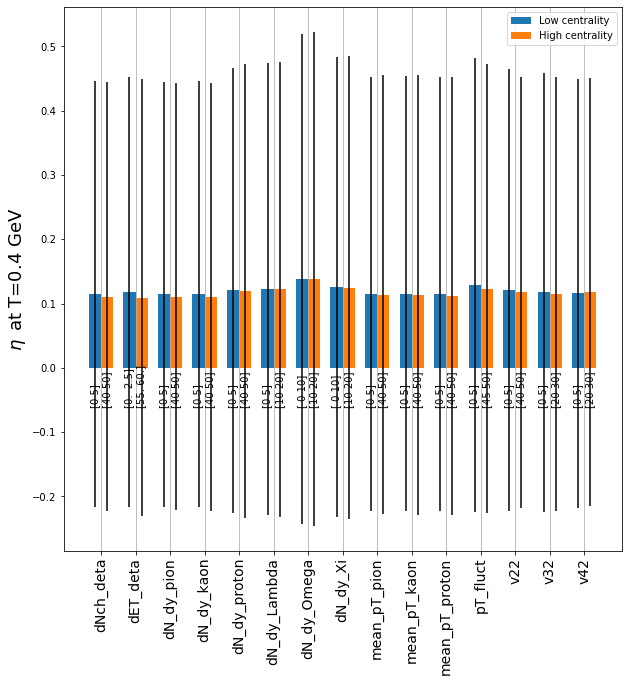

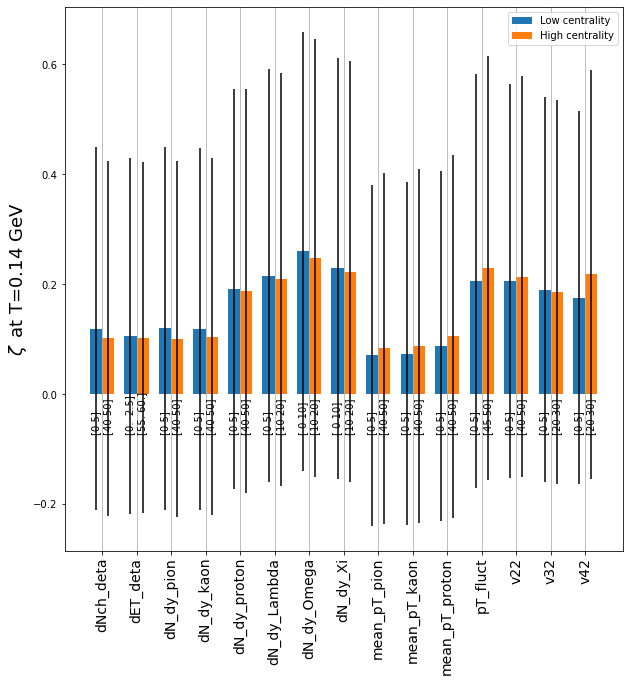

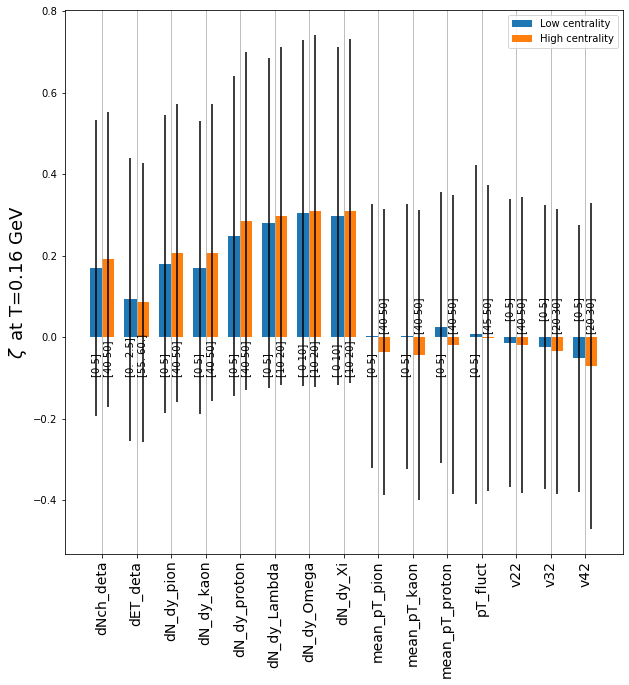

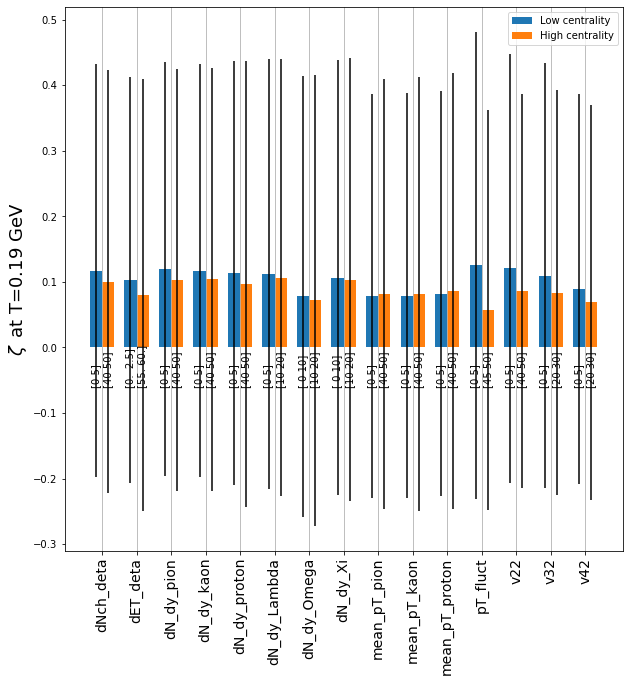

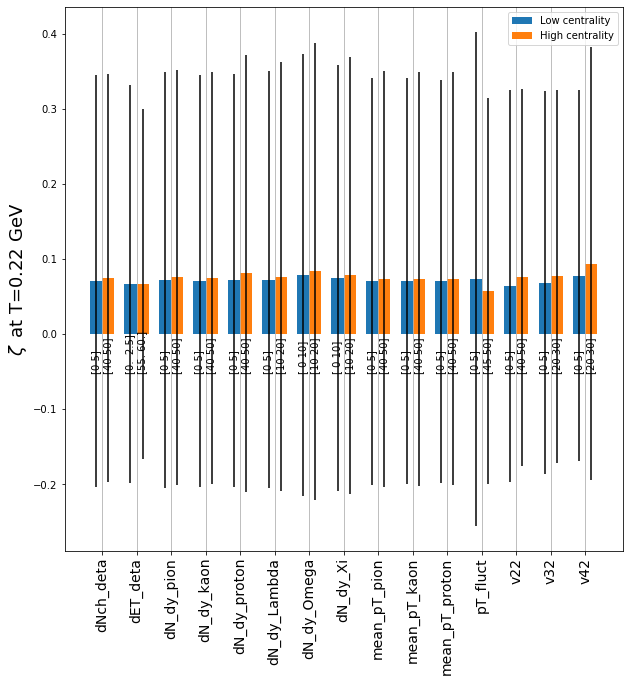

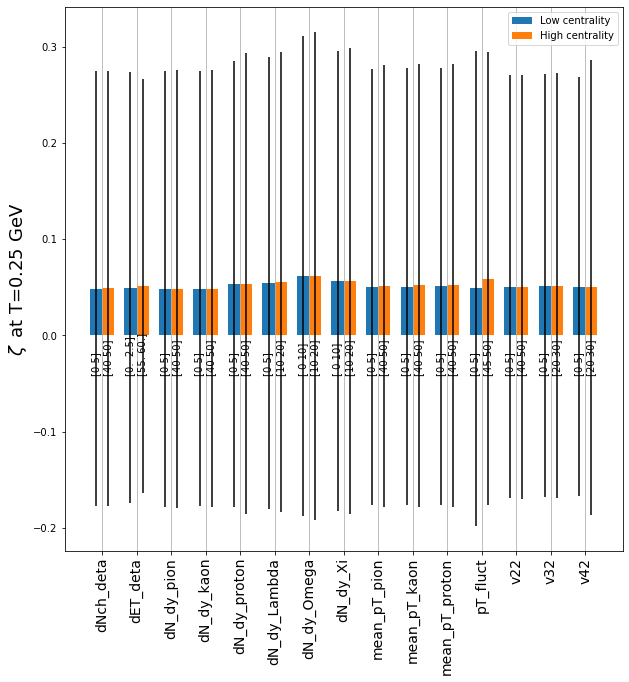

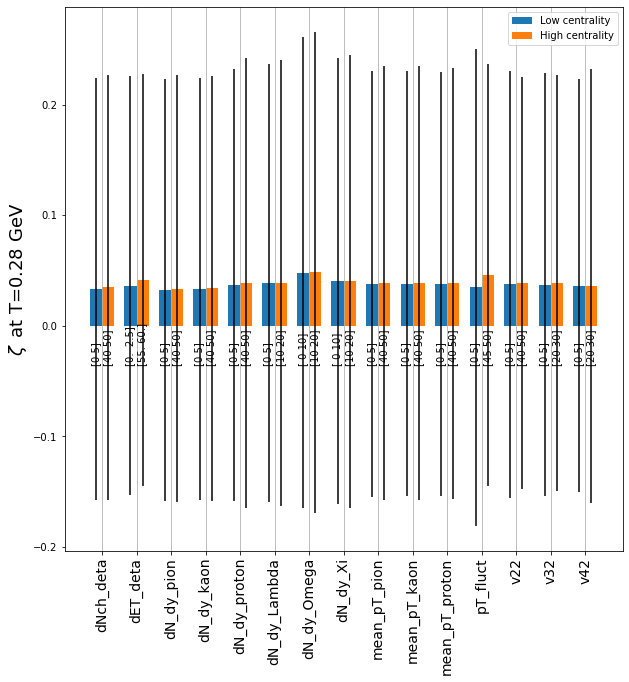

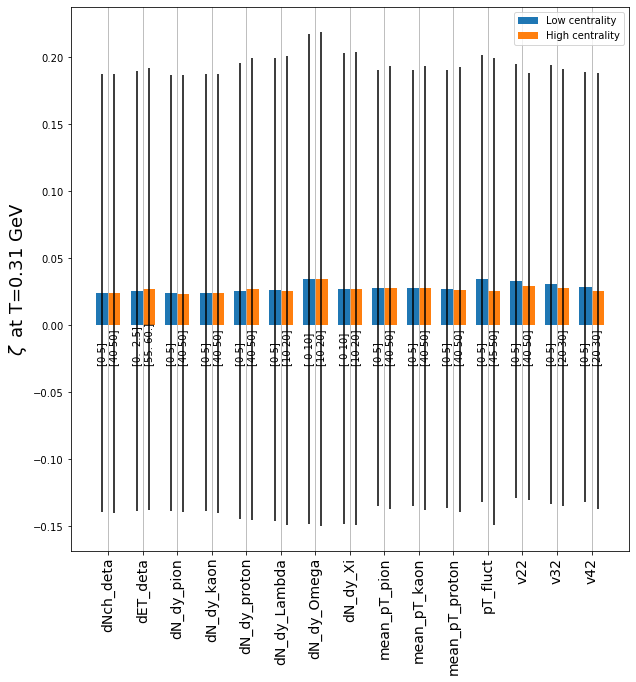

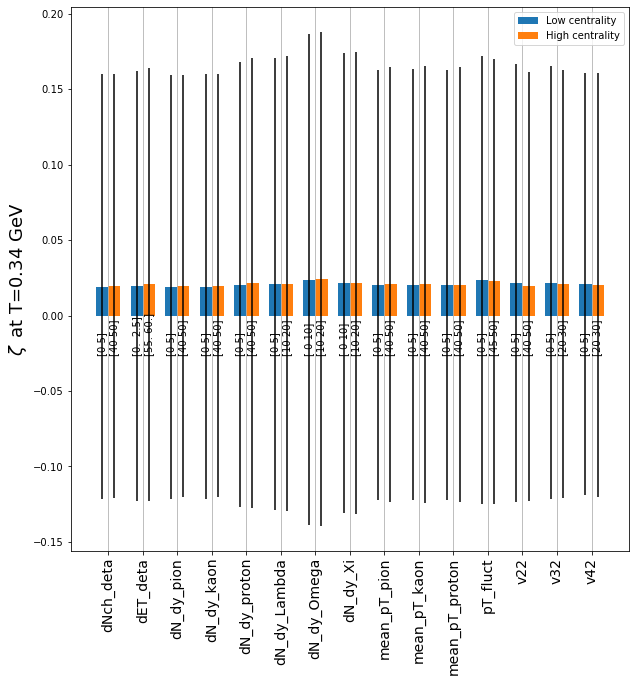

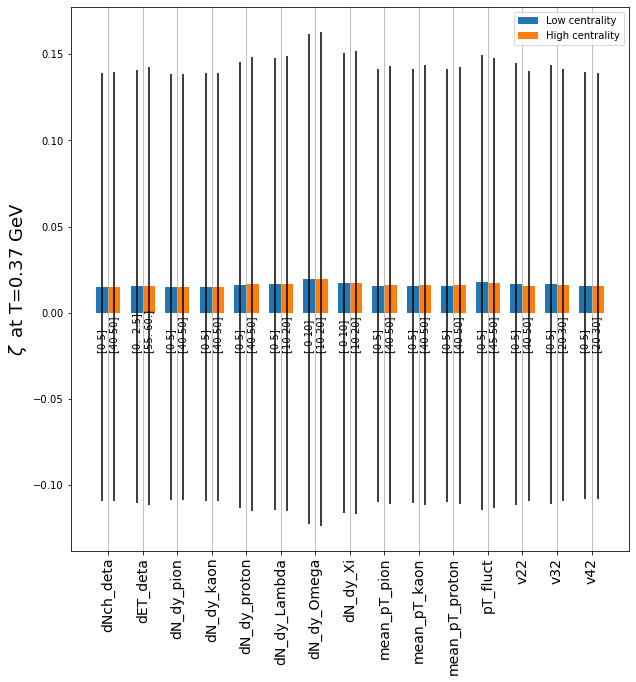

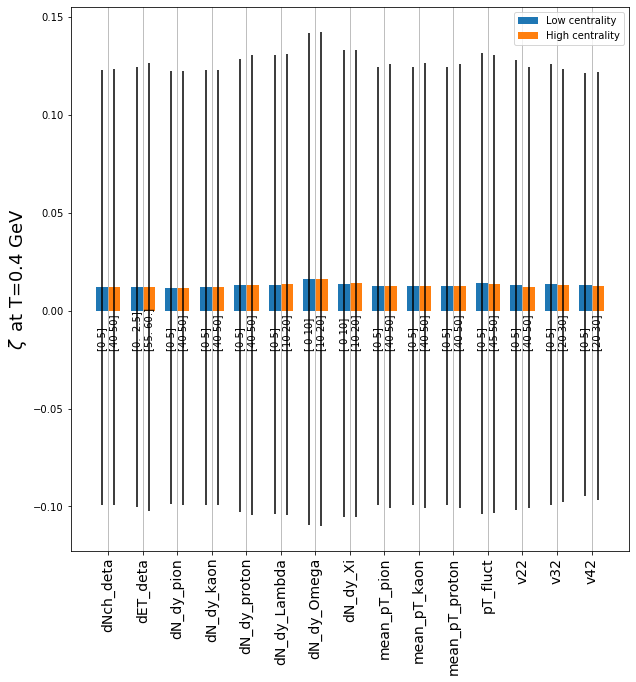

In [454]:
for i in range(0,29):
    sensitivity_plot_scott_grouped_with_error(40,i)

# Ignore the code belwo this point for now


In [35]:
#PCAgraphs(0,GPy_emulators)

In [36]:
design_nt, design_max_nt, design_min_nt, labels_nt =load_design(system_str='Pb-Pb-2760', pset='main')
design_nt= np.delete(np.array(design_nt),list(delete_design_pts_set), 0)

Loading main points from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat
Loading main ranges from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat
Summary of design : 


In [37]:
## get a design matrix of only one parameter varying
def getDesignMatrix_nt(param,MAP_parameter_Values):
    """get a design matrix of 300 uniformly distibuted points with only one parameter varying.
    All the other parameters are in the MAP values. return matrix dimension (300,29)"""
    x_eta=np.linspace(design_min_nt[param],design_max_nt[param],300) # get 300 x axis values for the plot
    LL=np.zeros((300,29))
    x=MAP_parameter_Values
   # print(x)
    for i,j in enumerate(x_eta):
        x[param]=j
        LL[i,:]=transform_design(x.reshape(1,-1))
    return LL,x_eta

In [38]:
#Write a function that will take one of the 10 GPy emulators and plot how the corresponding PCA value change
#with each parameter in the model keeping all the other parameters fixed at MAP values.... produce 29 graphs ....

def PCAgraphnt(PCA_number,GPy_array):
    m = GPy_array[PCA_number]
    x_star=MAP.reshape(29,)
    for k in range(0,17):
        LL,x_predict=getDesignMatrix_nt(k,np.array(MAP_params["Pb-Pb-2760"]))   
        mean_grad,var_grad=m.predict_jacobian(Xnew=LL)
        y_predict,var_predict=m.predict(Xnew=LL)
        # only get the diagonal and the relevent mean for changing model parameter
        diagonal=np.zeros((300,1))
        mean=np.zeros((300,1))
        #y_predict=np.zeros((300,1))
        #sigma_predict=np.zeros((300,1))
        for ii in range(0,300):
            cov=var_grad[ii]
            diagonal[ii]=cov.diagonal()[k]
            mean[ii]=mean_grad[ii][k]
        #    sigma_predict[i]=ysigma_predict.diagonal()[2]
        #print(y_predict)
        #y_predict=y_predict
        sigma_grad=np.sqrt(diagonal)
        mean_grad=mean
        sigma_predict=np.sqrt(var_predict)
        # Plot the function, the prediction and the 95% confidence interval based on
        # the MSE
        %matplotlib inline
        plt.figure(figsize=(10,10))
       #plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
        plt.plot(design_nt[:,k],Z.T[PCA_number], 'r.', markersize=10, label='simulation data')
        plt.plot(x_predict.flatten(), y_predict.flatten(), 'r', label='Prediction from GP emulator')
        plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
        plt.xlabel(f'model {labels_nt[k]}')
        plt.ylabel(f'PCA component {PCA_number}')
        #plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
        plt.plot(x_predict.flatten(), mean_grad.flatten(), 'k', label='Gradiant prediction')
        plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='y', ec='None')
        plt.title('Gradiant of the gaussian process found by Gpy')
        plt.tight_layout()
        plt.legend(loc='lower left')
        plt.show()
        plt.savefig(f'/Users/dananjayaliyanage/git/emulator-validation/graphs/emulator_gradients/ntemu{PCA_number}param{k}.png',dpi=100)

In [39]:
#PCAgraphnt(0,GPy_emulators)

In [40]:
#PCAgraphnt(0,GPy_emulators)

In [41]:
#x_star=np.random.uniform(design_min,design_max)

In [42]:
np.array(MAP_params["Pb-Pb-2760"])

array([14.128,  0.089,  1.054,  1.064,  4.227,  1.507,  0.113,  0.223,
       -1.585,  0.32 ,  0.056,  0.11 ,  0.16 ,  0.093, -0.084,  4.666,
        0.136])

In [43]:
LL2,x_predict=getDesignMatrix_nt(2,np.array(MAP_params["Pb-Pb-2760"])) 

In [44]:
LL1.shape

NameError: name 'LL1' is not defined

In [ ]:
map_values=np.array(MAP_params["Pb-Pb-2760"])

In [ ]:
map_values

In [ ]:
LL1[1,:]

In [ ]:
#x_eta=np.random.uniform(design_min[2],design_max[2],300)
